<a href="https://colab.research.google.com/github/Bewuket/DarkTerrianBewuket/blob/main/CNN_LSTM_model_GWS_9252025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN-LSTM (ConvLSTM U-Net) 2nd**

# **Spatiotemporal time (montlhy), spatial (500 pixle)**



# **References**
**CNN-LSTM**
*   https://doi.org/10.1016/j.ejrh.2022.100990
*   https://doi.org/10.1016/j.jhydrol.2021.126196
*   https://doi.org/10.1016/j.jhydrol.2023.129401
*   https://doi.org/10.1038/s41598-024-84810-5
*   https://doi.org/10.1038/s41598-024-82297-8
*   https://doi.org/10.1016/j.jhydrol.2025.132887

**CNN-Transformer** you might add model, then we can compare both model results
*   https://doi.org/10.1038/s41598-025-93671-5
*   https://doi.org/10.1016/j.jhydrol.2024.131250
*   https://doi.org/10.1016/j.jhydrol.2025.132840
*   https://doi.org/10.2166/nh.2024.124
*   https://doi.org/10.1029/2022WR032602
*   https://doi.org/10.2166/nh.2024.124
*   https://doi.org/10.1016/j.jhydrol.2024.131250


# **CNN-LSTM (ConvLSTM U-Net) 09252025**

In [ ]:
# =========================================
# CNN-LSTM (ConvLSTM U-Net) — End-to-end
# =========================================

# ========= Cell 1 — Install & imports =========
!pip -q install rasterio geopandas shapely tensorflow

import os, re, json, random, warnings, time
from pathlib import Path
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import Affine
from rasterio import features
import geopandas as gpd
from shapely.geometry import box, shape
import tensorflow as tf
from google.colab import drive

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, linewidth=120)
SEED = 1337
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print("TF:", tf.__version__)

# ========= Cell 2 — Mount Drive & paths =========
drive.mount('/content/drive', force_remount=False)

# --- SOURCE FOLDERS (edit if needed) ---
GRACE_ROOT = "/content/drive/My Drive/GRACEDOWNSCALED09092025SBlock2/bias_corrected_from_obs_arcgis_ready"
PRED_ROOT  = "/content/drive/My Drive/PREDICTORS_500m_STACKS_ALT3"

# --- DESTINATION (prepared data) ---
SEQ_LEN  = 12
PREP_DIR = f"/content/drive/My Drive/GW_PREPARED_CONVLSTM3_S{SEQ_LEN}"
os.makedirs(PREP_DIR, exist_ok=True)

# Sanitize accidental quotes
GRACE_ROOT = GRACE_ROOT.strip().rstrip("'").rstrip('"')
PRED_ROOT  = PRED_ROOT.strip().rstrip("'").rstrip('"')

print("GRACE exists:", os.path.isdir(GRACE_ROOT))
print("PRED  exists:", os.path.isdir(PRED_ROOT))
print("OUT   folder :", PREP_DIR)

# ========= Cell 3 — Robust discovery & alignment =========
GRACE_PAT = re.compile(r"grace[_\-]?downscaled[_\-]?(\d{6})[_\-]?arcgis", re.IGNORECASE)
PRED_PAT  = re.compile(r"predictors[_\-]?stack[_\-]?(\d{6})", re.IGNORECASE)

def find_tiffs(root):
    if not os.path.isdir(root): return []
    pats = ["**/*.tif","**/*.tiff","**/*.TIF","**/*.TIFF"]
    out = []
    for p in pats: out += list(Path(root).glob(p))
    return sorted(set(map(str, out)))

def index_by_yyyymm(paths, regex):
    m = {}
    for p in paths:
        s = regex.search(os.path.basename(p))
        if s:
            ym = s.group(1)
            m.setdefault(ym, p)  # keep first
    return dict(sorted(m.items(), key=lambda kv: (int(kv[0][:4]), int(kv[0][4:]))))

grace_paths = find_tiffs(GRACE_ROOT)
pred_paths  = find_tiffs(PRED_ROOT)
GMAP = index_by_yyyymm(grace_paths, GRACE_PAT)
PMAP = index_by_yyyymm(pred_paths,  PRED_PAT)

def rng(keys):
    if not keys: return ("—","—")
    ks = sorted(keys, key=lambda ym: (int(ym[:4]), int(ym[4:])))
    return ks[0], ks[-1]

common = sorted(set(GMAP.keys()).intersection(PMAP.keys()),
                key=lambda ym: (int(ym[:4]), int(ym[4:])))
LOW, HIGH = "200204", "202404"   # clamp to GRACE span
MONTHS = [m for m in common if LOW <= m <= HIGH]

print("GRACE months:", len(GMAP), "range:", rng(GMAP.keys()))
print("PRED  months:", len(PMAP), "range:", rng(PMAP.keys()))
print("COMMON      :", len(MONTHS), "range:", rng(MONTHS))
assert len(MONTHS) >= SEQ_LEN+3, "Not enough overlapping months after alignment."

# ========= Cell 4 — Reference grid from GRACE =========
ref_path = GMAP[MONTHS[0]]
with rasterio.open(ref_path) as src:
    REF_CRS = src.crs
    REF_TRANSFORM = src.transform
    H, W = src.height, src.width
print("REF grid:", (H, W), "CRS:", REF_CRS)

TF: 2.20.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GRACE exists: True
PRED  exists: True
OUT   folder : /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12
GRACE months: 222 range: ('200204', '202404')
PRED  months: 273 range: ('200204', '202412')
COMMON      : 222 range: ('200204', '202404')
REF grid: (61, 120) CRS: EPSG:4326


=== BAND DESCRIPTIONS (as stored in the file) ===
Band 1: elevation
Band 2: precipitation
Band 3: EVI
Band 4: SoilMoi40_100cm_inst
Band 5: lst
Band 6: runoff_mm
Band 7: aet_mm_month
Band 8: landcover
Band 9: ghs_pop
Band 10: precipitation_mean_3km
Band 11: precipitation_std_3km
Band 12: precipitation_mean_5km
Band 13: precipitation_std_5km
Band 14: EVI_mean_3km
Band 15: EVI_std_3km
Band 16: EVI_mean_5km
Band 17: EVI_std_5km
Band 18: SoilMoi40_100cm_inst_mean_3km
Band 19: SoilMoi40_100cm_inst_std_3km
Band 20: SoilMoi40_100cm_inst_mean_5km
Band 21: SoilMoi40_100cm_inst_std_5km
Band 22: lst_mean_3km
Band 23: lst_std_3km
Band 24: lst_mean_5km
Band 25: lst_std_5km
Band 26: runoff_mm_mean_3km
Band 27: runoff_mm_std_3km
Band 28: runoff_mm_mean_5km
Band 29: runoff_mm_std_5km
Band 30: aet_mm_month_mean_3km
Band 31: aet_mm_month_std_3km
Band 32: aet_mm_month_mean_5km
Band 33: aet_mm_month_std_5km
Band 34: ghs_pop_mean_3km
Band 35: ghs_pop_std_3km
Band 36: ghs_pop_mean_5km
Band 37: ghs_pop_std_5km

✓ Band ordering/descriptions are consistent across months.

BANDS_TO_USE = [1, 2, 3, 4, 5, 6, 7, 8, 9]
LC_IDX (0-based in the selected bands) = 7
BAND_LABELS = ['1 elevation', '2 precipitation', '3 EVI', '4 SoilMoi40_100cm_inst', '5 lst', '6 runoff_mm', '7 aet_mm_month', '8 landcover', '9 ghs_pop']

In [ ]:
# ========= Cell 4 — Reference grid from GRACE =========
ref_path = GMAP[MONTHS[0]]
with rasterio.open(ref_path) as src:
    REF_CRS = src.crs
    REF_TRANSFORM = src.transform
    H, W = src.height, src.width
print("REF grid:", (H, W), "CRS:", REF_CRS)

# ========= (Optional) Cell 4b — Earth Engine fallback deps =========
# Comment out if you will not use the EE fallback for the study polygon
!pip -q install earthengine-api geemap
import ee, geemap
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize(project='449353851478')

REF grid: (61, 120) CRS: EPSG:4326


In [ ]:
# ========= Cell 5 — Study-area mask (shapefile or EE fallback) =========
STUDY_SHP = "/content/drive/My Drive/Stellenboschadmshp/study_area.shp"
mask_path = os.path.join(PREP_DIR, "study_mask.npy")

def grid_bounds_from_affine(tr: rasterio.Affine, h: int, w: int):
    x0, y0 = tr * (0, 0)
    x1, y1 = tr * (w, h)
    return (min(x0, x1), min(y0, y1), max(x0, x1), max(y0, y1))

def rasterize_mask(gdf: gpd.GeoDataFrame, out_shape, transform, out_path):
    gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
    gdf["geometry"] = gdf.geometry.buffer(0)
    mask = features.rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8,
        all_touched=True
    )
    np.save(out_path, mask)
    return mask

if os.path.exists(mask_path):
    mask = np.load(mask_path).astype(np.float32)
    print("Loaded study mask from:", mask_path, "Valid pixels:", mask.sum())
else:
    gdf = None
    if os.path.exists(STUDY_SHP):
        try:
            gdf = gpd.read_file(STUDY_SHP)
            gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
            gdf = gdf.to_crs(REF_CRS)
            print("Loaded shapefile:", STUDY_SHP)
        except Exception as e:
            print("Could not read shapefile, will try Earth Engine:", e)

    if gdf is None or len(gdf) == 0:
        try:
            fc = ee.FeatureCollection('users/Bewuket_Tefera/Stellenboschadmshp')
            gj = fc.geometry().getInfo()
            geom = shape(gj)
            gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:4326").to_crs(REF_CRS)
            print("Loaded geometry from Earth Engine asset.")
        except Exception as e:
            raise RuntimeError("Failed to obtain study area from both shapefile and Earth Engine.") from e

    grid_bounds = grid_bounds_from_affine(REF_TRANSFORM, H, W)
    overlaps = gdf.unary_union.intersects(box(*grid_bounds))
    if not overlaps:
        print("⚠️ WARNING: Study area does not intersect the prepared grid. Check CRS/extent.")
    mask = rasterize_mask(gdf, out_shape=(H, W), transform=REF_TRANSFORM, out_path=mask_path)
    mask = mask.astype(np.float32)
    print("Study mask ->", mask.shape, "valid pixels:", int(mask.sum()))
mask4 = mask[None, None, ..., None]  # (1,1,H,W,1)


Loaded geometry from Earth Engine asset.
Study mask -> (61, 120) valid pixels: 4250


In [ ]:
# ========= Cell 6 — Readers with nodata-safe reprojection =========
# Use *first 9* bands (your confirmed order) and nearest for landcover (band 8)
BANDS_TO_USE = list(range(1, 10))   # 1..9 (elevation..ghs_pop)
LC_BANDNUM  = 8                     # landcover is band #8 (1-based)
LC_IDX      = BANDS_TO_USE.index(LC_BANDNUM)  # 0-based within our subset
TARGET_BAND = 1
NODATA_FLOOR = -9000.0               # treat values <= this as invalid for GRACE

def read_and_resample(path, dst_h, dst_w, dst_transform, dst_crs,
                      band_indices=None,
                      resampling=Resampling.bilinear,
                      src_nodata=None,
                      dst_nodata=0.0):
    with rasterio.open(path) as src:
        if band_indices is None:
            band_indices = list(range(1, src.count+1))
        src_nd = src_nodata if src_nodata is not None else src.nodata
        out = np.full((len(band_indices), dst_h, dst_w), dst_nodata, dtype=np.float32)
        for i, b in enumerate(band_indices):
            reproject(
                source=rasterio.band(src, b),
                destination=out[i],
                src_transform=src.transform, src_crs=src.crs,
                dst_transform=dst_transform, dst_crs=dst_crs,
                src_nodata=src_nd, dst_nodata=dst_nodata,
                resampling=resampling
            )
        return np.nan_to_num(out, nan=dst_nodata, posinf=dst_nodata, neginf=dst_nodata)

def read_predictors_resampled(ym):
    arr = read_and_resample(PMAP[ym], H, W, REF_TRANSFORM, REF_CRS,
                            band_indices=BANDS_TO_USE,
                            resampling=Resampling.bilinear)
    lc = read_and_resample(PMAP[ym], H, W, REF_TRANSFORM, REF_CRS,
                           band_indices=[LC_BANDNUM],
                           resampling=Resampling.nearest)[0]
    arr[LC_IDX] = lc
    return arr  # (B,H,W)

def read_target_resampled_with_mask(ym, band_id=TARGET_BAND):
    y = read_and_resample(GMAP[ym], H, W, REF_TRANSFORM, REF_CRS,
                          band_indices=[band_id],
                          resampling=Resampling.bilinear)[0]
    m = (np.isfinite(y) & (y > NODATA_FLOOR)).astype(np.float32)
    y = np.where(m > 0.5, y, 0.0).astype(np.float32)
    return y, m

In [ ]:
# ========= Cell 7 — Splits (70/15/15) + window indices =========
def build_windows(keys, seq_len):
    Xk, Yk = [], []
    for i in range(seq_len, len(keys)):
        Xk.append(keys[i-seq_len:i])
        Yk.append(keys[i])
    return Xk, Yk

N = len(MONTHS)
n_tr = max(SEQ_LEN+1, int(0.7*N))
n_va = max(SEQ_LEN+1, int(0.15*N))
train_months = MONTHS[:n_tr]
val_months   = MONTHS[n_tr:n_tr+n_va]
test_months  = MONTHS[n_tr+n_va:]

Xk_tr, Yk_tr = build_windows(train_months, SEQ_LEN)
Xk_va, Yk_va = build_windows(val_months,   SEQ_LEN)
Xk_te, Yk_te = build_windows(test_months,  SEQ_LEN)

print(f"Windows  train:{len(Xk_tr)}  val:{len(Xk_va)}  test:{len(Xk_te)}")
assert len(Xk_tr) > 0, "No train windows — lower SEQ_LEN or widen training range."

Windows  train:143  val:21  test:22


In [ ]:
# ========= Cell 8 — Normalization stats (TRAIN windows, study ∧ valid) =========
mask_f = mask.astype(np.float32)
mvec = (mask_f.reshape(-1) > 0.5)

def compute_predictor_norm_stats(Xkeys, cap=350):
    idxs = list(range(len(Xkeys)))
    if len(idxs) > cap:
        idxs = sorted(random.sample(idxs, cap))
    B = len(BANDS_TO_USE)
    sums = np.zeros(B, np.float64)
    sqs  = np.zeros(B, np.float64)
    cnts = np.zeros(B, np.float64)
    for idx in idxs:
        for ym in Xkeys[idx]:
            arr = read_predictors_resampled(ym)            # (B,H,W)
            arr = np.nan_to_num(arr, nan=0.0)
            arr = arr * mask_f[None, ...]                  # restrict to study area
            flat = arr.reshape(B, -1)
            for b in range(B):
                v = flat[b][mvec]
                if v.size:
                    sums[b] += v.sum()
                    sqs[b]  += (v*v).sum()
                    cnts[b] += v.size
    means = sums / np.maximum(cnts, 1.0)
    stds  = np.sqrt(np.maximum(sqs/np.maximum(cnts,1.0) - means**2, 1e-12))
    return means.astype(np.float32), stds.astype(np.float32)

def compute_target_norm_stats(Ykeys, cap=350):
    idxs = list(range(len(Ykeys)))
    if len(idxs) > cap:
        idxs = sorted(random.sample(idxs, cap))
    s = 0.0; ss = 0.0; n = 0.0
    for i in idxs:
        ym = Ykeys[i]
        y, m = read_target_resampled_with_mask(ym)        # y finite, masked by data mask
        m2 = (m * mask_f).astype(np.float32)              # also restrict to study area
        v = y[m2 > 0.5]
        if v.size:
            s  += float(v.sum())
            ss += float((v**2).sum())
            n  += float(v.size)
    mean = s / max(n, 1.0)
    var  = max(ss / max(n, 1.0) - mean**2, 1e-12)
    std  = float(np.sqrt(var))
    return np.float32(mean), np.float32(std)

# >>> Compute stats BEFORE saving meta <<<
band_means, band_stds = compute_predictor_norm_stats(Xk_tr)
y_mean, y_std         = compute_target_norm_stats(Yk_tr)

print("Predictor means:", np.round(band_means, 4))
print("Predictor stds :", np.round(band_stds, 4))
print(f"Target z-stats : mean={y_mean:.4f}  std={y_std:.4f}")


Predictor means: [389.8515   1.6489   0.2438  67.9385  21.5809   7.5245  34.2831   9.3906   1.7346]
Predictor stds : [362.5076   1.4155   0.1126  37.9727  10.1387  10.6602  20.4608   2.6361  10.7007]
Target z-stats : mean=1.7777  std=8.5812


In [ ]:
# ========= Cell 9 — Window loader -> (X_norm, [Yz,Mask]) =========
def load_window(x_months, y_month):
    seq = []
    for ym in x_months:
        arr = read_predictors_resampled(ym)  # (B,H,W)
        arr = (arr - band_means[:, None, None]) / (band_stds[:, None, None] + 1e-6)
        arr = arr * mask_f[None, ...]
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        seq.append(np.moveaxis(arr, 0, -1).astype(np.float32))
    X = np.stack(seq, axis=0).astype(np.float32)  # (T,H,W,C)

    Y, M = read_target_resampled_with_mask(y_month)
    M2   = (M * mask_f).astype(np.float32)
    Yz   = ((Y - y_mean) / (y_std + 1e-6)) * M2
    YM   = np.stack([Yz, M2], axis=-1).astype(np.float32)
    return X, YM

In [ ]:
# ========= Cell 10 — Save helpers (memmap writers) =========
def make_dir(p): os.makedirs(p, exist_ok=True); return p

def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def create_memmap(path, shape, dtype=np.float32):
    if os.path.exists(path): os.remove(path)
    return np.memmap(path, mode="w+", dtype=dtype, shape=shape)

def write_split(split_name, Xk, Yk, base_dir):
    split_dir = make_dir(os.path.join(base_dir, split_name))
    n = len(Xk)
    if n == 0:
        print(f"[{split_name}] empty, skipping write.")
        return None
    C = len(BANDS_TO_USE)
    X_shape = (n, SEQ_LEN, H, W, C)
    Y_shape = (n, H, W, 2)
    X_mm = create_memmap(os.path.join(split_dir, "X.npy"), X_shape, np.float32)
    Y_mm = create_memmap(os.path.join(split_dir, "Y.npy"), Y_shape, np.float32)
    save_json(os.path.join(split_dir, "index.json"), {"X_windows": Xk, "Y_months": Yk})
    for i, (xmonths, ymonth) in enumerate(zip(Xk, Yk)):
        X, YM = load_window(xmonths, ymonth)
        X_mm[i] = X; Y_mm[i] = YM
        if (i+1) % 10 == 0 or (i+1)==n:
            X_mm.flush(); Y_mm.flush()
            print(f"[{split_name}] wrote {i+1}/{n}")
    X_mm.flush(); Y_mm.flush()
    return {
        "X_path": os.path.join(split_dir, "X.npy"),
        "Y_path": os.path.join(split_dir, "Y.npy"),
        "N": n,
        "X_shape": X_shape,
        "Y_shape": Y_shape
    }

In [ ]:
# ========= Cell 11 — Write train/val/test to PREP_DIR =========
meta = {
    "seq_len": SEQ_LEN,
    "bands_to_use": BANDS_TO_USE,
    "landcover_bandnum": LC_BANDNUM,       # 1-based
    "target_band": TARGET_BAND,
    "H": H, "W": W,
    "ref_crs": str(REF_CRS),
    "ref_transform": [REF_TRANSFORM.a, REF_TRANSFORM.b, REF_TRANSFORM.c,
                      REF_TRANSFORM.d, REF_TRANSFORM.e, REF_TRANSFORM.f],
    "predictor_means": [float(x) for x in band_means],
    "predictor_stds":  [float(x) for x in band_stds],
    "target_mean": float(y_mean),
    "target_std":  float(y_std),
    "nodata_floor": float(NODATA_FLOOR),
    "months_aligned": MONTHS,
    "source_paths": {"grace_root": GRACE_ROOT, "predictor_root": PRED_ROOT}
}
save_json(os.path.join(PREP_DIR, "meta.json"), meta)

summ_tr = write_split("train", Xk_tr, Yk_tr, PREP_DIR)
summ_va = write_split("val",   Xk_va, Yk_va, PREP_DIR)
summ_te = write_split("test",  Xk_te, Yk_te, PREP_DIR)

print("\n=== SUMMARY ===")
print("meta.json at:", os.path.join(PREP_DIR, "meta.json"))
print("train:", summ_tr)
print("val  :", summ_va)
print("test :", summ_te)

[train] wrote 10/143
[train] wrote 20/143
[train] wrote 30/143
[train] wrote 40/143
[train] wrote 50/143
[train] wrote 60/143
[train] wrote 70/143
[train] wrote 80/143
[train] wrote 90/143
[train] wrote 100/143
[train] wrote 110/143
[train] wrote 120/143
[train] wrote 130/143
[train] wrote 140/143
[train] wrote 143/143
[val] wrote 10/21
[val] wrote 20/21
[val] wrote 21/21
[test] wrote 10/22
[test] wrote 20/22
[test] wrote 22/22

=== SUMMARY ===
meta.json at: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/meta.json
train: {'X_path': '/content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/train/X.npy', 'Y_path': '/content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/train/Y.npy', 'N': 143, 'X_shape': (143, 12, 61, 120, 9), 'Y_shape': (143, 61, 120, 2)}
val  : {'X_path': '/content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/val/X.npy', 'Y_path': '/content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/val/Y.npy', 'N': 21, 'X_shape': (21, 12, 61, 120, 9), 'Y_shape': (21, 61, 120, 2)}
test : {'X_path': '/

In [ ]:
# ========= Cell 12 — Quick sanity load (memory-mapped) =========
def quick_check(split_dir):
    Xp = os.path.join(split_dir, "X.npy")
    Yp = os.path.join(split_dir, "Y.npy")
    if not (os.path.exists(Xp) and os.path.exists(Yp)):
        print("Nothing to check in", split_dir); return
    C = len(BANDS_TO_USE)
    X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, C)
    Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)
    print(Path(split_dir).name, "->", "X", X.shape, "Y", Y.shape,
          "| X min/max:", float(np.nanmin(X)), float(np.nanmax(X)),
          "| Yz mean/std (all):", float(Y[...,0].mean()), float(Y[...,0].std()))
    return X, Y

_ = quick_check(os.path.join(PREP_DIR, "train"))
_ = quick_check(os.path.join(PREP_DIR, "val"))
_ = quick_check(os.path.join(PREP_DIR, "test"))

train -> X (143, 12, 61, 120, 9) Y (143, 61, 120, 2) | X min/max: -3.5623221397399902 32.31245040893555 | Yz mean/std (all): 1.3760839578935702e-08 0.7595361471176147
val -> X (21, 12, 61, 120, 9) Y (21, 61, 120, 2) | X min/max: -3.5623221397399902 33.67176818847656 | Yz mean/std (all): 0.03762199357151985 0.6135246157646179
test -> X (22, 12, 61, 120, 9) Y (22, 61, 120, 2) | X min/max: -3.5623221397399902 35.24471664428711 | Yz mean/std (all): 0.18363416194915771 0.43227335810661316


In [ ]:
# ========= Cell 13 — Dataset pipeline =========
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 2 if not tf.config.list_physical_devices('GPU') else 4

def make_dataset(X, Y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

def load_split(split_name):
    Xp = os.path.join(PREP_DIR, split_name, "X.npy")
    Yp = os.path.join(PREP_DIR, split_name, "Y.npy")
    C = len(BANDS_TO_USE)
    X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, C)
    Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)
    return np.array(X), np.array(Y)

Xtr, Ytr = load_split("train")
Xva, Yva = load_split("val")
Xte, Yte = load_split("test")

train_ds = make_dataset(Xtr, Ytr, shuffle=True)
val_ds   = make_dataset(Xva, Yva, shuffle=False)
test_ds  = make_dataset(Xte, Yte, shuffle=False)

print("Train:", Xtr.shape, Ytr.shape,
      "Val:", Xva.shape, Yva.shape,
      "Test:", Xte.shape, Yte.shape)

Train: (143, 12, 61, 120, 9) (143, 61, 120, 2) Val: (21, 12, 61, 120, 9) (21, 61, 120, 2) Test: (22, 12, 61, 120, 9) (22, 61, 120, 2)


In [ ]:
# ========= Cell 14 — Build ConvLSTM U-Net model =========
from tensorflow.keras import layers as L

def se_block(x, r=8):
    c = int(x.shape[-1])
    s = L.GlobalAveragePooling2D()(x)
    s = L.Dense(max(c//r, 1), activation='relu')(s)
    s = L.Dense(c, activation='sigmoid')(s)
    s = L.Reshape((1,1,c))(s)
    return L.Multiply()([x, s])

def res_block_2d(x, filters, kernel_size=3):
    sc = x
    y  = L.Conv2D(filters, kernel_size, padding="same", use_bias=False)(x)
    y  = L.BatchNormalization()(y); y = L.Activation("relu")(y)
    y  = L.Conv2D(filters, kernel_size, padding="same", use_bias=False)(y)
    y  = L.BatchNormalization()(y)
    if sc.shape[-1] != filters:
        sc = L.Conv2D(filters, 1, padding="same", use_bias=False)(sc)
        sc = L.BatchNormalization()(sc)
    y  = L.Add()([sc, y]); y = L.Activation("relu")(y)
    return y

def build_convlstm_unet(seq_len, height, width, channels, base=48, dropout=0.25):
    inp = L.Input((seq_len, height, width, channels))
    TD  = L.TimeDistributed

    # Encoder
    x = TD(L.Conv2D(base, 3, padding="same", use_bias=False))(inp)
    x = TD(L.BatchNormalization())(x); x = TD(L.Activation("relu"))(x)
    skip1 = x
    x = TD(L.MaxPool2D(2))(x)

    x = TD(L.Conv2D(base*2, 3, padding="same", use_bias=False))(x)
    x = TD(L.BatchNormalization())(x); x = TD(L.Activation("relu"))(x)
    skip2 = x
    x = TD(L.MaxPool2D(2))(x)

    # Bottleneck: ConvLSTM temporal processing with regularization
    y = L.ConvLSTM2D(base*4, 3, padding="same", return_sequences=True,
                     dropout=0.15, recurrent_dropout=0.15)(x)
    y = L.LayerNormalization()(y)
    y = L.ConvLSTM2D(base*4, 3, padding="same", return_sequences=False,
                     dropout=0.15, recurrent_dropout=0.15)(y)
    y = L.Dropout(dropout)(y)
    y = se_block(y)

    # Decoder
    y = L.Conv2D(base*4, 3, padding="same", activation="relu")(y)

    # Up to ~H/2, concat with last frame of skip2
    y = L.UpSampling2D(2)(y)
    s2 = L.Lambda(lambda t: t[:, -1])(skip2)
    y  = L.Lambda(lambda t: tf.image.resize(t[0], size=(tf.shape(t[1])[1], tf.shape(t[1])[2]), method="bilinear"))([y, s2])
    y  = L.Concatenate()([y, s2])
    y  = res_block_2d(y, base*2)
    y  = L.SpatialDropout2D(0.15)(y)

    # Up to ~H, concat with last frame of skip1
    y = L.UpSampling2D(2)(y)
    s1 = L.Lambda(lambda t: t[:, -1])(skip1)
    y  = L.Lambda(lambda t: tf.image.resize(t[0], size=(tf.shape(t[1])[1], tf.shape(t[1])[2]), method="bilinear"))([y, s1])
    y  = L.Concatenate()([y, s1])
    y  = res_block_2d(y, base)
    y  = L.SpatialDropout2D(0.15)(y)

    # Force exact output grid
    y = L.Resizing(height, width, interpolation="bilinear")(y)

    out = L.Conv2D(2, 1, padding="same", activation="linear", dtype="float32")(y)
    model = tf.keras.Model(inp, out, name="ConvLSTM_UNet")
    return model

model = build_convlstm_unet(SEQ_LEN, H, W, len(BANDS_TO_USE), base=48, dropout=0.25)
model.summary()

Model: "ConvLSTM_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 12, 61,    │          0 │ -                 │
│ (InputLayer)        │ 120, 9)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 61,    │      3,888 │ input_layer_15[0… │
│ (TimeDistributed)   │ 120, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 61,    │        192 │ time_distributed… │
│ (TimeDistributed)   │ 120, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 61,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 120, 48)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 30,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 60, 48)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 30,    │     41,472 │ time_distributed… │
│ (TimeDistributed)   │ 60, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 30,    │        384 │ time_distributed… │
│ (TimeDistributed)   │ 60, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 30,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 60, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1… │ (None, 12, 15,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 30, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_31      │ (None, 12, 15,    │  1,991,424 │ time_distributed… │
│ (ConvLSTM2D)        │ 30, 192)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 15,    │        384 │ conv_lstm2d_31[0… │
│ (LayerNormalizatio… │ 30, 192)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_32      │ (None, 15, 30,    │  2,654,976 │ layer_normalizat… │
│ (ConvLSTM2D)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 15, 30,    │          0 │ conv_lstm2d_32[0… │
│ (Dropout)           │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ dropout_25[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 24)        │      4,632 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 192)       │      4,800 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1, 1, 192) │          0 │ dense_31[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,485,226 (20.92 MB)

 Trainable params: 5,484,074 (20.92 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
# ========= Cell 15 — Custom masked loss & metrics =========
def _safe_denom(x, eps=1e-6):
    return tf.where(x > 0., x, eps)

def masked_huber_loss(y_true, y_pred, delta=1.0, eps=1e-6):
    yt = y_true[..., 0]
    m  = y_true[..., 1]
    yp = y_pred[..., 0]
    d  = yt - yp
    abs_d = tf.abs(d)
    hub = tf.where(abs_d <= delta, 0.5 * tf.square(d), delta * (abs_d - 0.5 * delta))
    loss = hub * m
    return tf.reduce_sum(loss) / _safe_denom(tf.reduce_sum(m), eps)

def masked_rmse(y_true, y_pred, eps=1e-6):
    yt = y_true[..., 0]; m = y_true[..., 1]; yp = y_pred[..., 0]
    se = tf.square(yt - yp) * m
    return tf.sqrt(tf.reduce_sum(se) / _safe_denom(tf.reduce_sum(m), eps))

def masked_r2(y_true, y_pred, eps=1e-6):
    yt = y_true[..., 0]; m = y_true[..., 1]; yp = y_pred[..., 0]
    valid = tf.reduce_sum(m)
    ybar = tf.reduce_sum(yt * m) / _safe_denom(valid, eps)
    ss_tot = tf.reduce_sum(tf.square((yt - ybar) * m))
    ss_res = tf.reduce_sum(tf.square((yt - yp) * m))
    return 1.0 - (ss_res / _safe_denom(ss_tot, eps))

# Optimizer: AdamW if available (falls back to Adam)
try:
    from tensorflow.keras.optimizers import AdamW
    opt = AdamW(learning_rate=3e-4,
                weight_decay=1e-4,
                clipnorm=1.0)
except Exception:
    opt = tf.keras.optimizers.Adam(learning_rate=3e-4,
                                   clipnorm=1.0)

model.compile(optimizer=opt,
              loss=masked_huber_loss,
              metrics=[masked_rmse, masked_r2])

In [ ]:
# ========= Cell 15b — Monitoring & Explainability utilities =========
import io, os, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from matplotlib.colors import ListedColormap

# --- paths
LOG_DIR = os.path.join(PREP_DIR, "logs", datetime.datetime.now().strftime("run-%Y%m%d-%H%M%S"))
IMG_DIR = os.path.join(PREP_DIR, "monitoring_images")
FIG_DIR = os.path.join(PREP_DIR, "figs")
for d in [IMG_DIR, FIG_DIR, LOG_DIR]: os.makedirs(d, exist_ok=True)

# --- handy denormalizer for your target z-scores
def denorm_target(z):  # z -> real units
    return z * (y_std + 1e-6) + y_mean

# --- small helper: render a figure -> fixed-size RGB tensor (for tf.summary.image)
def fig2rgb(fig, width_px=1280, height_px=384, dpi=128):
    """
    Render a matplotlib figure to a fixed-size RGB tensor (H,W,3).
    Avoid bbox_inches='tight' to keep pixel size stable.
    """
    fig.set_size_inches(width_px / dpi, height_px / dpi)
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)  # no bbox_inches='tight'
    plt.close(fig)
    buf.seek(0)
    img = tf.image.decode_png(buf.getvalue(), channels=3)  # RGB
    return img  # uint8 [H,W,3]

# --- pretty error colormap (blue=under, white=ok, red=over)
err_cmap = plt.get_cmap("seismic")

def plot_pred_vs_true(pred_z, true_yz, mask_01, title=""):
    """pred_z, true_yz, mask_01  ->  (H,W) arrays in z-space. Returns a TF image tensor."""
    pred_real = denorm_target(pred_z)
    true_real = denorm_target(true_yz) * (mask_01 > 0.5)
    err = (pred_real - true_real) * (mask_01 > 0.5)

    # robust visual scales
    inside = (mask_01 > 0.5)
    vmin = np.nanpercentile(true_real[inside], 2) if np.any(inside) else np.nanmin(true_real)
    vmax = np.nanpercentile(true_real[inside], 98) if np.any(inside) else np.nanmax(true_real)
    ev   = np.nanpercentile(np.abs(err[inside]), 98) if np.any(inside) else np.nanmax(np.abs(err))

    fig = plt.figure(figsize=(10, 3.2))
    plt.suptitle(title, y=1.02, fontsize=11)

    ax = plt.subplot(1,3,1)
    im = ax.imshow(true_real, vmin=vmin, vmax=vmax)
    ax.set_title("Truth (real units)"); ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

    ax = plt.subplot(1,3,2)
    im = ax.imshow(pred_real, vmin=vmin, vmax=vmax)
    ax.set_title("Prediction"); ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

    ax = plt.subplot(1,3,3)
    im = ax.imshow(err, vmin=-ev, vmax=ev, cmap=err_cmap)
    ax.set_title("Error (pred - truth)"); ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

    fig.tight_layout()
    return fig2rgb(fig)

# --- Saliency over spatio-temporal inputs (ConvLSTM): d(mean(pred) over mask) / dX
@tf.function
def _saliency_batch(model, x_batch, mask_01):
    """
    x_batch: (B,T,H,W,C) normalized inputs
    mask_01: (H,W) 0/1 within study area used to average output channel 0
    returns: (B,T,H,W) saliency (L2 over channels of |grad|)
    """
    B, T, Hh, Ww, C = x_batch.shape
    mask = tf.convert_to_tensor(mask_01, dtype=tf.float32)  # (H,W)
    mask = tf.reshape(mask, (1, Hh, Ww, 1))                 # broadcastable

    with tf.GradientTape() as tape:
        tape.watch(x_batch)
        y_pred = model(x_batch, training=False)[..., 0]     # (B,H,W)
        target = tf.reduce_sum(y_pred * tf.squeeze(mask, axis=-1), axis=[1,2]) / (tf.reduce_sum(mask) + 1e-6)
        loss = tf.reduce_mean(target)  # scalar

    grads = tape.gradient(loss, x_batch)                    # (B,T,H,W,C)
    sal  = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=-1) + 1e-12)  # (B,T,H,W)
    sal  = sal / (tf.reduce_max(sal, axis=[1,2,3], keepdims=True) + 1e-12)
    return sal

def render_saliency_grid(saliency_THW, title="Saliency per time-step"):
    """saliency_THW: (T,H,W) in [0,1] -> grid image."""
    T = saliency_THW.shape[0]
    cols = min(6, T)
    rows = int(np.ceil(T/cols))
    fig = plt.figure(figsize=(2.2*cols, 2.2*rows))
    for i in range(T):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(saliency_THW[i], vmin=0.0, vmax=1.0, cmap="magma")
        ax.set_title(f"t{-T+i+1}", fontsize=8)
        ax.axis("off")
    plt.suptitle(title, y=1.02)
    fig.tight_layout()
    return fig2rgb(fig)

# --- Keras callback that logs/plots predictions every N epochs
class SavePredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, mask_01, every=1, max_batches=1, tag="val"):
        super().__init__()
        self.val_iter = iter(val_dataset)
        self.mask = mask_01
        self.every = every
        self.max_batches = max_batches
        self.tag = tag
        self.writer = tf.summary.create_file_writer(LOG_DIR)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every != 0:
            return
        imgs = []
        # pull up to `max_batches` batches from val iterator (wrap if needed)
        for _ in range(self.max_batches):
            try:
                bx, by = next(self.val_iter)
            except StopIteration:
                # fall back to a fresh iterator
                self.val_iter = iter(val_ds)
                bx, by = next(self.val_iter)
            pred = self.model(bx, training=False)[..., 0]     # (B,H,W)
            B = int(bx.shape[0])
            for i in range(B):
                img = plot_pred_vs_true(pred[i].numpy(),
                                        by[i,...,0].numpy(),
                                        by[i,...,1].numpy(),
                                        title=f"{self.tag} sample — epoch {epoch+1}")
                imgs.append(img)

        # ---- FIX: normalize sizes & value range before stacking/logging ----
        if imgs:
            target_h = int(imgs[0].shape[0])
            target_w = int(imgs[0].shape[1])

            processed = []
            for im in imgs:
                im = tf.convert_to_tensor(im)                           # uint8 [H,W,3]
                im = tf.image.resize(im, (target_h, target_w), method="bilinear")  # same size
                im = tf.cast(im, tf.float32) / 255.0                    # [0,1] float32
                processed.append(im)

            batched = tf.stack(processed, axis=0)                       # [N,H,W,3]

            step = epoch + 1
            with self.writer.as_default():
                tf.summary.image(f"{self.tag}/pred_vs_truth", batched, step=step,
                                 max_outputs=int(batched.shape[0]))
            # also dump the first panel to disk for quick browsing
            tf.keras.utils.save_img(os.path.join(IMG_DIR, f"{self.tag}_ep{epoch+1:03d}.png"),
                                    (batched[0] * 255.0).numpy().astype(np.uint8))

# --- Keras callback that logs saliency movies for a fixed sample
class SaliencyCallback(tf.keras.callbacks.Callback):
    def __init__(self, one_batch, mask_01, tag="saliency", every=2):
        super().__init__()
        self.xb, self.yb = one_batch
        self.mask = mask_01
        self.tag = tag
        self.every = every
        self.writer = tf.summary.create_file_writer(LOG_DIR)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every != 0:
            return
        sal = _saliency_batch(self.model, self.xb, self.mask)[0].numpy()  # (T,H,W)
        img = render_saliency_grid(sal, title=f"Input saliency — epoch {epoch+1}")
        step = epoch + 1
        with self.writer.as_default():
            # img is [H,W,3] uint8 -> convert to [1,H,W,3] float
            tf.summary.image(self.tag, tf.cast(img[None,...], tf.float32) / 255.0, step=step)
        tf.keras.utils.save_img(os.path.join(IMG_DIR, f"saliency_ep{epoch+1:03d}.png"),
                                img.numpy())

# --- TensorBoard callback (scalars + graphs)
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, write_graph=True, histogram_freq=0)


In [ ]:
# ========= Cell 16 — Training =========
CKPT = os.path.join(PREP_DIR, "best.keras")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(CKPT,
                                       save_best_only=True,
                                       monitor="val_loss",
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                         factor=0.5,
                                         patience=4,
                                         min_lr=1e-6,
                                         verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     patience=10,
                                     restore_best_weights=True,
                                     verbose=1),
    tf.keras.callbacks.TerminateOnNaN(),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=2,
    callbacks=callbacks
)


In [ ]:
# ========= Cell 16b — Training =========
CKPT = os.path.join(PREP_DIR, "best.keras")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        CKPT, save_best_only=True, monitor="val_loss", verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=5,
        min_delta=1e-4,
        min_lr=1e-6,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1,
    ),
    tf.keras.callbacks.TerminateOnNaN(),
]

# add visualization callbacks (defined earlier in the monitoring cell)
bx_val, by_val = next(iter(val_ds))
callbacks += [
    tb_cb,
    SavePredictionsCallback(val_ds,
                            mask,
                            every=1,
                            max_batches=1,
                            tag="val"),
    SaliencyCallback((bx_val, by_val),
                     mask,
                     every=2),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    verbose=2,
    callbacks=callbacks,
)


Epoch 1/80

Epoch 1: val_loss improved from inf to 0.25016, saving model to /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/best.keras
72/72 - 52s - 717ms/step - loss: 0.3614 - masked_r2: 0.0946 - masked_rmse: 0.9167 - val_loss: 0.2502 - val_masked_r2: 0.0867 - val_masked_rmse: 0.7330 - learning_rate: 3.0000e-04
Epoch 2/80

Epoch 2: val_loss did not improve from 0.25016
72/72 - 54s - 755ms/step - loss: 0.3437 - masked_r2: 0.1462 - masked_rmse: 0.8885 - val_loss: 0.2518 - val_masked_r2: 0.0467 - val_masked_rmse: 0.7398 - learning_rate: 3.0000e-04
Epoch 3/80

Epoch 3: val_loss improved from 0.25016 to 0.23703, saving model to /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/best.keras
72/72 - 52s - 716ms/step - loss: 0.3341 - masked_r2: 0.1830 - masked_rmse: 0.8712 - val_loss: 0.2370 - val_masked_r2: 0.1284 - val_masked_rmse: 0.7109 - learning_rate: 3.0000e-04
Epoch 4/80

Epoch 4: val_loss did not improve from 0.23703
72/72 - 53s - 740ms/step - loss: 0.3235 - masked_r2: 0.2026 - maske

If you need the official references for these callbacks or TensorBoard logging: Keras/TensorFlow callbacks and TensorBoard docs cover ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, and TensorBoard usage, as well as tf.summary.image for image panels.

In [ ]:
# ========= Cell 17 — Evaluation (quick sanity) =========
test_results = model.evaluate(test_ds, verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.6f}")

bx, by = next(iter(test_ds))
pred_z = model.predict(bx, verbose=0)[..., 0]          # (batch, H, W)
pred_real = pred_z * (y_std + 1e-6) + y_mean
print("Example prediction mean (real units):", float(np.nanmean(pred_real)))
print("Example true target mean (masked):", float(np.nanmean(by[..., 0] * by[..., 1]) * (y_std + 1e-6) + y_mean))

loss: 0.196857
compile_metrics: 0.639251
Example prediction mean (real units): 7.858026027679443
Example true target mean (masked): 3.7314329147338867


In [ ]:
# ========= Cell 18 — Export test predictions to GeoTIFF =========
def write_geotiff(path, arr2d, transform, crs, nodata=None, dtype=rasterio.float32):
    profile = {
        "driver": "GTiff",
        "height": arr2d.shape[0],
        "width":  arr2d.shape[1],
        "count":  1,
        "dtype":  dtype,
        "crs":    crs,
        "transform": transform,
        "compress": "LZW"
    }
    with rasterio.open(path, "w", **profile) as dst:
        data = np.where(np.isfinite(arr2d), arr2d, np.nan).astype(dtype)
        dst.write(data, 1)
        if nodata is not None:
            dst.nodata = nodata

with open(os.path.join(PREP_DIR, "meta.json")) as f:
    META = json.load(f)

ref_tr  = Affine(*META["ref_transform"])
ref_crs = META["ref_crs"]
mask    = np.load(os.path.join(PREP_DIR, "study_mask.npy")).astype(np.float32)

def resolve_test_labels(prep_dir, n_expected):
    idx_path = os.path.join(prep_dir, "test", "index.json")
    if os.path.exists(idx_path):
        try:
            d = json.load(open(idx_path))
            if "Y_months" in d and len(d["Y_months"]) == n_expected:
                return d["Y_months"]
        except Exception:
            pass
    return [f"test_{i:03d}" for i in range(n_expected)]

n_test = int(Xte.shape[0])
Y_months_test = resolve_test_labels(PREP_DIR, n_test)

out_dir = os.path.join(PREP_DIR, "predictions_geotiffs")
os.makedirs(out_dir, exist_ok=True)

for i, ym in enumerate(Y_months_test):
    Xwin = Xte[i:i+1]                         # (1,T,H,W,C)
    pred_z = model.predict(Xwin, verbose=0)[0, ..., 0]
    pred_real = pred_z * (y_std + 1e-6) + y_mean
    pred_real = np.where(mask > 0.5, pred_real, np.nan)
    fname = f"pred_{ym}_convLSTM_nextmonth.tif"
    outpath = os.path.join(out_dir, fname)
    write_geotiff(outpath, pred_real, ref_tr, ref_crs, nodata=np.nan, dtype=rasterio.float32)
    print("Saved:", outpath)

print(f"✓ Exported {len(Y_months_test)} GeoTIFFs to: {out_dir}")

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202207_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202208_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202209_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202210_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202211_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202212_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202301_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202302_convLSTM_nextmonth.tif
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/predictions_geotiffs/pred_202303_convLS

In [ ]:
# ========= Cell 19 — Save training metadata & history =========
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_path = os.path.join(PREP_DIR, "training_history.csv")
hist_df.to_csv(hist_path, index=False)
print("Saved training history:", hist_path)

params = {
    "SEQ_LEN": SEQ_LEN, "H": H, "W": W, "bands": META["bands_to_use"],
    "y_mean": float(y_mean), "y_std": float(y_std),
    "model_base_filters": 48, "dropout": 0.25,
    "optimizer": type(model.optimizer).__name__,
    "lr": float(tf.keras.backend.get_value(model.optimizer.learning_rate)
                if hasattr(model.optimizer, "learning_rate") else 3e-4),
    "loss": "masked_huber", "masking_applied_to_X": True,
    "study_area_pixels": int(mask.sum())
}
params_path = os.path.join(PREP_DIR, "training_params.json")
with open(params_path, "w") as f:
    json.dump(params, f, indent=2)
print("Saved training parameters:", params_path)

Saved training history: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/training_history.csv
Saved training parameters: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/training_params.json


Saved per-month metrics -> /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/test_metrics.csv


rmse       mae        r2      bias  mean_true  mean_pred      ym
0  5.632513  4.501609 -0.392240 -3.213088   5.372673   2.159584  202207
1  5.611855  4.647708 -0.340867 -3.103451   4.955736   1.852285  202208
2  6.082572  5.156015 -0.845882 -1.902356   3.877173   1.974818  202209
3  5.905698  4.977116 -0.981746 -3.799142   4.089509   0.290367  202210
4  5.922038  5.119873 -1.223478 -4.453872   4.565803   0.111930  202211

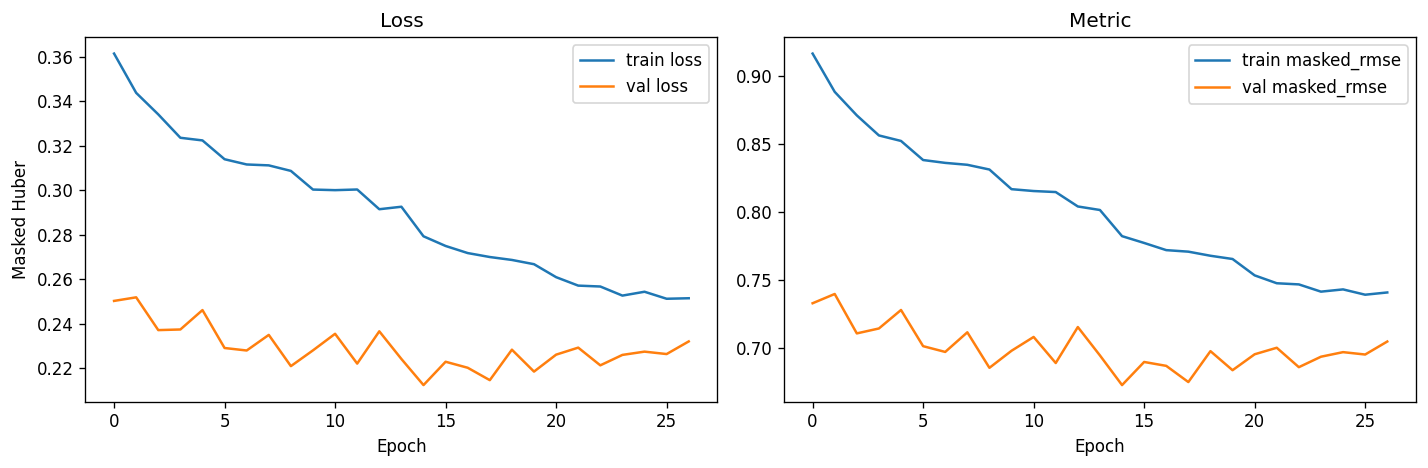

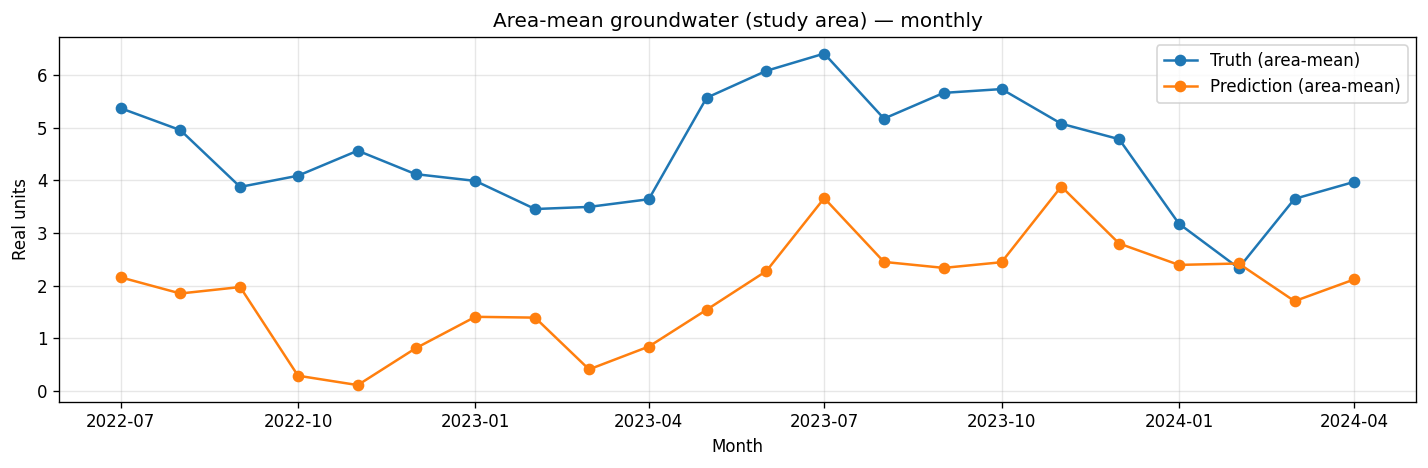

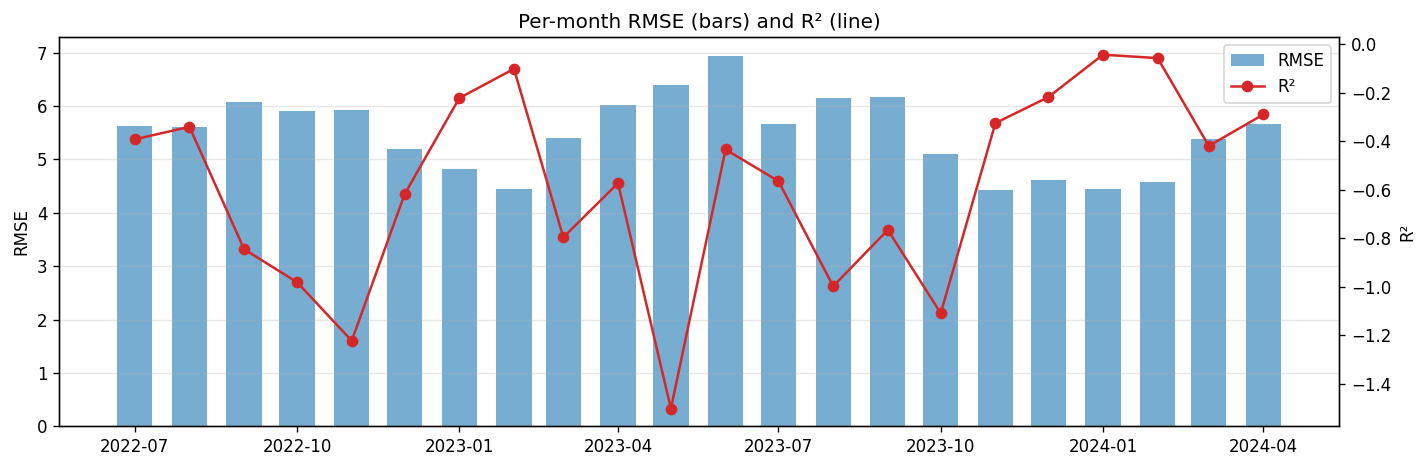

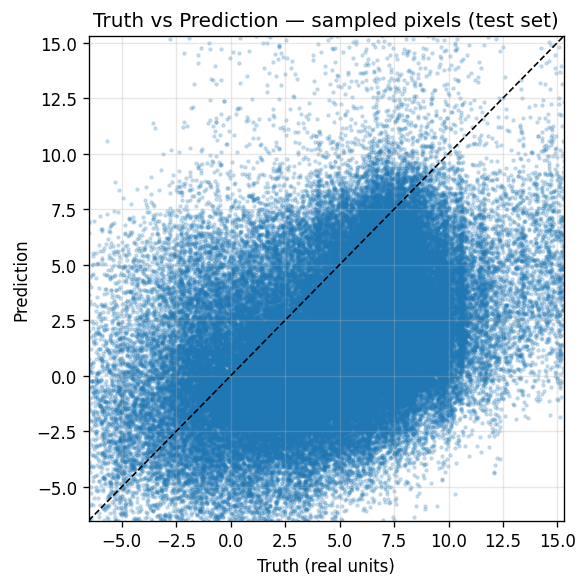

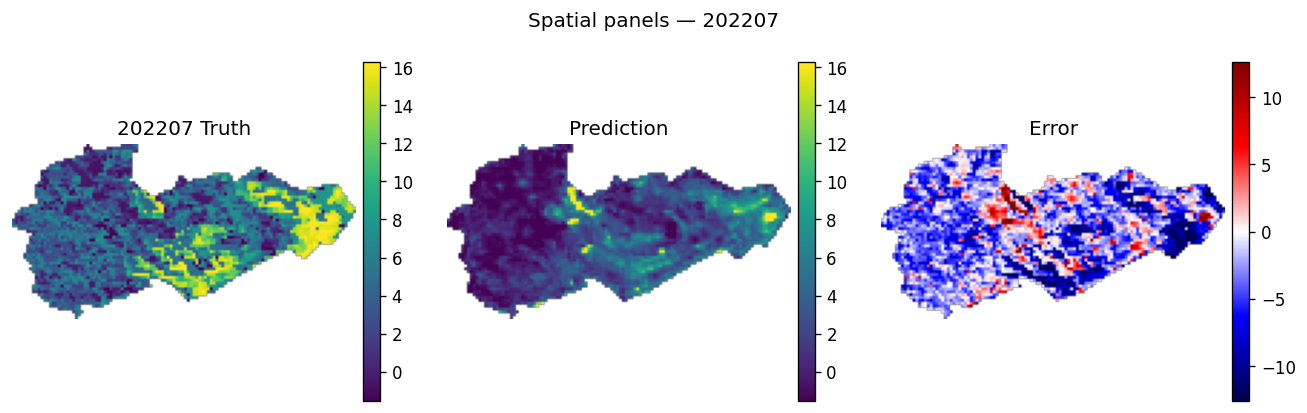

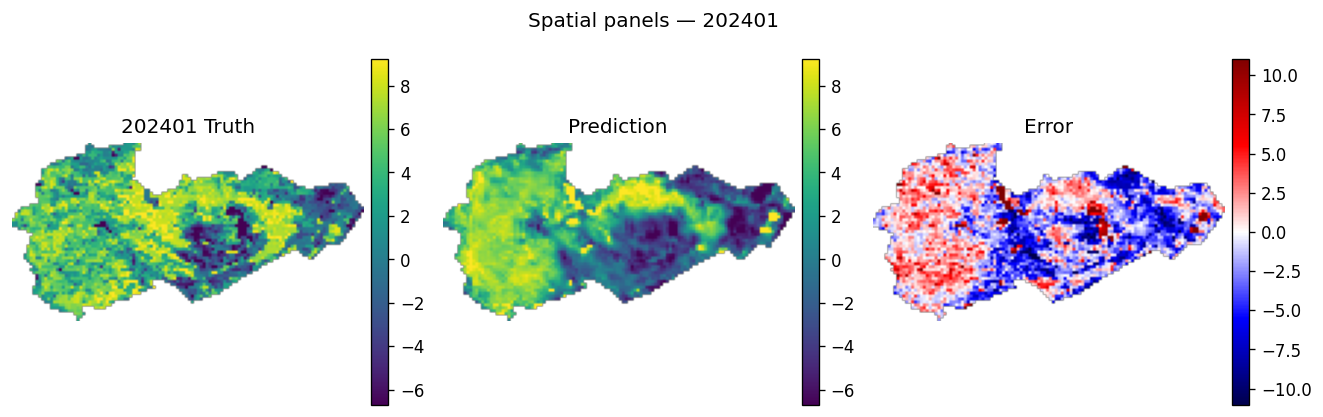

Done.


In [ ]:
# ========= Cell 20 — Post-training analysis & plots =========
import os, json, re, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import Affine

plt.rcParams.update({"figure.dpi": 120})

# --- Basics & paths
pred_dir = os.path.join(PREP_DIR, "predictions_geotiffs")
hist_csv = os.path.join(PREP_DIR, "training_history.csv")
test_idx = os.path.join(PREP_DIR, "test", "index.json")

# --- Load meta & mask
with open(os.path.join(PREP_DIR, "meta.json"), "r") as f:
    META = json.load(f)
H, W = META["H"], META["W"]
SEQ_LEN = META["seq_len"]
y_mean  = META["target_mean"]
y_std   = META["target_std"]
ref_tr  = Affine(*META["ref_transform"])
ref_crs = META["ref_crs"]

mask = np.load(os.path.join(PREP_DIR, "study_mask.npy")).astype(np.float32)  # (H,W), 1 inside study area
inside = mask > 0.5

# --- Load test arrays (ground truth in z) from memmaps
C = len(META["bands_to_use"])
Xte = np.memmap(os.path.join(PREP_DIR, "test", "X.npy"), mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, C)
Yte = np.memmap(os.path.join(PREP_DIR, "test", "Y.npy"), mode="r", dtype=np.float32).reshape(-1, H, W, 2)
N_test = Xte.shape[0]

# --- Resolve test labels (YYYYMM) in order
if os.path.exists(test_idx):
    Y_months_test = json.load(open(test_idx))["Y_months"]
else:
    # Fallback: infer from filenames
    pat = re.compile(r"pred_(\d{6})_convLSTM_nextmonth\.tif$")
    Y_months_test = sorted([
        pat.search(p.name).group(1)
        for p in Path(pred_dir).glob("pred_*.tif")
        if pat.search(p.name)
    ])

assert len(Y_months_test) == N_test, f"Expected {N_test} test months; found {len(Y_months_test)}"

# --- Helper: read a single-band GeoTIFF to (H,W)
def read_tiff(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
    return arr

# --- Compute per-month metrics
def masked_metrics(truth_real, pred_real, m01):
    m = m01 > 0.5
    t = truth_real[m]
    p = pred_real[m]
    if t.size == 0:
        return dict(rmse=np.nan, mae=np.nan, r2=np.nan, bias=np.nan,
                    mean_true=np.nan, mean_pred=np.nan)
    rmse = float(np.sqrt(np.mean((t - p)**2)))
    mae  = float(np.mean(np.abs(t - p)))
    bias = float(np.mean(p - t))
    # R^2 (coefficient of determination) on masked pixels
    tbar = float(np.mean(t))
    ss_tot = float(np.sum((t - tbar)**2))
    ss_res = float(np.sum((t - p)**2))
    r2 = float(1.0 - (ss_res / (ss_tot + 1e-12)))
    return dict(rmse=rmse, mae=mae, r2=r2, bias=bias,
                mean_true=float(np.mean(t)), mean_pred=float(np.mean(p)))

rows = []
for i, ym in enumerate(Y_months_test):
    # Ground truth back to real units
    truth_z = Yte[i, ..., 0]        # z-score
    truth_m = Yte[i, ..., 1]        # valid mask from data prep
    truth_real = truth_z * (y_std + 1e-6) + y_mean
    truth_real = np.where((truth_m > 0.5) & inside, truth_real, np.nan)

    # Prediction (already in real units; your exporter wrote real units)
    tif_path = os.path.join(pred_dir, f"pred_{ym}_convLSTM_nextmonth.tif")
    assert os.path.exists(tif_path), f"Missing {tif_path}"
    pred_real = read_tiff(tif_path)
    pred_real = np.where(inside, pred_real, np.nan)

    met = masked_metrics(truth_real, pred_real, (truth_m * mask))
    met.update(dict(ym=ym))
    rows.append(met)

metrics_df = pd.DataFrame(rows).sort_values("ym").reset_index(drop=True)
metrics_csv = os.path.join(PREP_DIR, "test_metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)
print("Saved per-month metrics ->", metrics_csv)
display(metrics_df.head())

# --- Plot 1: Training curves (loss & metrics)
if os.path.exists(hist_csv):
    hist = pd.read_csv(hist_csv)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(hist["loss"], label="train loss")
    if "val_loss" in hist: ax[0].plot(hist["val_loss"], label="val loss")
    ax[0].set_title("Loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Masked Huber"); ax[0].legend()

    # Try to plot masked_rmse or masked_r2 if present
    mcol = "masked_rmse" if "masked_rmse" in hist else ("compile_metrics" if "compile_metrics" in hist else None)
    if mcol:
        ax[1].plot(hist[mcol], label=f"train {mcol}")
    vcol = f"val_{mcol}" if mcol and f"val_{mcol}" in hist.columns else None
    if vcol:
        ax[1].plot(hist[vcol], label=f"val {mcol}")
    ax[1].set_title("Metric"); ax[1].set_xlabel("Epoch"); ax[1].legend()
    plt.tight_layout()
    plt.show()
else:
    print("training_history.csv not found; skipping curve plot.")

# --- Prepare time axis as pandas Period for pretty plotting
tidx = pd.to_datetime(metrics_df["ym"], format="%Y%m")

# --- Plot 2: Time-series of area-mean truth vs prediction
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(tidx, metrics_df["mean_true"], marker="o", label="Truth (area-mean)")
ax.plot(tidx, metrics_df["mean_pred"], marker="o", label="Prediction (area-mean)")
ax.set_title("Area-mean groundwater (study area) — monthly")
ax.set_xlabel("Month"); ax.set_ylabel("Real units")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()

# --- Plot 3: Monthly RMSE with R² overlay
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.bar(tidx, metrics_df["rmse"], width=20, alpha=0.6, label="RMSE")
ax1.set_ylabel("RMSE")
ax2 = ax1.twinx()
ax2.plot(tidx, metrics_df["r2"], color="tab:red", marker="o", label="R²")
ax2.set_ylabel("R²")
ax1.set_title("Per-month RMSE (bars) and R² (line)")
ax1.grid(True, axis="y", alpha=0.3)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc="upper right")
plt.tight_layout(); plt.show()

# --- Plot 4: Global scatter over all test pixels (sampled)
# WARNING: this can be heavy; sample up to ~100k points
sample_cap = 100_000
all_t, all_p = [], []
for i, ym in enumerate(Y_months_test):
    truth_z = Yte[i, ..., 0]
    truth_m = Yte[i, ..., 1]
    truth_real = truth_z * (y_std + 1e-6) + y_mean
    truth_real = np.where((truth_m > 0.5) & inside, truth_real, np.nan)

    pred_real = read_tiff(os.path.join(pred_dir, f"pred_{ym}_convLSTM_nextmonth.tif"))
    pred_real = np.where(inside, pred_real, np.nan)

    m = np.isfinite(truth_real) & np.isfinite(pred_real)
    t = truth_real[m]; p = pred_real[m]
    if t.size:
        if t.size > sample_cap // len(Y_months_test):
            idx = np.random.choice(t.size, size=sample_cap // len(Y_months_test), replace=False)
            t = t[idx]; p = p[idx]
        all_t.append(t); all_p.append(p)

if all_t:
    t = np.concatenate(all_t); p = np.concatenate(all_p)
    lim_min = np.nanpercentile(np.concatenate([t,p]), 1)
    lim_max = np.nanpercentile(np.concatenate([t,p]), 99)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(t, p, s=3, alpha=0.2)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], "k--", lw=1)
    ax.set_xlim(lim_min, lim_max); ax.set_ylim(lim_min, lim_max)
    ax.set_xlabel("Truth (real units)"); ax.set_ylabel("Prediction")
    ax.set_title("Truth vs Prediction — sampled pixels (test set)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

# --- Plot 5: Spatial maps for a couple of months (truth, pred, error)
def show_spatial(ym_list, vmax_q=98):
    for ym in ym_list:
        # truth
        i = Y_months_test.index(ym)
        tz = Yte[i, ..., 0]
        tm = Yte[i, ..., 1]
        truth = tz * (y_std + 1e-6) + y_mean
        truth = np.where((tm > 0.5) & inside, truth, np.nan)
        # pred
        pred = read_tiff(os.path.join(pred_dir, f"pred_{ym}_convLSTM_nextmonth.tif"))
        pred = np.where(inside, pred, np.nan)
        err = pred - truth

        # scales
        finite_truth = truth[np.isfinite(truth)]
        if finite_truth.size == 0:
            print(f"{ym}: no valid truth pixels, skipping")
            continue
        vmin = np.nanpercentile(finite_truth, 2)
        vmax = np.nanpercentile(finite_truth, vmax_q)
        emax = np.nanpercentile(np.abs(err[np.isfinite(err)]), vmax_q)

        fig, axs = plt.subplots(1,3, figsize=(11,3.5))
        im0 = axs[0].imshow(truth, vmin=vmin, vmax=vmax); axs[0].set_title(f"{ym} Truth"); axs[0].axis("off")
        im1 = axs[1].imshow(pred,  vmin=vmin, vmax=vmax); axs[1].set_title("Prediction"); axs[1].axis("off")
        im2 = axs[2].imshow(err,   vmin=-emax, vmax=emax, cmap="seismic"); axs[2].set_title("Error"); axs[2].axis("off")
        plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.02)
        plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.02)
        plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.02)
        plt.suptitle(f"Spatial panels — {ym}")
        plt.tight_layout(); plt.show()

# Show a couple of representative months (first & best R2 month)
best_idx = int(metrics_df["r2"].idxmax()) if metrics_df["r2"].notna().any() else 0
month_list = [Y_months_test[0], Y_months_test[min(best_idx, len(Y_months_test)-1)]]
show_spatial(month_list)

print("Done.")


Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/per_month_metrics.csv


ym      rmse       mae        r2      bias  mean_true  mean_pred
0  202207  5.632513  4.501609 -0.392240 -3.213088   5.372673   2.159584
1  202208  5.611855  4.647708 -0.340867 -3.103451   4.955736   1.852285
2  202209  6.082572  5.156015 -0.845883 -1.902356   3.877173   1.974818
3  202210  5.905698  4.977116 -0.981746 -3.799142   4.089509   0.290367
4  202211  5.922038  5.119873 -1.223478 -4.453872   4.565803   0.111930

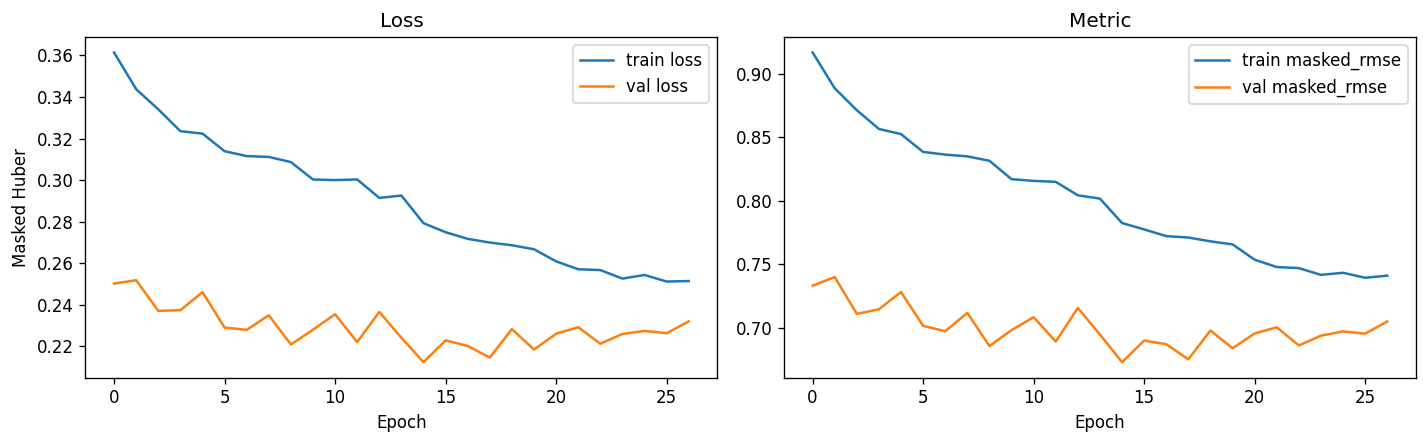

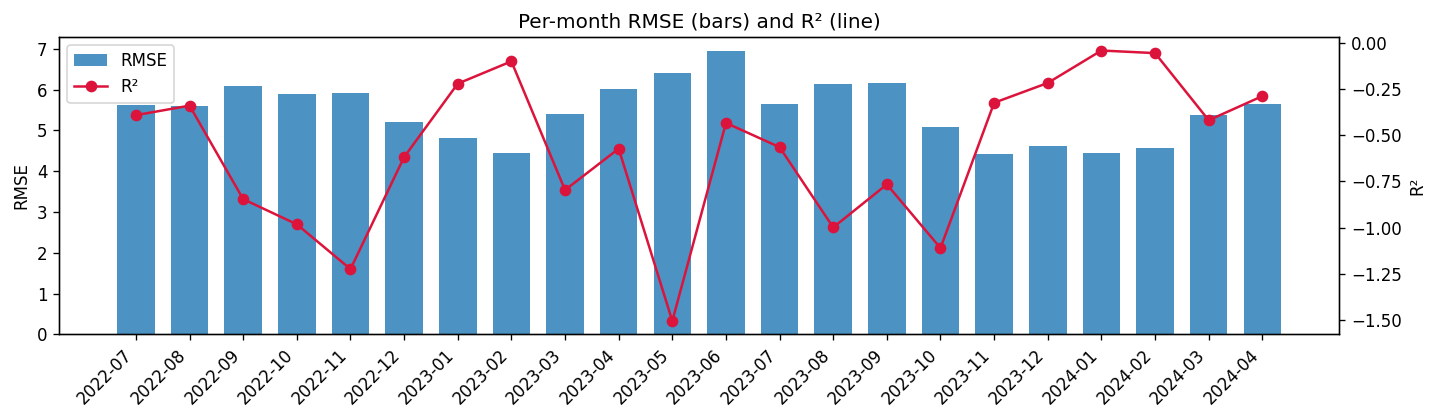

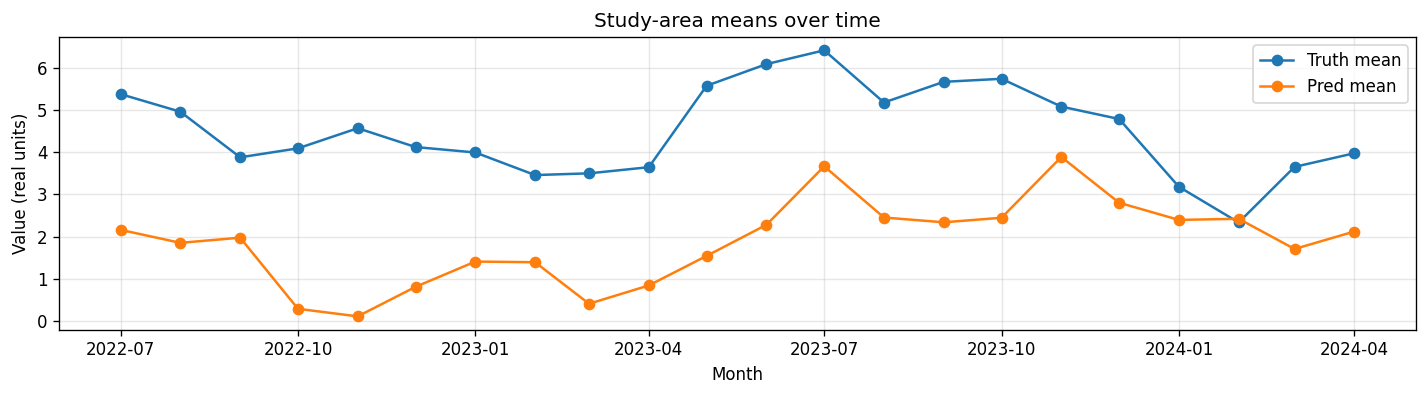

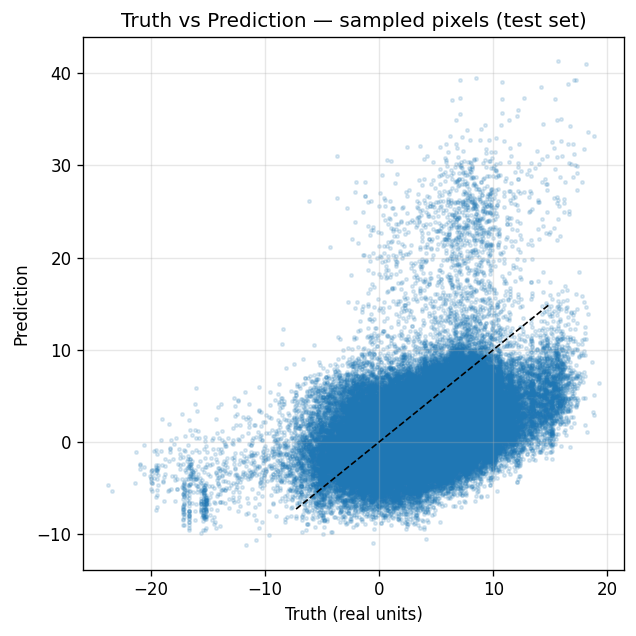

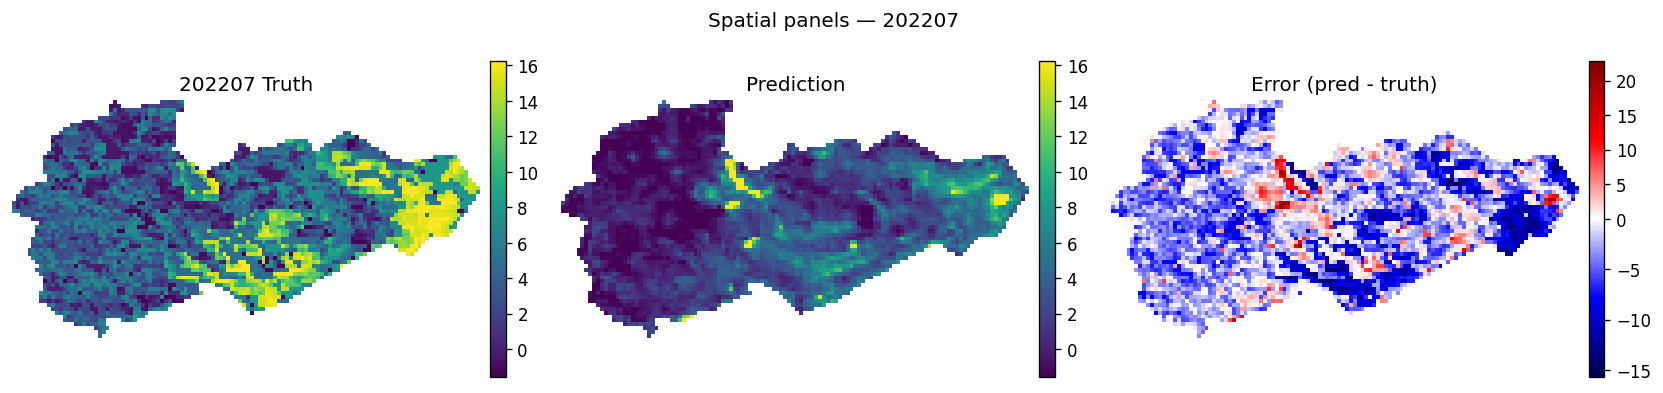

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/spatial_panels_202207.png


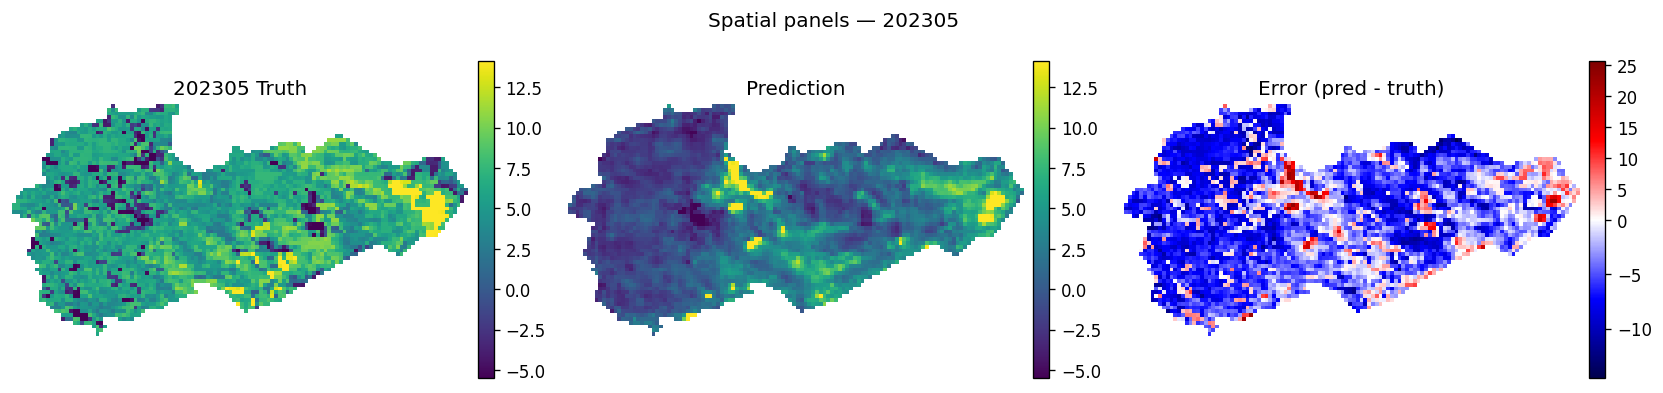

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/spatial_panels_202305.png


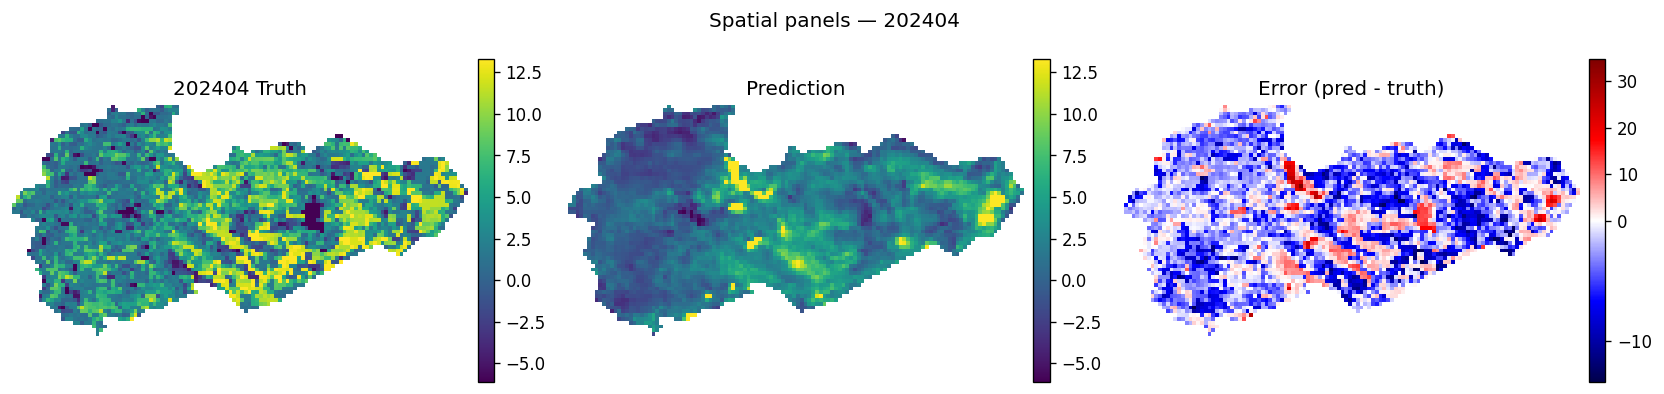

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/spatial_panels_202404.png


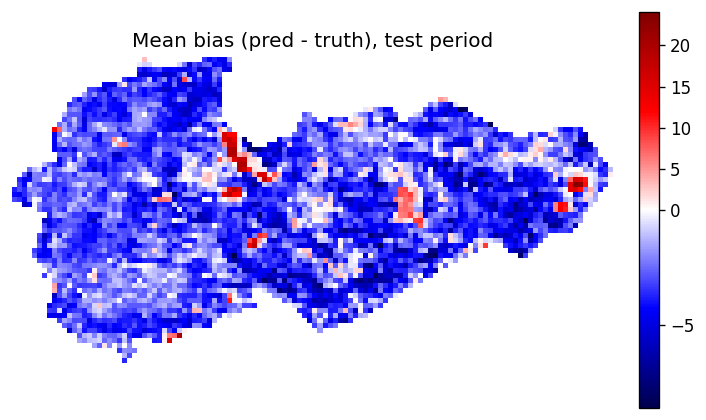

✓ Wrote plots to: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots


In [ ]:
# ========= Cell 20 — Results dashboard: trends, metrics, spatial summaries =========
import os, json, math, numpy as np, matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.colors import TwoSlopeNorm

np.set_printoptions(suppress=True, linewidth=140)

OUT_DIR = os.path.join(PREP_DIR, "analysis_plots")
os.makedirs(OUT_DIR, exist_ok=True)

# --- helpers
def denorm(z):
    return z * (y_std + 1e-6) + y_mean

def r2_score(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if not m.any():
        return np.nan
    yt, yp = y_true[m], y_pred[m]
    ss_res = np.sum((yt - yp)**2)
    ss_tot = np.sum((yt - yt.mean())**2) + 1e-12
    return 1.0 - ss_res/ss_tot

def rmse(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if not m.any(): return np.nan
    return float(np.sqrt(np.mean((y_true[m]-y_pred[m])**2)))

def mae(y_true, y_pred):
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if not m.any(): return np.nan
    return float(np.mean(np.abs(y_true[m]-y_pred[m])))

def to_dates(ym_list):  # 'YYYYMM' -> datetime
    out = []
    for s in ym_list:
        try: out.append(datetime.strptime(s, "%Y%m"))
        except: out.append(datetime.strptime(str(s), "%Y%m"))
    return out

# Resolve test Y-month labels
try:
    idx_path = os.path.join(PREP_DIR, "test", "index.json")
    Y_months_test = json.load(open(idx_path))["Y_months"]
except Exception:
    Y_months_test = [f"test_{i:03d}" for i in range(Xte.shape[0])]
dates = to_dates(Y_months_test)

# Predict all test windows (z space -> real units) and collect truth in real units
pred_real_all = []
true_real_all = []
mask_all      = []

for i in range(Xte.shape[0]):
    pred_z = model.predict(Xte[i:i+1], verbose=0)[0, ..., 0]    # (H,W)
    pred_real = denorm(pred_z)
    y_z  = Yte[i, ..., 0]
    y_m  = Yte[i, ..., 1]
    true_real = denorm(y_z) * (y_m > 0.5)
    pred_real = np.where(y_m > 0.5, pred_real, np.nan)
    pred_real_all.append(pred_real)
    true_real_all.append(true_real)
    mask_all.append(y_m)

pred_real_all = np.stack(pred_real_all)  # (N,H,W)
true_real_all = np.stack(true_real_all)  # (N,H,W)
mask_all      = np.stack(mask_all)       # (N,H,W)

# -------- per-month stats and timeseries --------
rows = []
for i, ym in enumerate(Y_months_test):
    yt = true_real_all[i]; yp = pred_real_all[i]; m = mask_all[i] > 0.5
    rows.append({
        "ym": ym,
        "rmse": rmse(yt[m], yp[m]),
        "mae":  mae(yt[m], yp[m]),
        "r2":   r2_score(yt[m], yp[m]),
        "bias": float(np.nanmean(yp[m] - yt[m])),
        "mean_true": float(np.nanmean(yt[m])),
        "mean_pred": float(np.nanmean(yp[m])),
    })

import pandas as pd
df = pd.DataFrame(rows).sort_values("ym").reset_index(drop=True)
csv_path = os.path.join(OUT_DIR, "per_month_metrics.csv")
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
display(df.head())

# -------- plot 1: Loss & metric curves from history --------
hist_df = pd.DataFrame(history.history)
fig, ax = plt.subplots(1,2, figsize=(12,3.8))
ax[0].plot(hist_df["loss"], label="train loss")
ax[0].plot(hist_df["val_loss"], label="val loss")
ax[0].set_title("Loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Masked Huber"); ax[0].legend()

if "masked_rmse" in hist_df and "val_masked_rmse" in hist_df:
    ax[1].plot(hist_df["masked_rmse"], label="train masked_rmse")
    ax[1].plot(hist_df["val_masked_rmse"], label="val masked_rmse")
    ax[1].set_title("Metric"); ax[1].set_xlabel("Epoch"); ax[1].legend()
else:
    ax[1].axis("off")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "loss_metric_curves.png"), dpi=160)
plt.show()

# -------- plot 2: Per-month RMSE (bars) + R2 (line) --------
fig, ax1 = plt.subplots(1,1, figsize=(12,3.6))
x = np.arange(len(df))
ax1.bar(x, df["rmse"].values, width=0.7, alpha=0.8, label="RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xticks(x)
ax1.set_xticklabels([d.strftime("%Y-%m") for d in dates], rotation=45, ha="right")
ax2 = ax1.twinx()
ax2.plot(x, df["r2"].values, "o-", color="crimson", label="R²")
ax2.set_ylabel("R²")
ax1.set_title("Per-month RMSE (bars) and R² (line)")
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper left")
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "per_month_rmse_r2.png"), dpi=160)
plt.show()

# -------- plot 3: Study-area means over time (truth vs pred) --------
fig = plt.figure(figsize=(12,3.4))
plt.plot(dates, [np.nanmean(true_real_all[i][mask_all[i]>0.5]) for i in range(len(dates))], "o-", label="Truth mean")
plt.plot(dates, [np.nanmean(pred_real_all[i][mask_all[i]>0.5]) for i in range(len(dates))], "o-", label="Pred mean")
plt.grid(alpha=0.3); plt.legend(); plt.title("Study-area means over time")
plt.xlabel("Month"); plt.ylabel("Value (real units)")
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "means_over_time.png"), dpi=160)
plt.show()

# -------- plot 4: Pixel scatter (sampled) --------
rng = np.random.default_rng(42)
sample = []
for i in range(pred_real_all.shape[0]):
    m = mask_all[i] > 0.5
    yt = true_real_all[i][m]; yp = pred_real_all[i][m]
    if yt.size:
        idx = rng.choice(yt.size, size=min(12000, yt.size), replace=False)
        sample.append(np.stack([yt[idx], yp[idx]], axis=1))
sample = np.concatenate(sample, axis=0)
fig = plt.figure(figsize=(5.4,5.4))
plt.scatter(sample[:,0], sample[:,1], s=4, alpha=0.15)
lims = [np.nanpercentile(sample[:,0], 1), np.nanpercentile(sample[:,0], 99)]
plt.plot(lims, lims, "k--", linewidth=1)
plt.xlabel("Truth (real units)"); plt.ylabel("Prediction")
plt.title("Truth vs Prediction — sampled pixels (test set)")
plt.grid(alpha=0.3); plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "scatter_truth_vs_pred.png"), dpi=160)
plt.show()

# -------- plot 5: Spatial panels for a few months --------
def spatial_panels(i, vmin=None, vmax=None):
    yt = true_real_all[i]; yp = pred_real_all[i]; m = mask_all[i]>0.5
    err = np.where(m, yp-yt, np.nan)
    if vmin is None or vmax is None:
        inside = yt[m]
        vmin = np.nanpercentile(inside, 2)
        vmax = np.nanpercentile(inside, 98)
    fig, axes = plt.subplots(1,3, figsize=(14,3.3))
    im0 = axes[0].imshow(np.where(m, yt, np.nan), vmin=vmin, vmax=vmax, cmap="viridis"); axes[0].set_title(f"{Y_months_test[i]} Truth"); axes[0].axis("off"); fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.02)
    im1 = axes[1].imshow(np.where(m, yp, np.nan), vmin=vmin, vmax=vmax, cmap="viridis"); axes[1].set_title("Prediction"); axes[1].axis("off"); fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.02)
    im2 = axes[2].imshow(err, cmap="seismic", norm=TwoSlopeNorm(vcenter=0.0)); axes[2].set_title("Error (pred - truth)"); axes[2].axis("off"); fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.02)
    fig.suptitle(f"Spatial panels — {Y_months_test[i]}"); fig.tight_layout()
    path = os.path.join(OUT_DIR, f"spatial_panels_{Y_months_test[i]}.png")
    fig.savefig(path, dpi=160); plt.show()
    print("Saved:", path)

for idx in [0, max(0, len(Y_months_test)//2 - 1), len(Y_months_test)-1]:
    spatial_panels(idx)

# -------- plot 6: Time-mean bias map over the whole test set --------
bias_map = np.nanmean(pred_real_all - true_real_all, axis=0)
fig = plt.figure(figsize=(6,3.6))
im = plt.imshow(bias_map, cmap="seismic", norm=TwoSlopeNorm(vcenter=0.0))
plt.title("Mean bias (pred - truth), test period"); plt.axis("off")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "bias_map_test_mean.png"), dpi=160)
plt.show()

print("✓ Wrote plots to:", OUT_DIR)


# **Cell 21 — Area-average monthly time series & trends (2004-04 → 2024-04)**

processing split: train
processing split: val
processing split: test
Months in window: 177
Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/figs/area_timeseries_200404_202404.csv


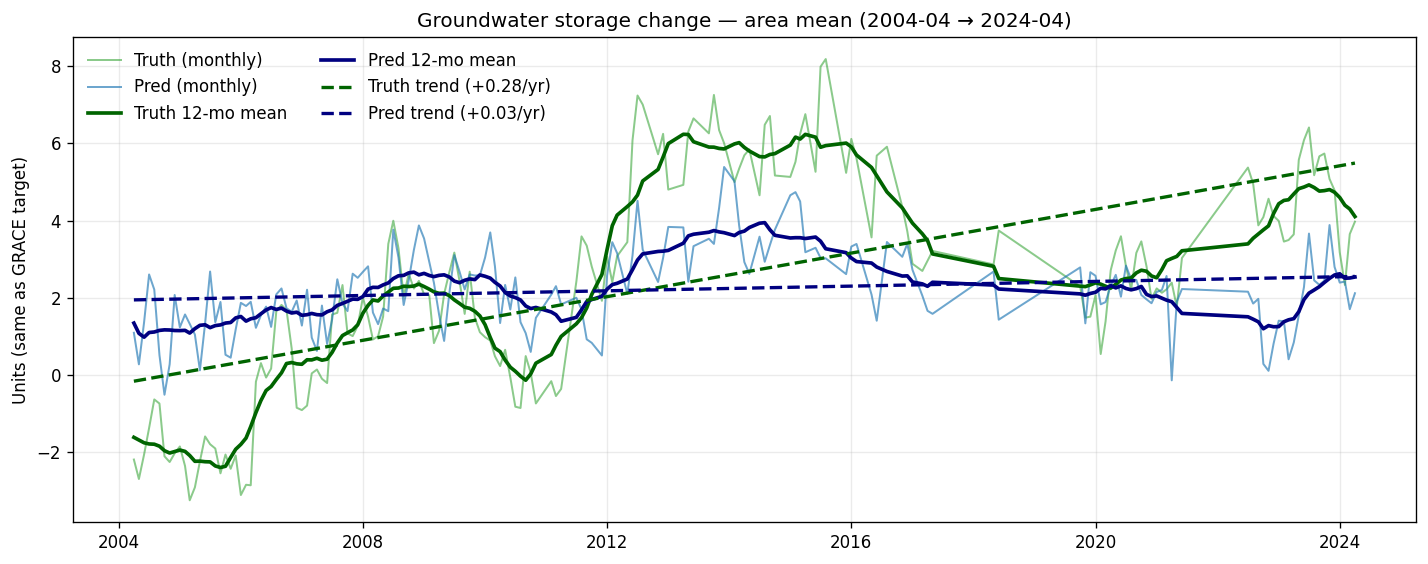

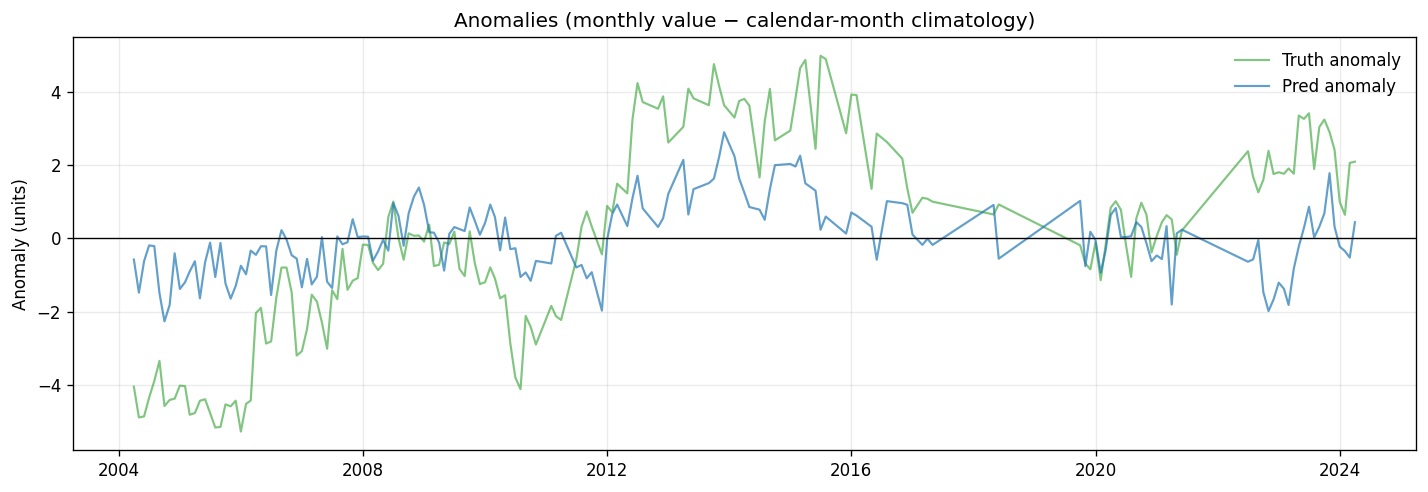

In [ ]:
import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# --- load meta & mask
with open(os.path.join(PREP_DIR, "meta.json")) as f:
    META = json.load(f)
H, W        = META["H"], META["W"]
y_mean      = META["target_mean"]
y_std       = META["target_std"]

mask = np.load(os.path.join(PREP_DIR, "study_mask.npy")).astype(np.float32)  # (H,W)
mvec = mask.reshape(-1) > 0.5

def _load_split_arrays(split):
    """Return arrays and Y_month labels for a split."""
    Xp = os.path.join(PREP_DIR, split, "X.npy")
    Yp = os.path.join(PREP_DIR, split, "Y.npy")
    idxp = os.path.join(PREP_DIR, split, "index.json")
    C = len(META["bands_to_use"])
    X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, META["seq_len"], H, W, C)
    Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)
    months = json.load(open(idxp))["Y_months"] if os.path.exists(idxp) else [f"{split}_{i:03d}" for i in range(len(X))]
    return np.array(X), np.array(Y), months

def _predict_split(split, batch_size=2):
    """Run model; return dict of per-sample area means/stds."""
    X, Y, months = _load_split_arrays(split)
    # predict z-score -> back to real units
    pred_z = model.predict(X, batch_size=batch_size, verbose=0)[..., 0]       # (N,H,W)
    pred   = pred_z * (y_std + 1e-6) + y_mean                                 # real units
    true   = Y[..., 0] * (y_std + 1e-6) + y_mean
    msk    = (Y[..., 1] * mask)                                                # (N,H,W)
    rows = []
    for i, ym in enumerate(months):
        mm  = msk[i].reshape(-1) > 0.5
        if not mm.any():
            continue
        p_i = pred[i].reshape(-1)[mm]
        t_i = true[i].reshape(-1)[mm]
        rows.append(dict(
            ym=ym,
            pred_mu=float(np.mean(p_i)),
            pred_sd=float(np.std(p_i)),
            true_mu=float(np.mean(t_i)),
            true_sd=float(np.std(t_i)),
            n=int(mm.sum())
        ))
    return pd.DataFrame(rows)

def _ym_to_dt(ym):
    # ym like "YYYYMM" -> datetime at month start
    return datetime(int(ym[:4]), int(ym[4:]), 1)

# --- gather all splits, de-duplicate by month (keep first or average — we average if duplicated) ---
dfs = []
for split in ["train","val","test"]:
    if os.path.exists(os.path.join(PREP_DIR, split, "X.npy")):
        print(f"processing split: {split}")
        dfs.append(_predict_split(split, batch_size=4))
if not dfs:
    raise RuntimeError("No split arrays found. Ensure you've run data prep & training first.")

ts = pd.concat(dfs, ignore_index=True)
# if duplicates for same ym exist (e.g., overlapping windows across splits), average them
ts = ts.groupby("ym", as_index=False).agg({
    "pred_mu":"mean","pred_sd":"mean","true_mu":"mean","true_sd":"mean","n":"max"
})
ts["date"] = ts["ym"].apply(_ym_to_dt)
ts = ts.sort_values("date")

# --- restrict to requested window ---
START, END = datetime(2004,4,1), datetime(2024,4,1)
mask_window = (ts["date"]>=START) & (ts["date"]<=END)
tsw = ts.loc[mask_window].reset_index(drop=True)
print("Months in window:", len(tsw))

# --- 12-month rolling mean (centered; min_periods to avoid NaNs at edges) ---
tsw["pred_roll12"] = tsw["pred_mu"].rolling(12, min_periods=3, center=True).mean()
tsw["true_roll12"] = tsw["true_mu"].rolling(12, min_periods=3, center=True).mean()

# --- simple linear trend with ordinary least squares (slope in units/year) ---
# time coordinate in fractional years
t_years = tsw["date"].apply(lambda d: d.year + (d.month-0.5)/12.0).to_numpy()
x = t_years - t_years.mean()
def lin_trend(y):
    y = y.to_numpy()
    b1 = np.sum(x*(y - y.mean())) / (np.sum(x*x) + 1e-12)      # slope per year
    b0 = y.mean() - b1 * x.mean()
    return b0, b1
b0_p, slope_p = lin_trend(tsw["pred_mu"])
b0_t, slope_t = lin_trend(tsw["true_mu"])

# --- plot: monthly series + rolling + trend ---
fig, ax = plt.subplots(figsize=(12,4.8))
ax.plot(tsw["date"], tsw["true_mu"], color="tab:green", alpha=0.55, lw=1.2, label="Truth (monthly)")
ax.plot(tsw["date"], tsw["pred_mu"], color="tab:blue",  alpha=0.65, lw=1.2, label="Pred (monthly)")

# rolling means
ax.plot(tsw["date"], tsw["true_roll12"], color="darkgreen", lw=2.2, label="Truth 12-mo mean")
ax.plot(tsw["date"], tsw["pred_roll12"], color="navy",      lw=2.2, label="Pred 12-mo mean")

# trends
ax.plot(tsw["date"], b0_t + slope_t*(t_years - t_years.mean()), "--", color="darkgreen",
        lw=2, label=f"Truth trend ({slope_t:+.2f}/yr)")
ax.plot(tsw["date"], b0_p + slope_p*(t_years - t_years.mean()), "--", color="navy",
        lw=2, label=f"Pred trend ({slope_p:+.2f}/yr)")

ax.set_title("Groundwater storage change — area mean (2004-04 → 2024-04)")
ax.set_ylabel("Units (same as GRACE target)")
ax.grid(True, alpha=0.25)
ax.legend(ncol=2, frameon=False)
plt.tight_layout()

# --- optional: anomaly view (remove monthly climatology) ---
# Monthly climatology by calendar month using Truth baseline (pred uses its own)
tsw["mon"] = tsw["date"].dt.month
clim_true = tsw.groupby("mon")["true_mu"].mean()
clim_pred = tsw.groupby("mon")["pred_mu"].mean()
tsw["true_anom"] = tsw.apply(lambda r: r["true_mu"] - clim_true[r["mon"]], axis=1)
tsw["pred_anom"] = tsw.apply(lambda r: r["pred_mu"] - clim_pred[r["mon"]], axis=1)

fig2, ax2 = plt.subplots(figsize=(12,4.2))
ax2.plot(tsw["date"], tsw["true_anom"], color="tab:green", alpha=0.6, lw=1.3, label="Truth anomaly")
ax2.plot(tsw["date"], tsw["pred_anom"], color="tab:blue",  alpha=0.7, lw=1.3, label="Pred anomaly")
ax2.axhline(0, color="k", lw=0.8)
ax2.set_title("Anomalies (monthly value − calendar-month climatology)")
ax2.set_ylabel("Anomaly (units)")
ax2.grid(True, alpha=0.25); ax2.legend(frameon=False)
plt.tight_layout()

# --- save tidy CSV for your paper/plots ---
out_dir = os.path.join(PREP_DIR, "figs")
Path(out_dir).mkdir(parents=True, exist_ok=True)
csv_path = os.path.join(out_dir, "area_timeseries_200404_202404.csv")
tsw[["date","ym","true_mu","true_sd","pred_mu","pred_sd","n",
     "true_roll12","pred_roll12","true_anom","pred_anom"]].to_csv(csv_path, index=False)
print("Saved:", csv_path)


# **Cell 22 — Feature importance & attribution (bands, time, IG)**

Sampling validation batches...
Val slice: (12, 12, 61, 120, 9)
Baseline masked RMSE (val slice): 0.7255


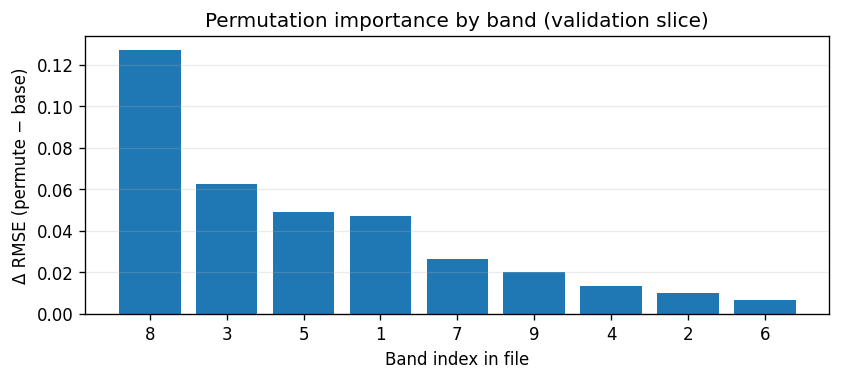

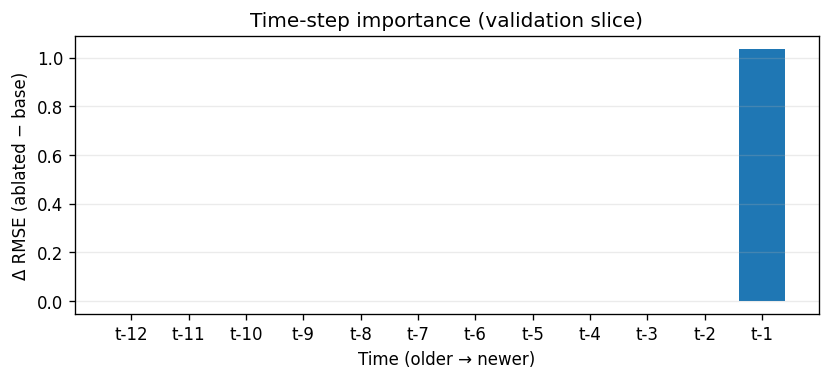

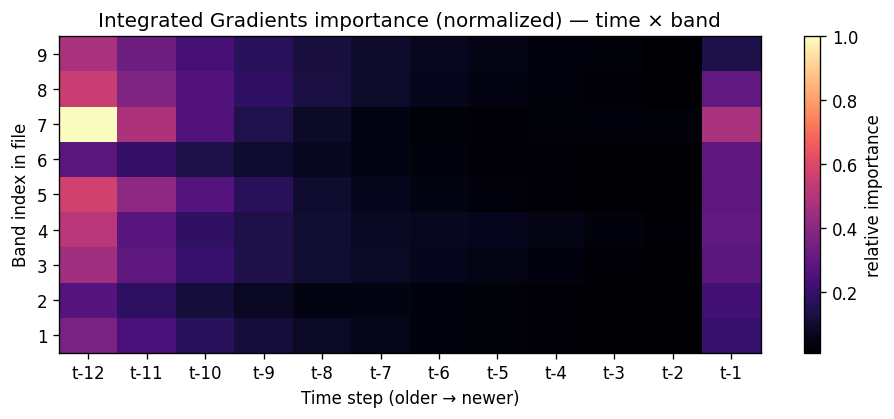

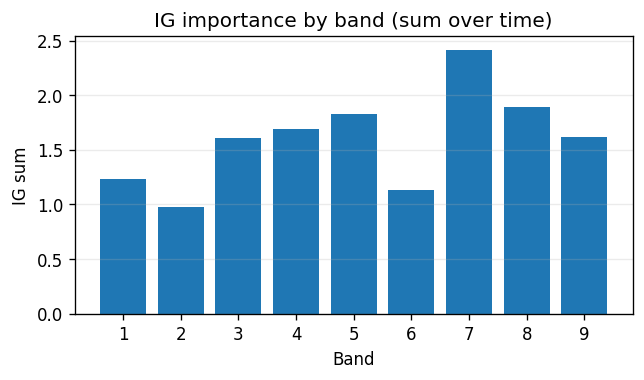

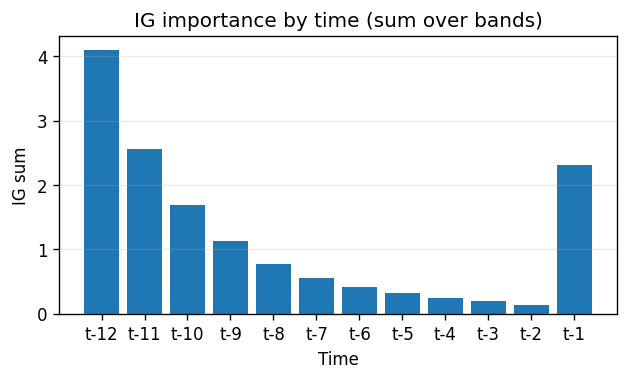

In [ ]:
#Cell 22 — Feature importance & attribution (bands, time, IG)
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, itertools, time

# ---------- helpers ----------
def denorm_target(z):  # z -> real units
    return z * (y_std + 1e-6) + y_mean

def masked_rmse_np(y_true, y_pred, eps=1e-6):
    """
    y_true: (H,W,2) [z, mask] or (N,H,W,2)
    y_pred: (H,W)   z-pred     or (N,H,W)
    """
    if y_true.ndim == 3:
        yt, m = y_true[...,0], y_true[...,1]
        se = (yt - y_pred)**2 * m
        return float(np.sqrt(se.sum() / (m.sum() + eps)))
    else:
        yt, m = y_true[...,0], y_true[...,1]
        se = ((yt - y_pred)**2 * m).sum(axis=(1,2))
        denom = m.sum(axis=(1,2)) + eps
        return float(np.sqrt((se/denom).mean()))

# Pull a manageable slice of the validation set for speed
def collect_val_batches(dataset, max_batches=6):
    xs, ys = [], []
    it = iter(dataset)
    for _ in range(max_batches):
        try:
            bx, by = next(it)
        except StopIteration:
            break
        xs.append(bx.numpy())
        ys.append(by.numpy())
    if not xs:
        raise RuntimeError("val_ds appears empty.")
    X = np.concatenate(xs, axis=0)
    Y = np.concatenate(ys, axis=0)
    return X, Y

print("Sampling validation batches...")
Xv, Yv = collect_val_batches(val_ds, max_batches=6)  # tune if you want faster/slower
B, T, Hh, Ww, C = Xv.shape
print("Val slice:", Xv.shape)

# Baseline predictions / metric on the slice
pred0_z = model.predict(Xv, verbose=0)[...,0]                 # (B,H,W)
base_rmse = masked_rmse_np(Yv, pred0_z)
print(f"Baseline masked RMSE (val slice): {base_rmse:.4f}")

# ---------- (A) Band permutation importance ----------
rng = np.random.default_rng(123)

def permute_band_inplace(x, band_idx):
    """
    x: (B,T,H,W,C) view (modified in place)
    Shuffle pixels of the chosen band within the spatial grid (independently per t,batch).
    Keeps distribution but breaks spatial info for that band.
    """
    B,T,H,W,C = x.shape
    flatN = H*W
    for b in range(B):
        for t in range(T):
            v = x[b, t, ..., band_idx].reshape(-1)
            rng.shuffle(v)
            x[b, t, ..., band_idx] = v.reshape(H, W)

band_scores = []
for j, band in enumerate(BANDS_TO_USE):
    Xp = Xv.copy()
    permute_band_inplace(Xp, j)
    pj = model.predict(Xp, verbose=0)[...,0]
    rmse_j = masked_rmse_np(Yv, pj)
    band_scores.append((j, band, rmse_j - base_rmse))
band_scores.sort(key=lambda z: z[2], reverse=True)  # higher delta = more important

plt.figure(figsize=(8,3))
plt.bar([str(b) for (_,b,_) in band_scores], [d for *_, d in band_scores])
plt.ylabel("Δ RMSE (permute − base)"); plt.xlabel("Band index in file")
plt.title("Permutation importance by band (validation slice)")
plt.grid(axis='y', alpha=0.25)
plt.show()

# ---------- (B) Time-step ablation importance ----------
def zero_timestep_inplace(x, t_idx):
    x[:, t_idx, ...] = 0.0

time_scores = []
for t in range(SEQ_LEN):
    Xt = Xv.copy()
    zero_timestep_inplace(Xt, t)
    pt = model.predict(Xt, verbose=0)[...,0]
    rmse_t = masked_rmse_np(Yv, pt)
    time_scores.append((t, rmse_t - base_rmse))

plt.figure(figsize=(8,3))
plt.bar([f"t-{SEQ_LEN-t}" for t,_ in time_scores], [d for _,d in time_scores])
plt.ylabel("Δ RMSE (ablated − base)"); plt.xlabel("Time (older → newer)")
plt.title("Time-step importance (validation slice)")
plt.grid(axis='y', alpha=0.25)
plt.show()

# ---------- (C) Integrated Gradients (IG) to (time × band) heatmap ----------
@tf.function
def _forward(x):
    return model(x, training=False)[...,0]  # (B,H,W)

def integrated_gradients(x, baseline, steps=24):
    """
    x: (B,T,H,W,C) one or more samples
    baseline: same shape (often zeros)
    returns IG tensor same shape as x (attributions in z-space)
    """
    alphas = tf.linspace(0.0, 1.0, steps)
    ig = tf.zeros_like(x, dtype=tf.float32)
    for a in alphas:
        x_interp = baseline + a * (x - baseline)
        with tf.GradientTape() as tape:
            tape.watch(x_interp)
            ypred = _forward(x_interp)                       # (B,H,W)
            # Focus gradients inside study area: average over masked pixels
            m = tf.convert_to_tensor(mask, dtype=tf.float32)[None,...]  # (1,H,W)
            target = tf.reduce_sum(ypred * m, axis=[1,2]) / (tf.reduce_sum(m) + 1e-6)  # (B,)
            obj = tf.reduce_mean(target)
        grads = tape.gradient(obj, x_interp)                 # (B,T,H,W,C)
        ig += grads
    ig = (x - baseline) * ig / tf.cast(steps, tf.float32)
    return ig

# Use a small batch for IG (keeps it snappy)
IG_B = min(4, Xv.shape[0])
xb = Xv[:IG_B]
base = np.zeros_like(xb, dtype=np.float32)
ig = integrated_gradients(tf.convert_to_tensor(xb), tf.convert_to_tensor(base), steps=24).numpy()  # (B,T,H,W,C)

# Aggregate IG to (time, band): sum |IG| over space and batch
ig_tb = np.abs(ig).sum(axis=(0,2,3))  # (T,C)
# Normalize for display
ig_tb_norm = ig_tb / (ig_tb.max() + 1e-12)

plt.figure(figsize=(8, 3.6))
plt.imshow(ig_tb_norm.T, aspect='auto', origin='lower', cmap='magma')
plt.yticks(range(C), [f"{b}" for b in BANDS_TO_USE])
plt.xticks(range(T), [f"t-{SEQ_LEN-k}" for k in range(T)])
plt.xlabel("Time step (older → newer)"); plt.ylabel("Band index in file")
plt.title("Integrated Gradients importance (normalized) — time × band")
plt.colorbar(label="relative importance")
plt.tight_layout()
plt.show()

# Also collapse IG by band and by time for quick bar plots
plt.figure(figsize=(6,3))
plt.bar([str(b) for b in BANDS_TO_USE], ig_tb.sum(axis=0))
plt.title("IG importance by band (sum over time)"); plt.xlabel("Band"); plt.ylabel("IG sum")
plt.grid(axis='y', alpha=0.25); plt.show()

plt.figure(figsize=(6,3))
plt.bar([f"t-{SEQ_LEN-k}" for k in range(T)], ig_tb.sum(axis=1))
plt.title("IG importance by time (sum over bands)"); plt.xlabel("Time"); plt.ylabel("IG sum")
plt.grid(axis='y', alpha=0.25); plt.show()


Season counts: {'DJF': 6, 'MAM': 5, 'JJA': 5, 'SON': 6}


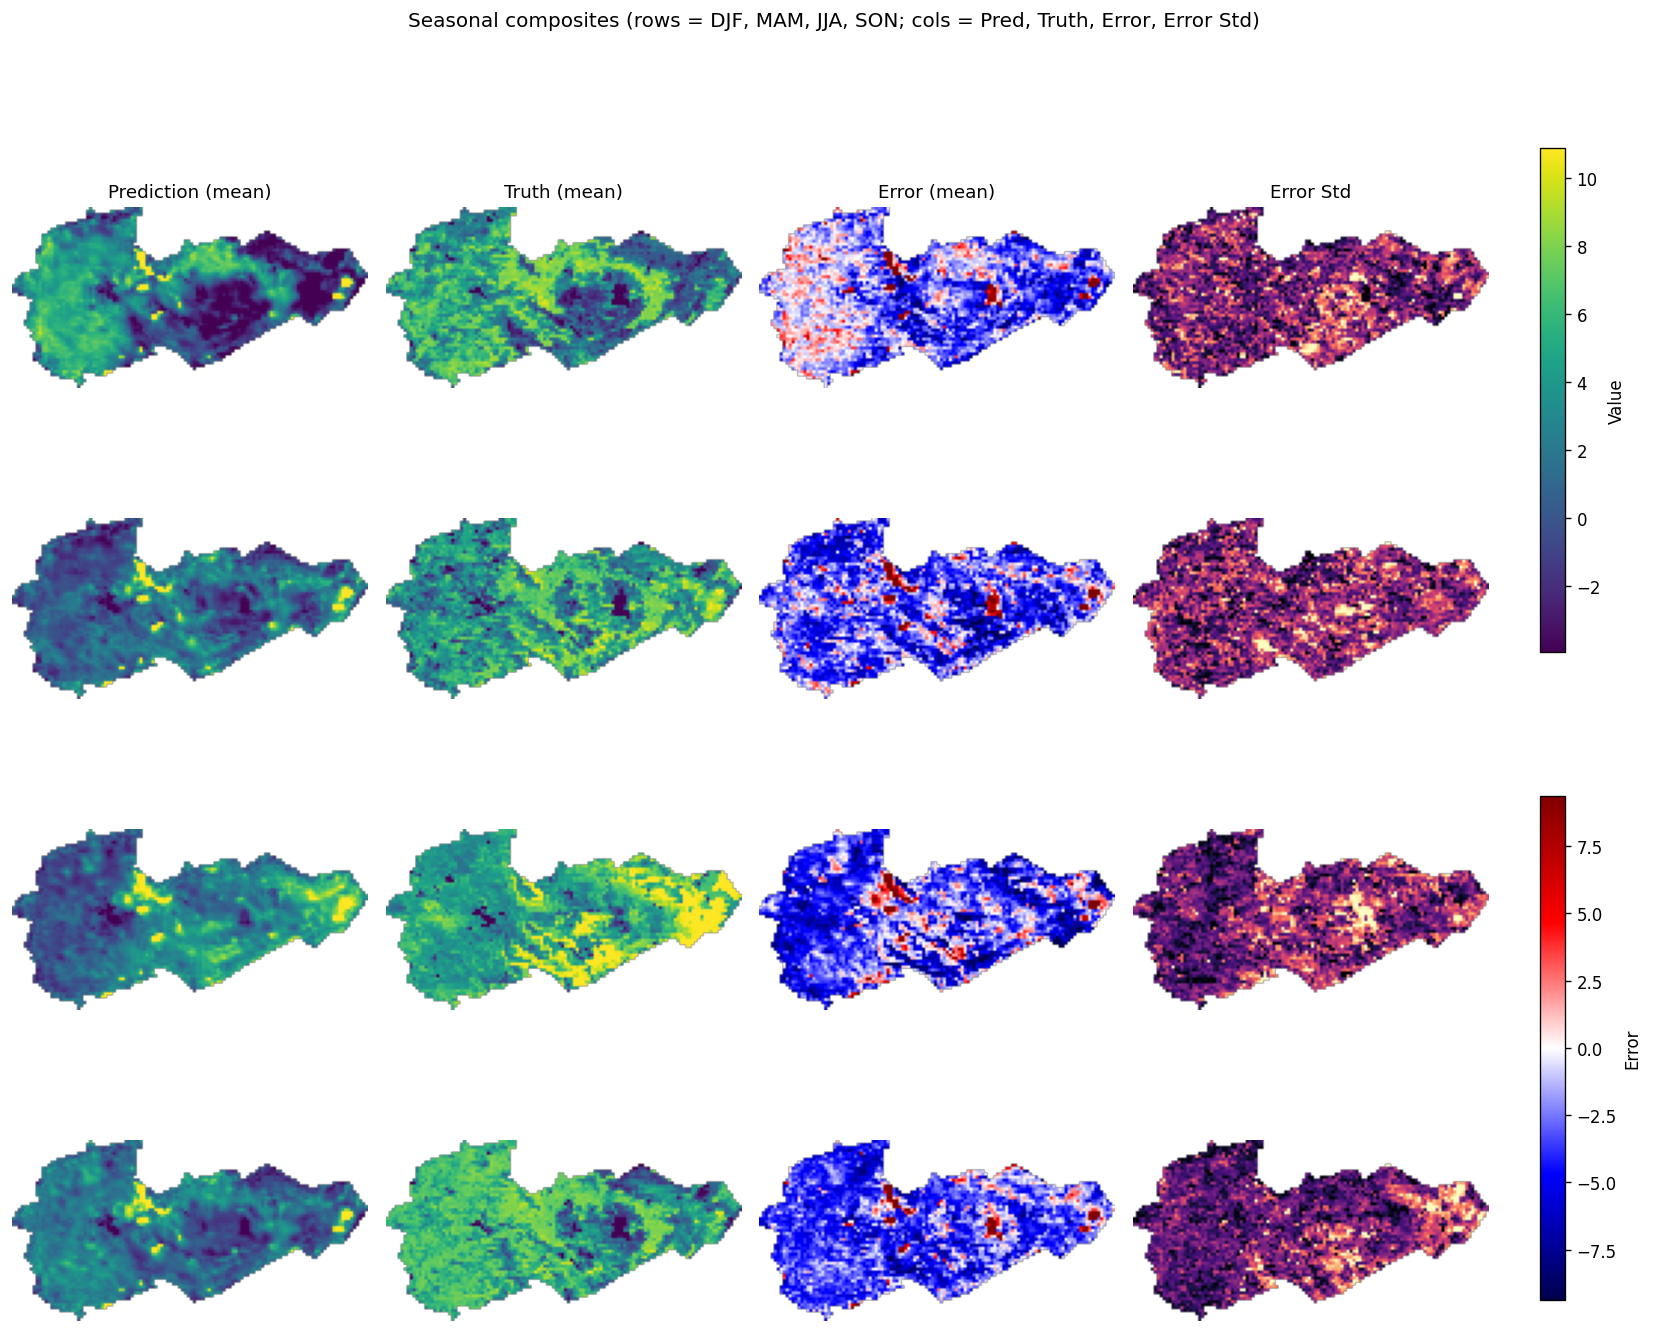

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/seasonal_annual_maps_v2/seasonal_4x4_panel.png
Years present in predictions: [2022, 2023, 2024]


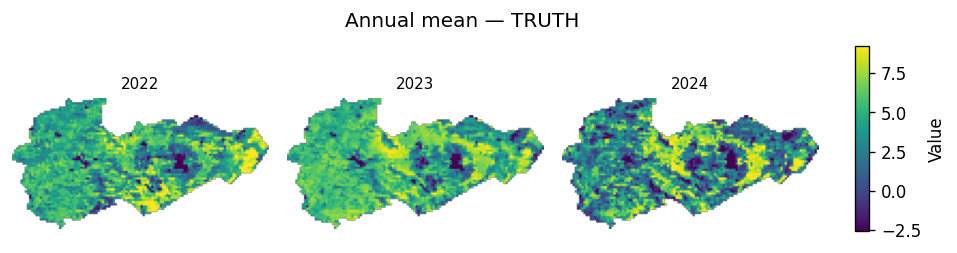

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/seasonal_annual_maps_v2/annual_truth_mean.png


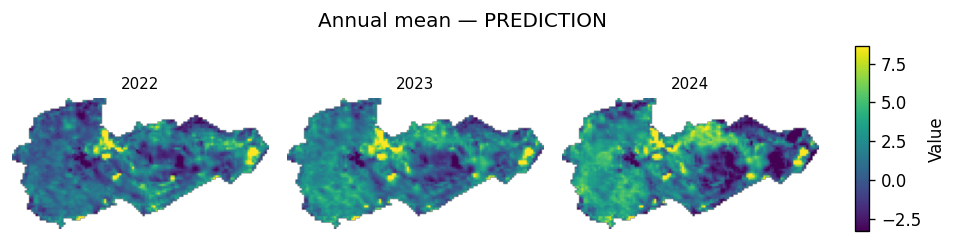

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/seasonal_annual_maps_v2/annual_pred_mean.png


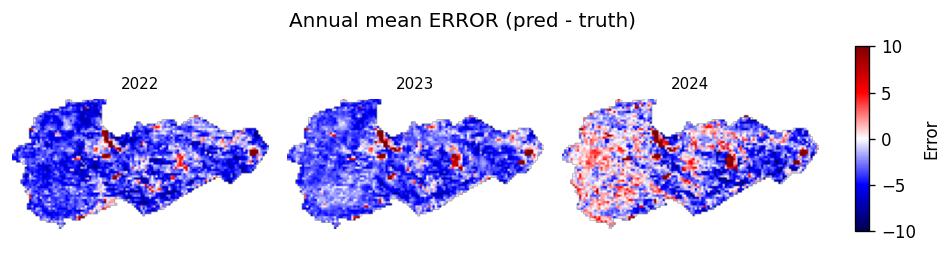

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/seasonal_annual_maps_v2/annual_error_mean.png


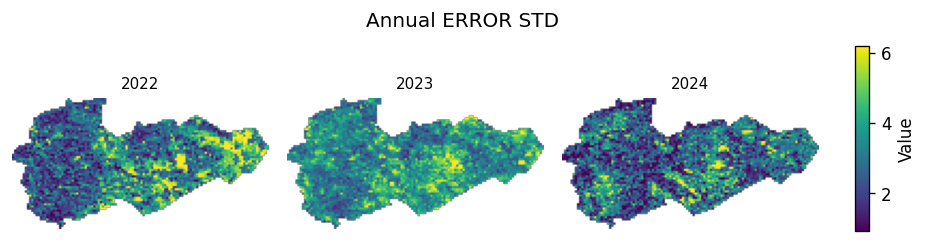

Saved: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/seasonal_annual_maps_v2/annual_error_std.png
✓ Wrote seasonal 4×4 and compact annual grids to: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/analysis_plots/seasonal_annual_maps_v2


In [ ]:
# ========= Cell 21b — Seasonal 4×4 + Annual grids (compact, bug-fixed) =========
import os, math, numpy as np, matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable

SEASON_DIR = os.path.join(OUT_DIR if 'OUT_DIR' in globals() else PREP_DIR, "seasonal_annual_maps_v2")
os.makedirs(SEASON_DIR, exist_ok=True)

# ---- require these from earlier cells
assert all(n in globals() for n in ["pred_real_all","true_real_all","mask_all","Y_months_test"]), \
    "Missing arrays (pred_real_all, true_real_all, mask_all, Y_months_test). Run the prediction-assembly cell first."

# ---------------- helpers ----------------
def ym_to_dt(ym):  # 'YYYYMM' -> datetime
    return datetime.strptime(str(ym), "%Y%m")

def masked_mean(stack, mask):
    data = np.where(mask>0.5, stack, np.nan)
    return np.nanmean(data, axis=0)

def masked_std(stack, mask):
    data = np.where(mask>0.5, stack, np.nan)
    return np.nanstd(data, axis=0)

def robust_limits(mats, masks, lo=2, hi=98):
    vals = []
    for a, m in zip(mats, masks):
        vv = a[(m>0.5) & np.isfinite(a)]
        if vv.size: vals.append(vv)
    if not vals:
        return (np.nanmin([np.nanmin(a) for a in mats]),
                np.nanmax([np.nanmax(a) for a in mats]))
    allv = np.concatenate(vals)
    return float(np.nanpercentile(allv, lo)), float(np.nanpercentile(allv, hi))

# -------------- seasonal indices --------------
SEAS_MAP = {12:"DJF", 1:"DJF", 2:"DJF",
            3:"MAM", 4:"MAM", 5:"MAM",
            6:"JJA", 7:"JJA", 8:"JJA",
            9:"SON",10:"SON",11:"SON"}
seasons = ["DJF","MAM","JJA","SON"]
season_idx = {s: [] for s in seasons}
for i, ym in enumerate(Y_months_test):
    season_idx[SEAS_MAP[ym_to_dt(ym).month]].append(i)

print("Season counts:", {k: len(v) for k,v in season_idx.items()})

# -------------- build seasonal composites --------------
season_stats = {}
for seas in seasons:
    idxs = season_idx[seas]
    if not idxs:
        continue
    T = true_real_all[idxs]      # (n,H,W)
    P = pred_real_all[idxs]
    M = mask_all[idxs]
    mask_union = np.nanmax(M, axis=0)

    truth_mean = masked_mean(T, M)
    pred_mean  = masked_mean(P, M)
    err_mean   = masked_mean(P - T, M)
    err_std    = masked_std (P - T, M)

    season_stats[seas] = dict(truth=truth_mean, pred=pred_mean,
                              err=err_mean, err_std=err_std, mask=mask_union)

# -------------- plot seasonal 4x4 panel --------------
# common limits for truth/pred across all seasons
if season_stats:
    mats_tp = []
    masks_tp = []
    for seas in seasons:
        if seas in season_stats:
            mats_tp += [season_stats[seas]["truth"], season_stats[seas]["pred"]]
            masks_tp += [season_stats[seas]["mask"],  season_stats[seas]["mask"]]
    vmin, vmax = robust_limits(mats_tp, masks_tp)
    # error symmetric limit across all seasons
    eabs = []
    for seas in seasons:
        if seas in season_stats:
            m = season_stats[seas]["mask"]>0.5
            eabs.append(np.abs(season_stats[seas]["err"][m]))
    e_max = float(np.nanpercentile(np.concatenate(eabs), 98)) if eabs else 1.0

    fig, axes = plt.subplots(4, 4, figsize=(14, 12))
    col_titles = ["Prediction (mean)","Truth (mean)","Error (mean)","Error Std"]
    for j, t in enumerate(col_titles):
        axes[0, j].set_title(t, fontsize=11)

    for r, seas in enumerate(seasons):
        for c in range(4):
            ax = axes[r, c]; ax.axis("off")
        if seas not in season_stats:
            continue
        ms = season_stats[seas]["mask"] > 0.5
        # PRED
        im0 = axes[r,0].imshow(np.where(ms, season_stats[seas]["pred"], np.nan),
                               vmin=vmin, vmax=vmax, cmap="viridis")
        axes[r,0].set_ylabel(seas, rotation=90, fontsize=11)
        # TRUTH
        im1 = axes[r,1].imshow(np.where(ms, season_stats[seas]["truth"], np.nan),
                               vmin=vmin, vmax=vmax, cmap="viridis")
        # ERROR mean
        im2 = axes[r,2].imshow(np.where(ms, season_stats[seas]["err"], np.nan),
                               cmap="seismic", norm=TwoSlopeNorm(0.0, -e_max, e_max))
        # ERROR std
        vstd_min, vstd_max = np.nanpercentile(season_stats[seas]["err_std"][ms], [2,98])
        im3 = axes[r,3].imshow(np.where(ms, season_stats[seas]["err_std"], np.nan),
                               vmin=vstd_min, vmax=vstd_max, cmap="magma")

    # shared colorbars
    cax1 = fig.add_axes([0.92, 0.55, 0.015, 0.35])
    cb1  = fig.colorbar(ScalarMappable(norm=Normalize(vmin, vmax), cmap="viridis"), cax=cax1)
    cb1.set_label("Value")
    cax2 = fig.add_axes([0.92, 0.10, 0.015, 0.35])
    cb2  = fig.colorbar(ScalarMappable(norm=TwoSlopeNorm(0.0, -e_max, e_max), cmap="seismic"), cax=cax2)
    cb2.set_label("Error")

    fig.suptitle("Seasonal composites (rows = DJF, MAM, JJA, SON; cols = Pred, Truth, Error, Error Std)", y=0.995)
    fig.tight_layout(rect=[0,0,0.9,0.97])
    spath = os.path.join(SEASON_DIR, "seasonal_4x4_panel.png")
    fig.savefig(spath, dpi=170)
    plt.show()
    print("Saved:", spath)

# -------------- annual composites (compact grid) --------------
years = sorted({ym_to_dt(ym).year for ym in Y_months_test})
print("Years present in predictions:", years)

ann_truth, ann_pred, ann_err, ann_errstd, ann_mask = {}, {}, {}, {}, {}
for yr in years:
    idxs = [i for i, ym in enumerate(Y_months_test) if ym_to_dt(ym).year == yr]
    T, P, M = true_real_all[idxs], pred_real_all[idxs], mask_all[idxs]
    ann_truth[yr]  = masked_mean(T, M)
    ann_pred[yr]   = masked_mean(P, M)
    ann_err[yr]    = masked_mean(P - T, M)
    ann_errstd[yr] = masked_std (P - T, M)
    ann_mask[yr]   = np.nanmax(M, axis=0)

def annual_grid(title, mats_by_year, masks_by_year, diverge=False, fname="grid.png"):
    Y = sorted(mats_by_year.keys())
    n = len(Y)
    if n == 0:
        print("Nothing to plot for", title); return
    # compact rows/cols
    cols = min(6, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.6, rows*2.2))
    axes = np.atleast_2d(axes).ravel()

    # limits
    if diverge:
        emax = 0.0
        for y in Y:
            msk = masks_by_year[y] > 0.5
            emax = max(emax, np.nanpercentile(np.abs(mats_by_year[y][msk]), 98))
        norm = TwoSlopeNorm(0.0, -emax, emax)
        smap = ScalarMappable(norm=norm, cmap="seismic")
        cbar_label = "Error"
        im_kwargs = dict(norm=norm, cmap="seismic")
    else:
        mats = [mats_by_year[y] for y in Y]
        masks = [masks_by_year[y] for y in Y]
        vmin, vmax = robust_limits(mats, masks)
        norm = Normalize(vmin, vmax)
        smap = ScalarMappable(norm=norm, cmap="viridis")
        cbar_label = "Value"
        im_kwargs = dict(vmin=vmin, vmax=vmax, cmap="viridis")

    for k, y in enumerate(Y):
        ax = axes[k]
        ax.axis("off")
        m = masks_by_year[y] > 0.5
        ax.imshow(np.where(m, mats_by_year[y], np.nan), **im_kwargs)
        ax.set_title(str(y), fontsize=9)

    # turn off empty slots
    for k in range(n, rows*cols):
        axes[k].axis("off")

    # shared colorbar
    fig.suptitle(title)
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cb = fig.colorbar(smap, cax=cax)
    cb.set_label(cbar_label)
    fig.tight_layout(rect=[0,0,0.9,0.95])
    path = os.path.join(SEASON_DIR, fname)
    fig.savefig(path, dpi=170)
    plt.show()
    print("Saved:", path)

annual_grid("Annual mean — TRUTH", ann_truth, ann_mask, diverge=False, fname="annual_truth_mean.png")
annual_grid("Annual mean — PREDICTION", ann_pred, ann_mask, diverge=False, fname="annual_pred_mean.png")
annual_grid("Annual mean ERROR (pred - truth)", ann_err, ann_mask, diverge=True,  fname="annual_error_mean.png")
annual_grid("Annual ERROR STD", ann_errstd, ann_mask, diverge=False, fname="annual_error_std.png")

print("✓ Wrote seasonal 4×4 and compact annual grids to:", SEASON_DIR)


In [ ]:
import os, json, math, numpy as np, matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from rasterio.transform import Affine

# ---- Config
YEARS = list(range(2002, 2025))                 # 2002..2024
OUT_DIR = os.path.join(PREP_DIR, "spatial_composites_full")
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Helpers
def ym_to_year_month(ym):
    return int(ym[:4]), int(ym[4:6])

def month_to_season(m):  # DJF/MAM/JJA/SON
    if m in (12, 1, 2):  return "DJF"
    if m in (3, 4, 5):   return "MAM"
    if m in (6, 7, 8):   return "JJA"
    return "SON"         # (9, 10, 11)

def denorm_target(z):    # z -> real units (already defined earlier; safe here)
    return z * (y_std + 1e-6) + y_mean

def load_split_arrays(split_name):
    """Load memmaps + labels for a split."""
    split_dir = os.path.join(PREP_DIR, split_name)
    Xp = os.path.join(split_dir, "X.npy")
    Yp = os.path.join(split_dir, "Y.npy")
    Jp = os.path.join(split_dir, "index.json")
    if not (os.path.exists(Xp) and os.path.exists(Yp) and os.path.exists(Jp)):
        return None
    C = len(BANDS_TO_USE)
    X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, C)
    Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)
    idx = json.load(open(Jp))
    Ymonths = idx["Y_months"]
    return X, Y, Ymonths

def batched_predict(X, batch=2):
    """Predict z-space target for X of shape (N,T,H,W,C)."""
    zs = []
    for i in range(0, len(X), batch):
        zs.append(model.predict(X[i:i+batch], verbose=0)[..., 0])   # (b,H,W)
    return np.concatenate(zs, axis=0)

def collect_all_months():
    """Run model over all splits and return dict[ym] with arrays + split tag."""
    out = {}
    for split in ("train", "val", "test"):
        loaded = load_split_arrays(split)
        if not loaded:
            continue
        X, Y, Ymonths = loaded
        # predict
        pred_z = batched_predict(X, batch=max(1, BATCH_SIZE))
        # gather per window
        for i, ym in enumerate(Ymonths):
            yr, mo = ym_to_year_month(ym)
            if yr not in YEARS:
                continue
            y_z  = Y[i, ..., 0]
            y_m  = Y[i, ..., 1]
            pr   = denorm_target(pred_z[i])
            tr   = denorm_target(y_z) * (y_m > 0.5)
            ms   = (y_m > 0.5).astype(np.float32)
            out[ym] = {"year": yr, "month": mo, "season": month_to_season(mo),
                       "pred": pr, "truth": tr, "mask": ms, "split": split}
    return out

# ---- Aggregate annual & seasonal
def aggregate_by_year(allmonths):
    years = {y: [] for y in YEARS}
    for ym, rec in allmonths.items():
        years[rec["year"]].append(rec)
    ann = {}
    for y in YEARS:
        recs = years.get(y, [])
        if not recs: continue
        pred_stack = np.stack([r["pred"] for r in recs], axis=0)
        tru_stack  = np.stack([r["truth"] for r in recs], axis=0)
        msk_stack  = np.stack([r["mask"] for r in recs], axis=0)
        w = (msk_stack > 0.5).astype(np.float32)
        # means/std with masking
        pred_mean = np.where(w.sum(0)>0, (pred_stack*w).sum(0)/np.clip(w.sum(0),1,1e9), np.nan)
        tru_mean  = np.where(w.sum(0)>0, (tru_stack*w).sum(0)/np.clip(w.sum(0),1,1e9), np.nan)
        err_stack = (pred_stack - tru_stack) * w
        err_mean  = np.where(w.sum(0)>0, err_stack.sum(0)/np.clip(w.sum(0),1,1e9), np.nan)
        # Std: unbiased over valid months per pixel
        n = np.clip(w.sum(0), 1, 1e9)
        err_std = np.sqrt(np.where(n>1, ((err_stack - err_mean[None,...])**2 * w).sum(0) / (n-1), np.nan))
        ann[y] = {"pred_mean": pred_mean, "truth_mean": tru_mean,
                  "err_mean": err_mean, "err_std": err_std,
                  "mask_any": (w.sum(0) > 0).astype(np.float32)}
    return ann

def aggregate_by_season(allmonths):
    seasons = {s: [] for s in ("DJF","MAM","JJA","SON")}
    for rec in allmonths.values():
        seasons[rec["season"]].append(rec)
    out = {}
    for s, recs in seasons.items():
        if not recs:
            continue
        pred_stack = np.stack([r["pred"] for r in recs], axis=0)
        tru_stack  = np.stack([r["truth"] for r in recs], axis=0)
        msk_stack  = np.stack([r["mask"] for r in recs], axis=0)
        w = (msk_stack > 0.5).astype(np.float32)
        pred_mean = np.where(w.sum(0)>0, (pred_stack*w).sum(0)/np.clip(w.sum(0),1,1e9), np.nan)
        tru_mean  = np.where(w.sum(0)>0, (tru_stack*w).sum(0)/np.clip(w.sum(0),1,1e9), np.nan)
        err_stack = (pred_stack - tru_stack) * w
        err_mean  = np.where(w.sum(0)>0, err_stack.sum(0)/np.clip(w.sum(0),1,1e9), np.nan)
        n = np.clip(w.sum(0), 1, 1e9)
        err_std = np.sqrt(np.where(n>1, ((err_stack - err_mean[None,...])**2 * w).sum(0) / (n-1), np.nan))
        out[s] = {"pred_mean": pred_mean, "truth_mean": tru_mean,
                  "err_mean": err_mean, "err_std": err_std,
                  "mask_any": (w.sum(0) > 0).astype(np.float32)}
    return out

# ---- Plotting utilities
def robust_minmax(arr_list, lo=2, hi=98):
    vec = np.concatenate([a[np.isfinite(a)] for a in arr_list if a is not None])
    if vec.size == 0:
        return (0, 1)
    return (np.percentile(vec, lo), np.percentile(vec, hi))

def annotate_split(ax, year, allmonths):
    # show which splits contributed months for this year
    splits = []
    for rec in allmonths.values():
        if rec["year"] == year:
            splits.append(rec["split"])
    s = ",".join(sorted(set(splits))) or "none"
    ax.text(0.02, 0.02, s, transform=ax.transAxes, fontsize=7,
            color="w", bbox=dict(facecolor="k", alpha=0.4, pad=1, lw=0))

def page_grid_years(title, ann_maps, allmonths, key, cmap="viridis", diverge=False,
                    ncols=6, save_name="page.png"):
    """Paginate yearly maps for ann_maps[year][key]."""
    years_available = [y for y in YEARS if y in ann_maps]
    if not years_available:
        return
    vals = [ann_maps[y][key] for y in years_available]
    if diverge:
        vmax = np.nanmax(np.abs(np.concatenate([v[np.isfinite(v)] for v in vals])))
        vmin = -vmax
    else:
        vmin, vmax = robust_minmax(vals)

    per_page = ncols * 4  # 4 rows per page by default
    pages = math.ceil(len(years_available) / per_page)

    k = 0
    for p in range(pages):
        count = min(per_page, len(years_available) - k)
        rows = math.ceil(count / ncols)
        fig, axes = plt.subplots(rows, ncols, figsize=(3*ncols, 2.2*rows), squeeze=False)
        fig.suptitle(title, fontsize=14)
        for r in range(rows):
            for c in range(ncols):
                ax = axes[r,c]
                ax.axis("off")
                if k >= len(years_available):
                    continue
                y = years_available[k]
                img = ann_maps[y][key]
                mask_any = ann_maps[y]["mask_any"]
                shown = np.where(mask_any>0.5, img, np.nan)
                im = ax.imshow(shown, vmin=vmin, vmax=vmax, cmap=cmap)
                ax.set_title(str(y), fontsize=9)
                annotate_split(ax, y, allmonths)
                k += 1
        cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        fig.colorbar(im, cax=cax, label="Value")
        fig.tight_layout(rect=[0,0,0.9,0.97])
        fig.savefig(os.path.join(OUT_DIR, f"{save_name}_p{p+1}.png"), dpi=160)
        plt.close(fig)

def seasonal_four_by_four(season_maps):
    # rows: DJF, MAM, JJA, SON; cols: Pred mean, Truth mean, Err mean, Err std
    order = ["DJF","MAM","JJA","SON"]
    cols  = [("pred_mean","viridis",False,"Prediction (mean)"),
             ("truth_mean","viridis",False,"Truth (mean)"),
             ("err_mean","seismic",True,"Error (mean)"),
             ("err_std","magma",False,"Error Std")]
    # compute robust vmin/vmax across all seasons for each column
    col_scales = []
    for key, cmap, diverge, _ in cols:
        arrs = [season_maps[s][key] for s in order if s in season_maps]
        if diverge:
            vmax = np.nanmax([np.nanmax(np.abs(a)) for a in arrs])
            col_scales.append((-vmax, vmax))
        else:
            col_scales.append(robust_minmax(arrs))
    # draw
    fig, axes = plt.subplots(4, 4, figsize=(14, 11), squeeze=False)
    fig.suptitle("Seasonal composites (rows=DJF,MAM,JJA,SON; cols=Pred,Truth,Error,Error Std)")
    for r, s in enumerate(order):
        if s not in season_maps:
            for c in range(4): axes[r,c].axis("off")
            continue
        for c, (key, cmap, diverge, label) in enumerate(cols):
            vmin, vmax = col_scales[c]
            ax = axes[r,c]
            ax.axis("off")
            im = ax.imshow(season_maps[s][key], vmin=vmin, vmax=vmax, cmap=cmap)
            if r == 0: ax.set_title(label, fontsize=10)
    # colorbars for first and last columns
    cb1_ax = fig.add_axes([0.92, 0.56, 0.015, 0.32]); fig.colorbar(axes[0,0].images[0], cax=cb1_ax, label="Value")
    cb2_ax = fig.add_axes([0.92, 0.12, 0.015, 0.32]); fig.colorbar(axes[0,2].images[0], cax=cb2_ax, label="Error")
    fig.tight_layout(rect=[0,0,0.90,0.96])
    fig.savefig(os.path.join(OUT_DIR, "seasonal_4x4_full.png"), dpi=160)
    plt.close(fig)

# ---- Run everything
allmonths = collect_all_months()
print(f"Months collected: {len(allmonths)} (from train/val/test)")

annual = aggregate_by_year(allmonths)
seasonal = aggregate_by_season(allmonths)

# Seasonal 4×4 grid (all years combined)
seasonal_four_by_four(seasonal)

# Annual pages (6 cols × up to 4 rows per page)
page_grid_years("Annual mean — PREDICTION", annual, allmonths, key="pred_mean",   cmap="viridis", diverge=False, save_name="annual_pred_mean")
page_grid_years("Annual mean — TRUTH",      annual, allmonths, key="truth_mean",  cmap="viridis", diverge=False, save_name="annual_truth_mean")
page_grid_years("Annual mean — ERROR mean", annual, allmonths, key="err_mean",    cmap="seismic", diverge=True,  save_name="annual_error_mean")
page_grid_years("Annual ERROR std",         annual, allmonths, key="err_std",     cmap="magma",   diverge=False, save_name="annual_error_std")

print("Saved grids to:", OUT_DIR)


Months collected: 186 (from train/val/test)
Saved grids to: /content/drive/My Drive/GW_PREPARED_CONVLSTM3_S12/spatial_composites_full


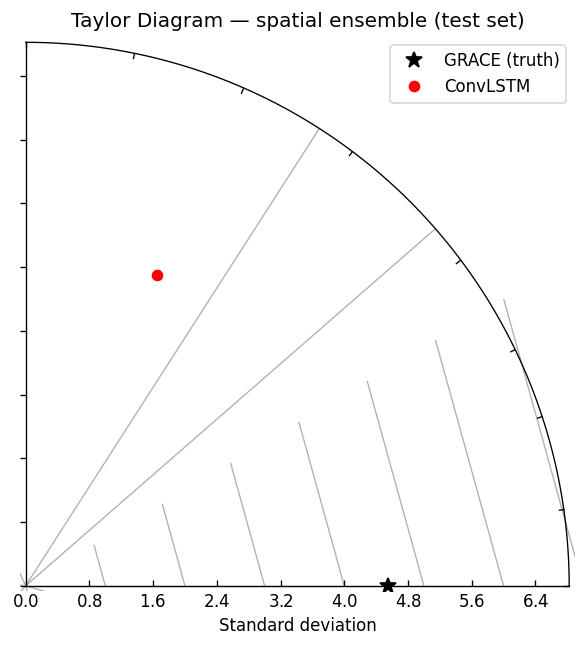

In [ ]:
# ========= Cell 22b (fix) — Minimal Taylor diagram without external packages =========
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist import floating_axes
from mpl_toolkits.axisartist.grid_finder import FixedLocator, DictFormatter
from matplotlib.projections import PolarAxes
from matplotlib.colors import Normalize

def taylor_diagram(ref, model, std_ref, label_ref="Reference", label_model="Model", smax_ratio=1.5):
    """Plot a basic Taylor diagram comparing 'ref' and 'model' arrays."""
    std_model = np.std(model, ddof=0)
    corr = np.corrcoef(ref, model)[0, 1]

    tr = PolarAxes.PolarTransform()

    # Set up correlation tick positions and labels
    corr_locs = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1.0])
    theta = np.arccos(corr_locs)
    locator = FixedLocator(theta)
    formatter = DictFormatter(dict(zip(theta, map(str, corr_locs))))

    from mpl_toolkits.axisartist import floating_axes as FA
    grid_helper = FA.GridHelperCurveLinear(tr,
                  extremes=(0, np.pi/2, 0, std_ref * smax_ratio),
                  grid_locator1=locator, tick_formatter1=formatter)

    fig = plt.figure(figsize=(6, 6))
    ax = FA.FloatingSubplot(fig, 111, grid_helper=grid_helper)
    fig.add_subplot(ax)

    ax.axis["top"].set_axis_direction("bottom")
    ax.axis["top"].label.set_text("Correlation")
    ax.axis["left"].set_axis_direction("bottom")
    ax.axis["left"].label.set_text("Standard deviation")
    ax.axis["bottom"].set_visible(False)

    aux = ax.get_aux_axes(tr)

    # Plot the reference point
    aux.plot([0], [std_ref], 'k*', markersize=10, label=label_ref)

    # Plot the model point
    aux.plot(np.arccos(corr), std_model, 'ro', label=label_model)

    aux.set_xlim(0, std_ref * smax_ratio)
    aux.set_ylim(0, std_ref * smax_ratio)
    aux.grid(True)
    ax.legend(loc='upper right')

    return fig

# Prepare flattened true and predicted test pixels within the study mask
mask_flat = (mask_all > 0.5).reshape(mask_all.shape[0], -1)

true_flat = np.concatenate([
    true_real_all[i].reshape(-1)[mask_flat[i]]
    for i in range(mask_all.shape[0])
])

pred_flat = np.concatenate([
    pred_real_all[i].reshape(-1)[mask_flat[i]]
    for i in range(mask_all.shape[0])
])

sel = np.isfinite(true_flat) & np.isfinite(pred_flat)
true_vals = true_flat[sel]
pred_vals = pred_flat[sel]

ref_std = np.std(true_vals, ddof=0)

fig = taylor_diagram(true_vals, pred_vals, ref_std,
                     label_ref="GRACE (truth)",
                     label_model="ConvLSTM",
                     smax_ratio=1.5)

plt.title("Taylor Diagram — spatial ensemble (test set)")
fig.savefig(os.path.join(PREP_DIR, "taylor_diagram_test.png"), dpi=160)
plt.show()


# **Cell 20 — Per-split & per-year metrics + Taylor diagrams**

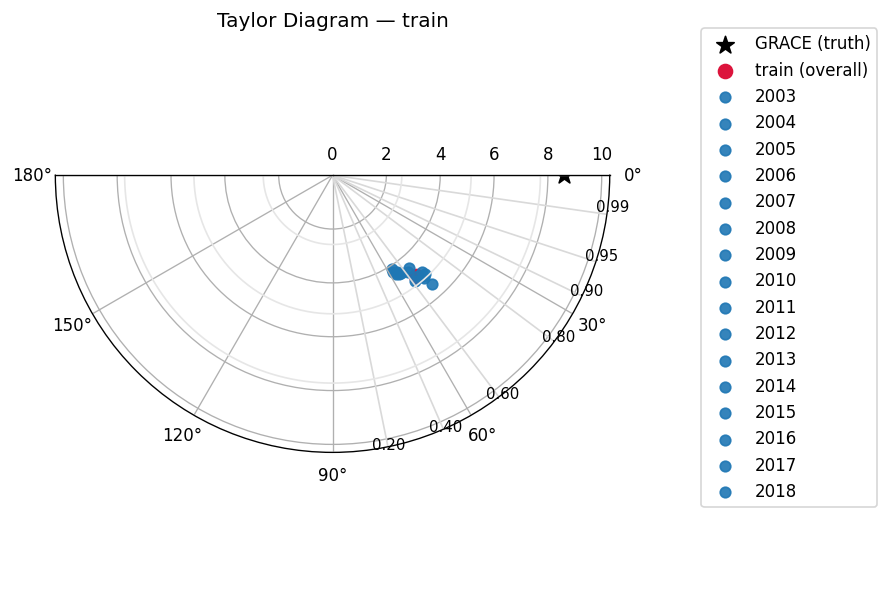


=== TRAIN per-year metrics ===


year      rmse       mae        r2      bias     std_p     std_t      corr
0   2003  6.405855  5.074495  0.412973  1.831551  5.016291  8.360807  0.684139
1   2004  6.820297  5.452123  0.281054  2.988552  4.922165  8.043685  0.648403
2   2005  7.080391  5.690542  0.275555  3.474790  4.899701  8.318684  0.676534
3   2006  6.840169  5.305794  0.383204  2.043941  5.017682  8.709557  0.668431
4   2007  6.352745  4.959768  0.420648  1.099889  5.123635  8.346228  0.663699
5   2008  6.308465  4.906536  0.455849  0.251636  5.478269  8.551924  0.676775
6   2009  6.223976  4.840895  0.372542  0.485498  4.984874  7.857340  0.613827
7   2010  6.294403  5.015479  0.318184  1.877235  4.572187  7.622914  0.615696
8   2011  6.416339  4.983616  0.308445 -0.106504  4.338885  7.715678  0.555591
9   2012  6.703255  5.267890  0.343354 -1.854380  4.447324  8.272184  0.634873
10  2013  6.704482  5.171185  0.221650 -2.309848  4.382207  7.599371  0.560619
11  2014  6.594349  4.951726  0.253683 -2.099191  4.433098  7.633262  0.573897
12  2015  7.429529  5.723800  0.183042 -2.660031  4.141911  8.219806  0.537491
13  2016  7.332798  5.816556  0.216603 -2.118916  4.249268  8.284739  0.531374
14  2017  6.298455  4.947832  0.293990 -0.930106  4.415899  7.495984  0.557142
15  2018  6.869853  5.398310  0.265474 -1.245105  4.346661  8.015746  0.538163

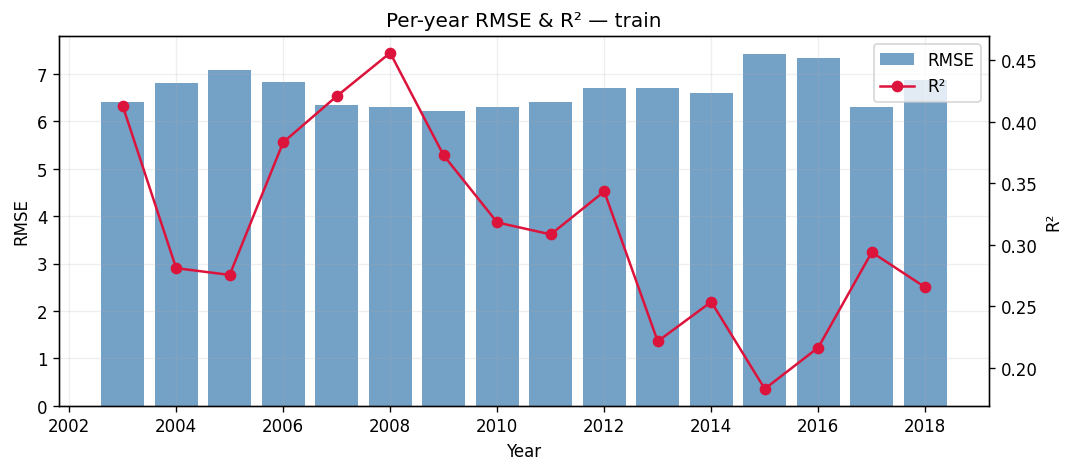

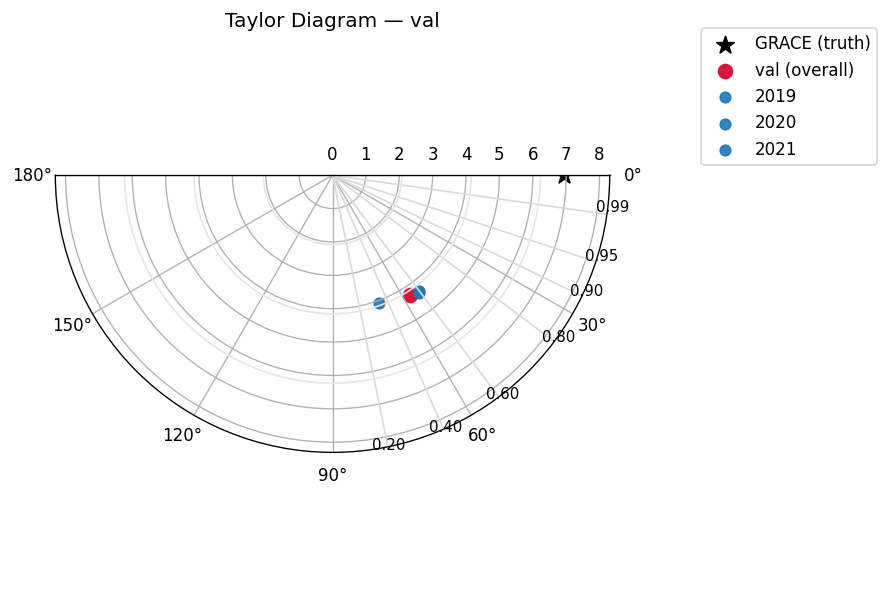


=== VAL per-year metrics ===


year      rmse       mae        r2      bias     std_p     std_t      corr
0  2019  5.612694  4.393903  0.346487  0.497963  4.382052  6.942954  0.594139
1  2020  6.217751  4.861659  0.357464 -0.256711  4.332326  7.756835  0.600251
2  2021  5.150881  3.923350 -0.151732 -0.477638  4.062734  4.799608  0.339460

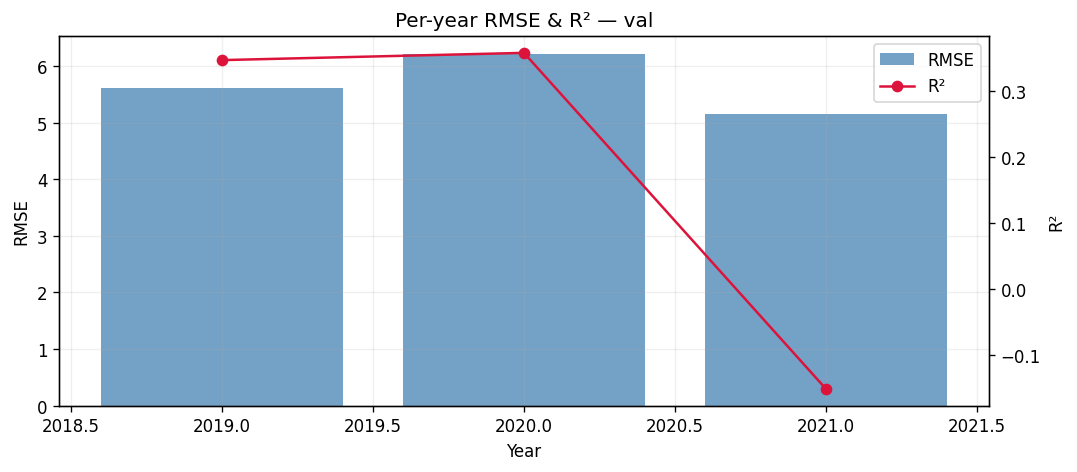

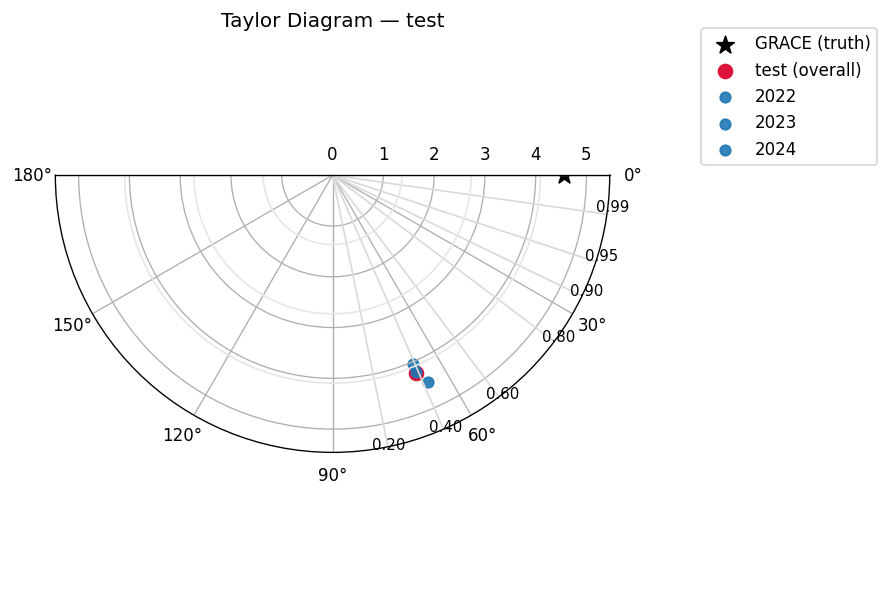


=== TEST per-year metrics ===


year      rmse       mae        r2      bias     std_p     std_t      corr
0  2022  5.733315  4.779683 -0.670219 -3.296871  4.037286  4.436281  0.390237
1  2023  5.569228  4.484148 -0.527798 -2.801800  4.207998  4.505697  0.391413
2  2024  5.042734  3.851904 -0.189389 -1.123287  4.481588  4.623854  0.417360

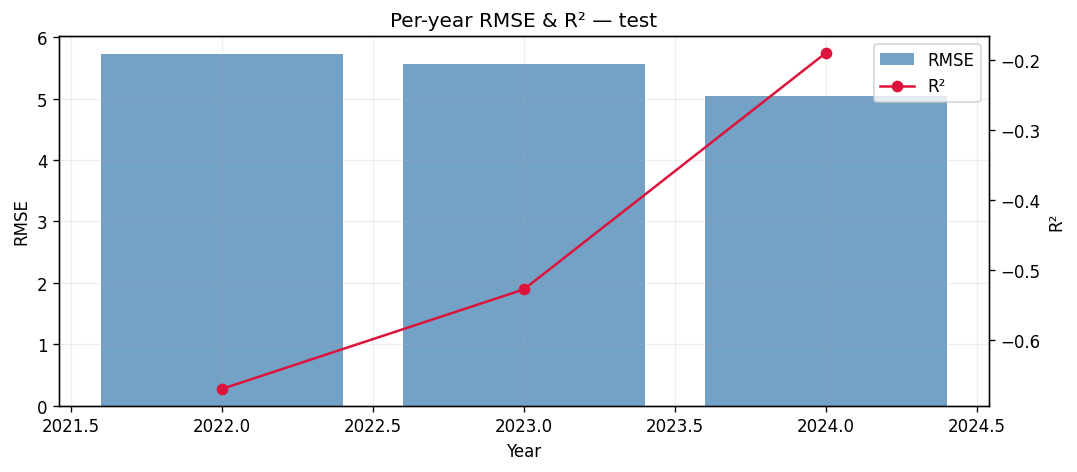

In [ ]:
# Requirements: model already built/loaded, PREP_DIR/meta.json present, study_mask.npy present,
#               and you’ve already run Cells 13–18 at least once (so Xte/Yte exist on disk).
import os, json, math, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from rasterio.transform import Affine

# ---------- helpers ----------
def _load_meta():
    with open(os.path.join(PREP_DIR, "meta.json")) as f:
        M = json.load(f)
    return (M["H"], M["W"], M["target_mean"], M["target_std"],
            Affine(*M["ref_transform"]), M["ref_crs"])

H, W, y_mean, y_std, ref_tr, ref_crs = _load_meta()
mask = np.load(os.path.join(PREP_DIR, "study_mask.npy")).astype(np.float32)  # (H,W)
mvec = mask.reshape(-1) > 0.5

def _load_split_arrays(split):
    """Return np arrays and Y_month labels for a split."""
    Xp = os.path.join(PREP_DIR, split, "X.npy")
    Yp = os.path.join(PREP_DIR, split, "Y.npy")
    idxp = os.path.join(PREP_DIR, split, "index.json")
    X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, len(BANDS_TO_USE))
    Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)
    months = json.load(open(idxp))["Y_months"] if os.path.exists(idxp) else [f"{split}_{i:03d}" for i in range(len(X))]
    return np.array(X), np.array(Y), months

def _predict_split(split, batch_size=2):
    """Run model, return lists aligned with items: pred_real, true_real, mask01, ym."""
    X, Y, yms = _load_split_arrays(split)
    preds = model.predict(X, batch_size=batch_size, verbose=0)[...,0]  # (N,H,W) z-score
    pred_real = preds * (y_std + 1e-6) + y_mean
    true_real = Y[...,0] * (y_std + 1e-6) + y_mean
    mask01    = Y[...,1] * mask  # ensure study mask AND valid target mask
    return [pred_real[i] for i in range(len(X))], [true_real[i] for i in range(len(X))], [mask01[i] for i in range(len(X))], yms

def _vec_inside(a2d, m2d):
    v = a2d.reshape(-1); mm = (m2d.reshape(-1) > 0.5)
    return v[mm]

def _spatial_metrics(pred2d, true2d, m2d):
    """RMSE, MAE, R2, bias over pixels inside mask."""
    p = _vec_inside(pred2d, m2d); t = _vec_inside(true2d, m2d)
    if p.size == 0: return dict(rmse=np.nan, mae=np.nan, r2=np.nan, bias=np.nan,
                                std_p=np.nan, std_t=np.nan, corr=np.nan, cRMSE=np.nan)
    rmse = float(np.sqrt(np.mean((p-t)**2)))
    mae  = float(np.mean(np.abs(p-t)))
    bias = float(np.mean(p - t))
    # R^2 (coefficient of determination across pixels)
    tbar = float(np.mean(t))
    ss_tot = float(np.sum((t - tbar)**2)) + 1e-12
    ss_res = float(np.sum((t - p)**2))
    r2   = 1.0 - ss_res/ss_tot
    # Taylor quantities
    std_p = float(np.std(p, ddof=0))
    std_t = float(np.std(t, ddof=0))
    corr  = float(np.corrcoef(p, t)[0,1]) if (np.std(p)>0 and np.std(t)>0) else np.nan
    cRMSE = float(np.sqrt(max(std_p**2 + std_t**2 - 2*std_p*std_t*(corr if not np.isnan(corr) else 0.0), 0.0)))
    return dict(rmse=rmse, mae=mae, r2=r2, bias=bias, std_p=std_p, std_t=std_t, corr=corr, cRMSE=cRMSE)

# ---------- Taylor diagram (pure Matplotlib, one model set + optional per-year points) ----------
class TaylorDiagram:
    def __init__(self, ref_std, fig=None, rect=111, label='Reference', sref_kwargs=None):
        self.ref_std = ref_std
        trmax = ref_std*1.2 if ref_std>0 else 1.0
        self.fig = fig or plt.figure(figsize=(6,6))
        self.ax = self.fig.add_subplot(rect, polar=True)
        self.ax.set_theta_direction(-1)
        self.ax.set_theta_zero_location('E')
        self.ax.set_thetalim(0, np.pi)
        self.ax.set_rorigin(0)
        self.ax.set_rlim(0, trmax)
        # correlation grid lines
        for c in [0.2,0.4,0.6,0.8,0.9,0.95,0.99]:
            th = np.arccos(np.clip(c, -1, 1))
            self.ax.plot([th, th], [0, trmax], color='0.85', lw=1)
            self.ax.text(th, trmax*1.02, f"{c:.2f}", ha='center', va='bottom', fontsize=9)
        # radial circles
        rs = np.linspace(0, trmax, 5)[1:]
        for r in rs:
            self.ax.plot(np.linspace(0, np.pi, 200), r*np.ones(200), color='0.9', lw=1)
        # reference point
        sref_kwargs = sref_kwargs or dict(marker='*', color='k', s=120, label=label)
        self.ax.scatter(0.0, ref_std, **sref_kwargs)

    def add_sample(self, std, corr, **kwargs):
        theta = np.arccos(np.clip(corr, -1, 1))
        return self.ax.scatter(theta, std, **kwargs)

    def add_legend(self, *args, **kwargs):
        self.ax.legend(*args, **kwargs)

def plot_taylor_for_split(split_name, per_year=False, savepath=None):
    pred_list, true_list, mask_list, months = _predict_split(split_name)
    # collapse everything to one big spatial ensemble to get overall std/corr
    p_all = np.concatenate([_vec_inside(p, m) for p, m in zip(pred_list, mask_list)])
    t_all = np.concatenate([_vec_inside(t, m) for t, m in zip(true_list, mask_list)])
    ref_std = float(np.std(t_all)) if t_all.size else 1.0
    fig = plt.figure(figsize=(6,6))
    td = TaylorDiagram(ref_std, fig=fig, rect=111, label="GRACE (truth)")
    # overall model point
    if p_all.size and t_all.size and np.std(p_all)>0 and np.std(t_all)>0:
        corr = float(np.corrcoef(p_all, t_all)[0,1])
        stdp = float(np.std(p_all))
        td.add_sample(stdp, corr, color='crimson', s=70, label=f"{split_name} (overall)")
    # optionally add year-wise points
    if per_year:
        years = sorted(set(int(m[:4]) for m in months))
        for y in years:
            idxs = [i for i, m in enumerate(months) if int(m[:4])==y]
            p = np.concatenate([_vec_inside(pred_list[i], mask_list[i]) for i in idxs])
            t = np.concatenate([_vec_inside(true_list[i], mask_list[i]) for i in idxs])
            if p.size and np.std(p)>0 and np.std(t)>0:
                td.add_sample(float(np.std(p)), float(np.corrcoef(p,t)[0,1]),
                              color='C0', s=40, alpha=0.9, label=str(y))
        # de-duplicate legend labels
        handles, labels = td.ax.get_legend_handles_labels()
        uniq = {}
        for h,l in zip(handles, labels):
            if l not in uniq: uniq[l]=h
        td.ax.legend(uniq.values(), uniq.keys(), loc='upper left', bbox_to_anchor=(1.15,1.03))
    else:
        td.ax.legend(loc='upper left', bbox_to_anchor=(1.15,1.03))
    td.ax.set_title(f"Taylor Diagram — {split_name}")
    if savepath:
        Path(os.path.dirname(savepath)).mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, dpi=160, bbox_inches='tight')
    plt.show()

# ---------- bar/line summaries per year ----------
def per_year_table(split_name):
    pred_list, true_list, mask_list, months = _predict_split(split_name)
    years = sorted(set(int(m[:4]) for m in months))
    rows = []
    for y in years:
        idxs = [i for i,m in enumerate(months) if int(m[:4])==y]
        # stack to (N,H,W) -> vectors
        p = np.concatenate([_vec_inside(pred_list[i], mask_list[i]) for i in idxs])
        t = np.concatenate([_vec_inside(true_list[i], mask_list[i]) for i in idxs])
        if p.size==0:
            rows.append(dict(year=y, rmse=np.nan, mae=np.nan, r2=np.nan, bias=np.nan,
                             std_p=np.nan, std_t=np.nan, corr=np.nan))
            continue
        met = _spatial_metrics(pred_list[idxs[0]]*0 + p.reshape(-1)[:1],  # dummy to access keys
                               true_list[idxs[0]]*0 + t.reshape(-1)[:1], mask_list[idxs[0]]*0 + 1)
        # compute directly on p,t vectors
        rmse = float(np.sqrt(np.mean((p-t)**2)))
        mae  = float(np.mean(np.abs(p-t)))
        bias = float(np.mean(p-t))
        std_p= float(np.std(p)); std_t=float(np.std(t))
        corr = float(np.corrcoef(p,t)[0,1]) if (np.std(p)>0 and np.std(t)>0) else np.nan
        tbar = float(np.mean(t)); ss_tot=float(np.sum((t-tbar)**2))+1e-12; ss_res=float(np.sum((t-p)**2))
        r2   = 1.0-ss_res/ss_tot
        rows.append(dict(year=y, rmse=rmse, mae=mae, r2=r2, bias=bias,
                         std_p=std_p, std_t=std_t, corr=corr))
    import pandas as pd
    df = pd.DataFrame(rows).sort_values("year")
    return df

def plot_per_year(df, split_name, savepath=None):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax2 = ax1.twinx()
    ax1.bar(df["year"], df["rmse"], color='steelblue', alpha=0.75, label="RMSE")
    ax2.plot(df["year"], df["r2"], color='crimson', marker='o', label="R²")
    ax1.set_xlabel("Year"); ax1.set_ylabel("RMSE"); ax2.set_ylabel("R²")
    ax1.set_title(f"Per-year RMSE & R² — {split_name}")
    ax1.grid(True, alpha=0.2)
    h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")
    if savepath:
        Path(os.path.dirname(savepath)).mkdir(parents=True, exist_ok=True)
        plt.savefig(savepath, dpi=160, bbox_inches='tight')
    plt.show()

# ---------- run it ----------
for split in ["train","val","test"]:
    # Taylor diagram with per-year points
    plot_taylor_for_split(split, per_year=True,
                          savepath=os.path.join(PREP_DIR, "figs", f"taylor_{split}.png"))
    # per-year table & plot
    df = per_year_table(split)
    print(f"\n=== {split.upper()} per-year metrics ===")
    display(df)  # in notebooks; otherwise print(df)
    plot_per_year(df, split, savepath=os.path.join(PREP_DIR, "figs", f"per_year_{split}.png"))


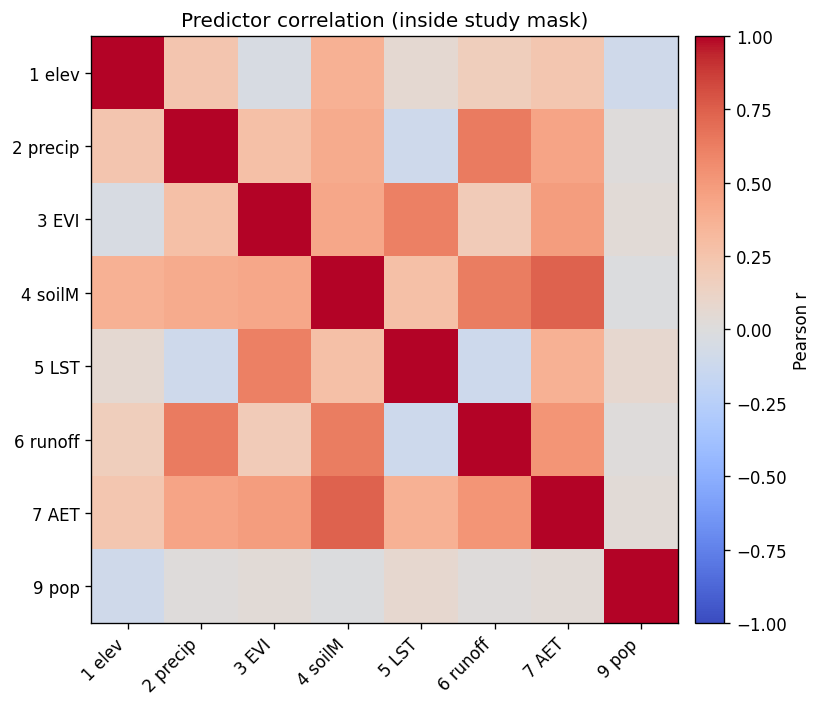

In [ ]:
#Cell 20 — Correlation matrix (inside study mask)
import numpy as np, matplotlib.pyplot as plt, os

FIG_DIR = os.path.join(PREP_DIR, "figs"); os.makedirs(FIG_DIR, exist_ok=True)

def month_list_to_array(months, max_months=24):
    """Stack a sample of months -> (Npix, B) for correlation (inside mask)."""
    sel = months[:max_months] if len(months) > max_months else months
    B = len(BANDS_TO_USE)
    mflat = mask.reshape(-1) > 0.5
    Xs = []
    for ym in sel:
        arr = read_predictors_resampled(ym).astype(np.float32)  # (B,H,W)
        arr = np.nan_to_num(arr, nan=0.0)
        # exclude the landcover band from correlation (categorical)
        keep = [b for b in range(B) if b != 7]   # idx 7 (0-based) is landcover
        flat = arr[keep].reshape(len(keep), -1)[:, mflat]
        Xs.append(flat.T)                        # (n_pix, B_keep)
    return np.vstack(Xs), keep  # (Npix_total, B_keep)

# build inside-mask matrix from (preferably) train months
Xcorr, keep_idx = month_list_to_array(MONTHS, max_months=36)  # use any month set you like
corr = np.corrcoef(Xcorr, rowvar=False)

labels = [f"{i+1} {['elev','precip','EVI','soilM','LST','runoff','AET','LC','pop'][i]}"
          for i in range(len(BANDS_TO_USE)) if i != 7]

plt.figure(figsize=(8,6))
im = plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, fraction=0.046, pad=0.02, label="Pearson r")
plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right")
plt.yticks(np.arange(len(labels)), labels)
plt.title("Predictor correlation (inside study mask)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "corr_matrix_inside.png"), dpi=180)
plt.show()


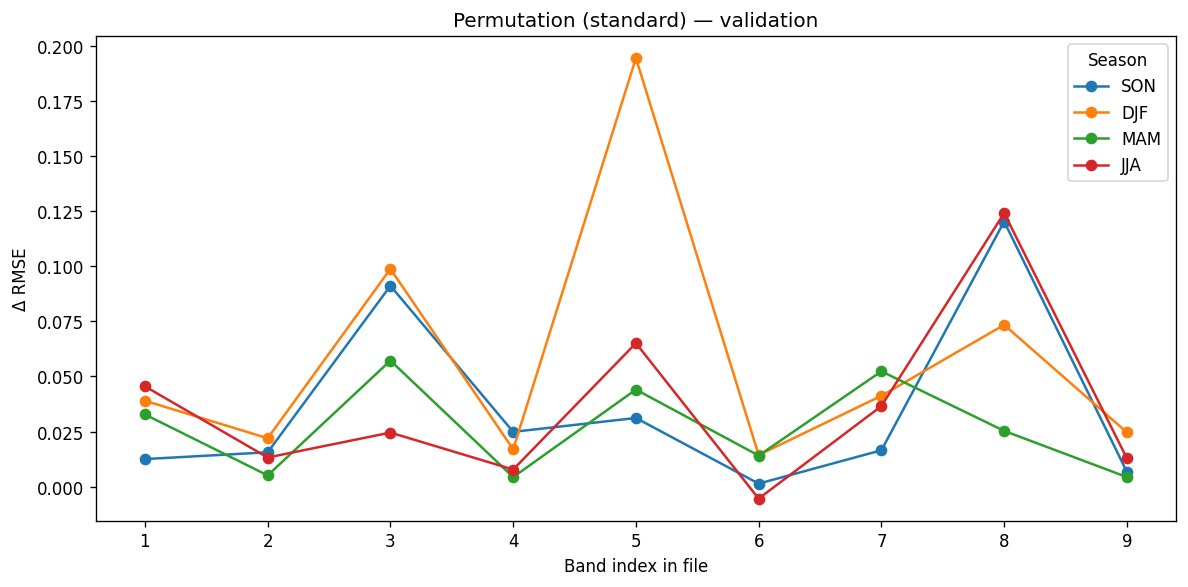

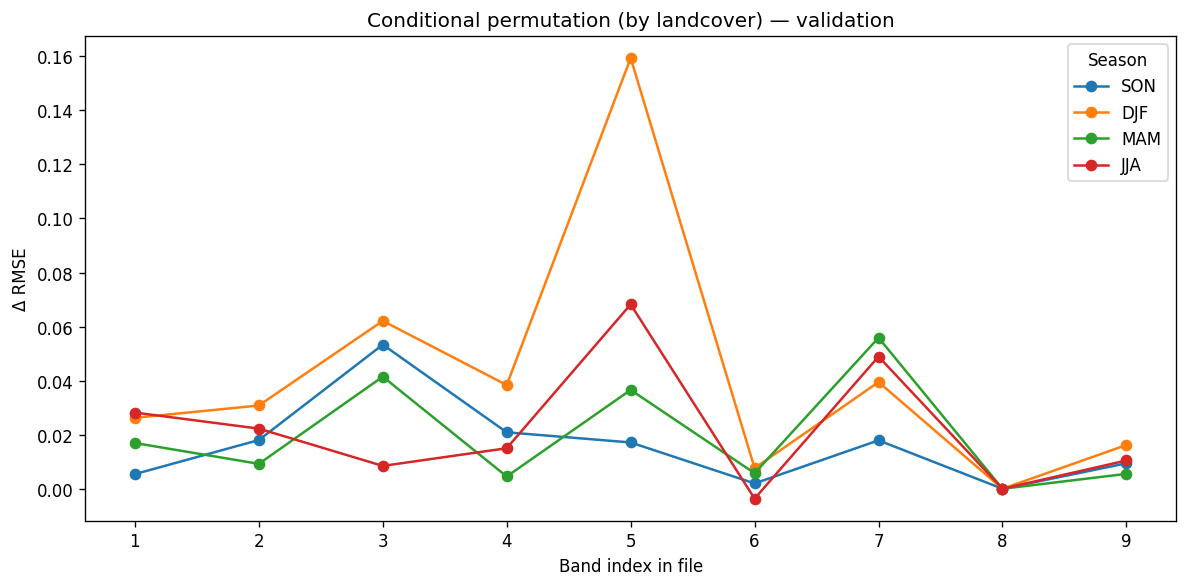

In [ ]:
#Cell 21 — Conditional permutation importance
import numpy as np, matplotlib.pyplot as plt, collections

def season_from_ym(ym):
    m = int(ym[4:6])
    return {12:"DJF",1:"DJF",2:"DJF", 3:"MAM",4:"MAM",5:"MAM",
            6:"JJA",7:"JJA",8:"JJA", 9:"SON",10:"SON",11:"SON"}[m]

def rmse_from_batches(ds):
    se_sum, m_sum = 0.0, 0.0
    for Xb, Yb in ds:
        pred = model(Xb, training=False)[...,0]
        yt   = Yb[...,0]; m = Yb[...,1]
        se_sum += np.sum(((yt - pred)*m).numpy()**2)
        m_sum  += np.sum(m.numpy())
    return float(np.sqrt(se_sum / max(m_sum, 1e-6)))

def make_subsets_by_season(X, Y, months_for_windows):
    """Return dict season->(X,Y) arrays for val split."""
    buckets = collections.defaultdict(lambda: ([],[]))
    for i, targ in enumerate(months_for_windows):
        s = season_from_ym(targ)
        buckets[s][0].append(X[i]); buckets[s][1].append(Y[i])
    out = {}
    for s,(xs,ys) in buckets.items():
        out[s] = (np.array(xs), np.array(ys))
    return out

def build_ds(X, Y, shuffle=False):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle: ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=False)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

def cond_permute_band_inplace(X, band_idx, groups=None, lc_band=7):
    """
    Permute X[...,band_idx] but conditionally within groups:
    - groups == None -> global permutation (standard)
    - groups == 'season' -> shuffle within batch item (no-op; seasonal grouping handled above)
    - groups == 'landcover' -> shuffle values within identical LC codes at each (T,H,W)
    """
    Xp = X.copy()
    if groups == "landcover":
        # assume predictor cube in memory for the same windows; we have LC at index `lc_band`
        LC = X[..., lc_band]  # (N,T,H,W)
        for code in np.unique(LC):
            mask_code = (LC == code)
            vals = Xp[..., band_idx][mask_code]
            rng = np.random.default_rng(SEED)
            rng.shuffle(vals)
            Xp[..., band_idx][mask_code] = vals
    else:
        # global permutation across all elements
        vals = Xp[..., band_idx].reshape(-1)
        rng = np.random.default_rng(SEED)
        rng.shuffle(vals)
        Xp[..., band_idx] = vals.reshape(Xp[..., band_idx].shape)
    return Xp

# --- baseline (unpermuted) error on a *seasonal* subset of VAL
idx_path = os.path.join(PREP_DIR, "val", "index.json")
val_meta = json.load(open(idx_path))
val_target_months = val_meta["Y_months"]
season_buckets = make_subsets_by_season(Xva, Yva, val_target_months)

# compute base RMSE per season
base_rmse = {s: rmse_from_batches(build_ds(*season_buckets[s])) for s in season_buckets}

# permute each band, by season and by landcover, and measure ΔRMSE
per_imp_season = {s: [] for s in season_buckets}
per_imp_landc  = {s: [] for s in season_buckets}
for s in season_buckets:
    Xs, Ys = season_buckets[s]
    for b in range(len(BANDS_TO_USE)):
        Xp = cond_permute_band_inplace(Xs, b, groups=None)  # standard permutation
        rm = rmse_from_batches(build_ds(Xp, Ys))
        per_imp_season[s].append(rm - base_rmse[s])

        Xp2 = cond_permute_band_inplace(Xs, b, groups="landcover", lc_band=7)
        rm2 = rmse_from_batches(build_ds(Xp2, Ys))
        per_imp_landc[s].append(rm2 - base_rmse[s])

# --- plot (one figure per scheme)
x = np.arange(1, len(BANDS_TO_USE)+1)
for title, store in [("Permutation (standard)", per_imp_season),
                     ("Conditional permutation (by landcover)", per_imp_landc)]:
    plt.figure(figsize=(10,5))
    for s,vals in store.items():
        plt.plot(x, vals, marker="o", label=s)
    plt.xticks(x, [str(i) for i in x])
    plt.xlabel("Band index in file"); plt.ylabel("Δ RMSE")
    plt.legend(title="Season"); plt.title(title + " — validation")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"{title.replace(' ','_').lower()}.png"), dpi=180)
    plt.show()


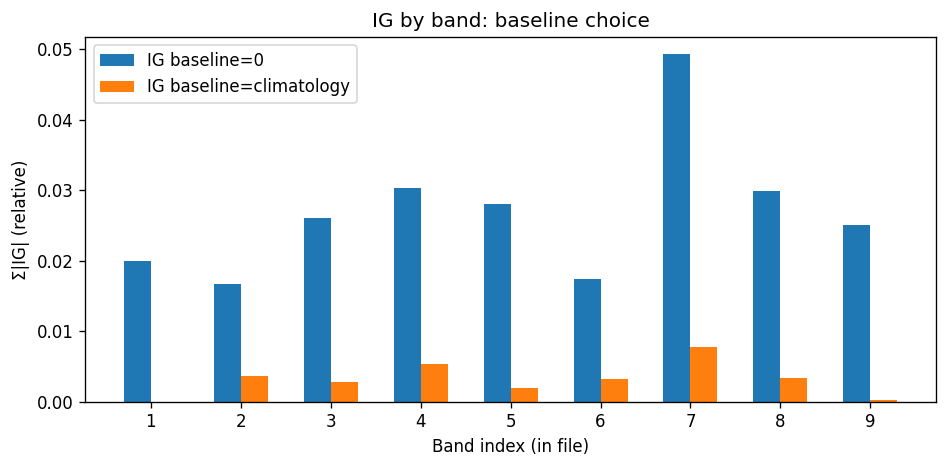

In [ ]:
#Cell 22 — Integrated-Gradients with alternate baselines
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt

def integrated_gradients(model, x, baseline, steps=32):
    """
    IG along the straight path baseline->x.
    x/baseline: (B,T,H,W,C) float32
    returns: (B,T,H,W,C) IG attributions.
    """
    x = tf.cast(x, tf.float32); baseline = tf.cast(baseline, tf.float32)
    alphas = tf.linspace(0.0, 1.0, steps+1)[1:]   # exclude 0 to avoid degenerate grad
    grads_accum = tf.zeros_like(x)
    for a in alphas:
        x_i = baseline + a * (x - baseline)
        with tf.GradientTape() as tape:
            tape.watch(x_i)
            y = model(x_i, training=False)[...,0]  # (B,H,W)
            # average prediction over *inside* mask to focus saliency
            m = tf.convert_to_tensor(mask, tf.float32)[None, None, ..., None]  # (1,1,H,W,1)
            yt = tf.reduce_sum(y * tf.squeeze(m, axis=-1), axis=[1,2]) / (tf.reduce_sum(m)+1e-6)
            loss = tf.reduce_mean(yt)
        grads = tape.gradient(loss, x_i)          # (B,T,H,W,C)
        grads_accum += grads
    # Riemann sum
    avg_grads = grads_accum / tf.cast(tf.size(alphas), tf.float32)
    ig = (x - baseline) * avg_grads
    return ig

# --- choose a small, representative validation mini-batch
bx_val, by_val = next(iter(val_ds))                 # (B,T,H,W,C)
B,T,Hh,Ww,C = bx_val.shape

# Baseline A: zeros (what you used before)
baseline_zero = tf.zeros_like(bx_val)

# Baseline B: **climatology** -> mean of training inputs per (t, band)
#   build from your Xtr (already normalized & masked)
mu_train = np.mean(Xtr, axis=0, keepdims=True)      # (1,T,H,W,C)
baseline_clim = tf.convert_to_tensor(mu_train, tf.float32)

# compute IG for both
IG_zero = integrated_gradients(model, bx_val, baseline_zero, steps=32).numpy()
IG_clim = integrated_gradients(model, bx_val, baseline_clim, steps=32).numpy()

# --- compare band-wise sums
sum_zero_band = np.sum(np.abs(IG_zero), axis=(0,1,2,3))   # (C,)
sum_clim_band = np.sum(np.abs(IG_clim), axis=(0,1,2,3))   # (C,)

plt.figure(figsize=(8,4))
w = np.arange(1, C+1)
plt.bar(w-0.15, sum_zero_band, width=0.3, label="IG baseline=0")
plt.bar(w+0.15, sum_clim_band, width=0.3, label="IG baseline=climatology")
plt.xticks(w, [str(i) for i in w]); plt.xlabel("Band index (in file)")
plt.ylabel("Σ|IG| (relative)"); plt.legend(); plt.title("IG by band: baseline choice")
plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "ig_band_baselines.png"), dpi=180); plt.show()


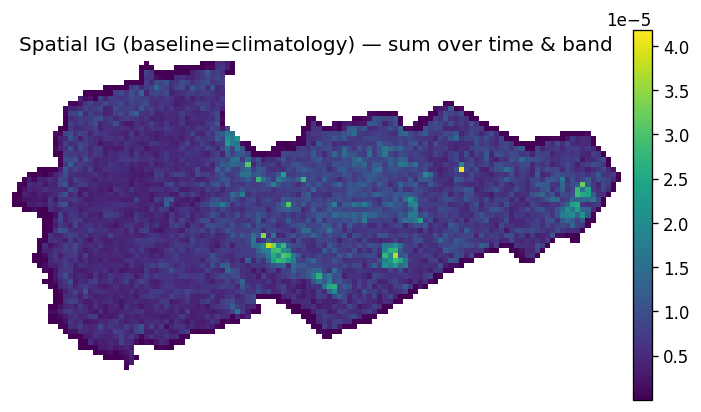

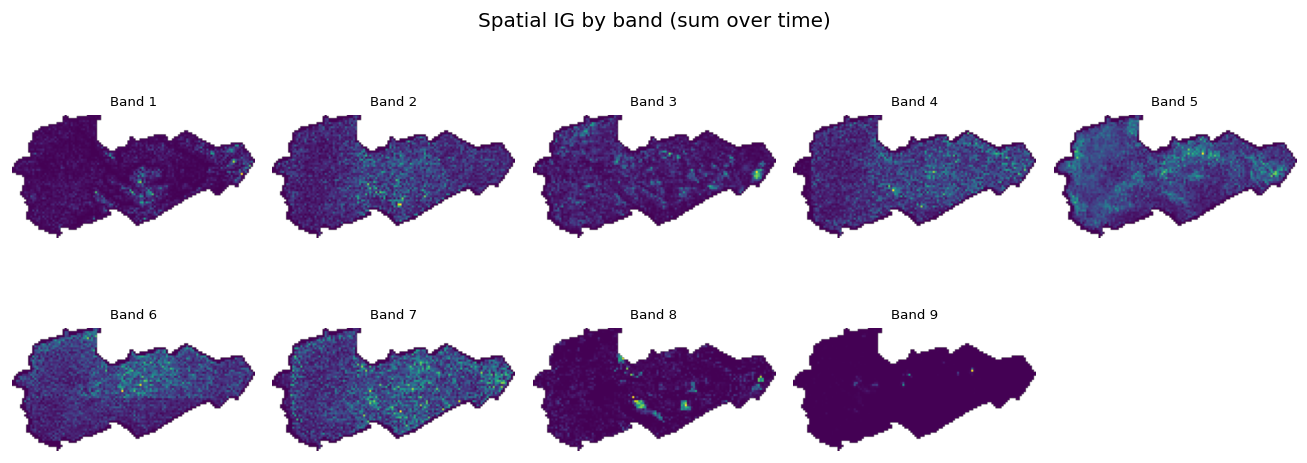

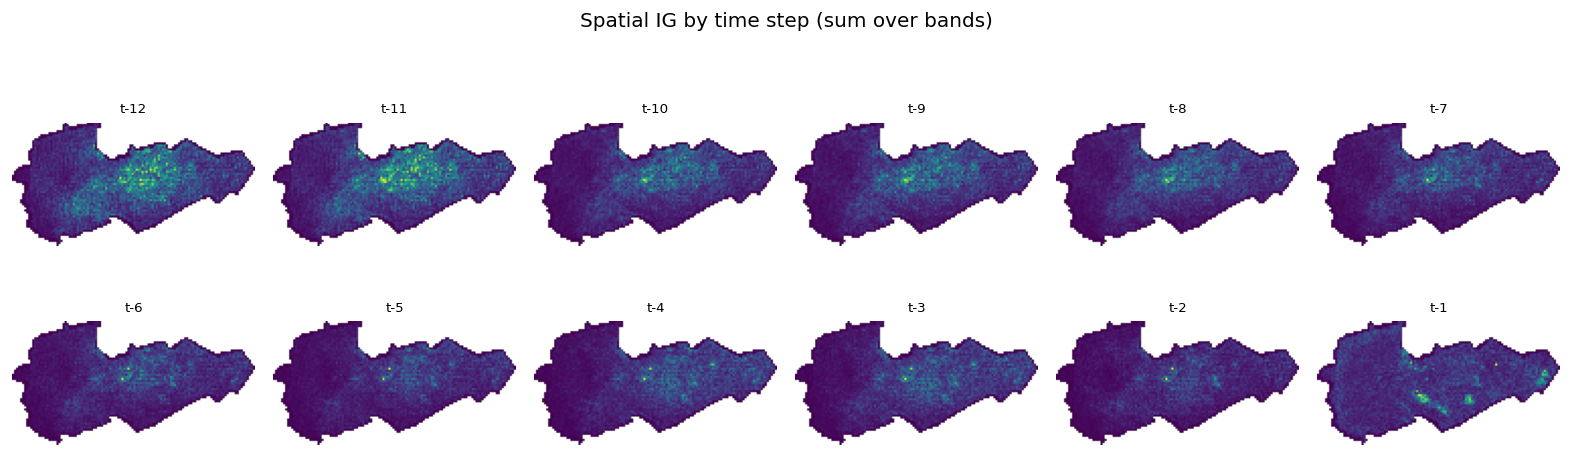

In [ ]:
#Cell 23 — Spatial IG maps (per band and per time-step)
import numpy as np, matplotlib.pyplot as plt, os

def plot_spatial_ig(IG, title, sum_over=("time","band"), vmax=None, save_as=None):
    """
    IG: (B,T,H,W,C)
    sum_over: choose which axes to sum |IG| across:
      ("time","band") -> (H,W) total importance map
      ("time",)       -> per-band maps (list)
      ("band",)       -> per-time maps (list)
    """
    A = np.abs(IG)
    axes = {"time":1, "band":4}
    keep = [axes[k] for k in sum_over]
    # sum over selected dims across batch too
    summed = np.sum(A, axis=(0,)+tuple(keep)) if len(keep)==2 else np.sum(A, axis=(0, keep[0]))
    # enforce study mask
    if summed.ndim==2:
        mm = np.where(mask>0.5, summed, np.nan)
        plt.figure(figsize=(7,4)); im=plt.imshow(mm, cmap="viridis"); plt.colorbar(im, fraction=0.046, pad=0.02)
        plt.title(title); plt.axis("off")
        if save_as: plt.savefig(os.path.join(FIG_DIR, save_as), dpi=180, bbox_inches="tight")
        plt.show()
    else:
        if "time" in sum_over:
            # per band
            n = summed.shape[-1]
            cols = min(5, n); rows = int(np.ceil(n/cols))
            plt.figure(figsize=(2.2*cols, 2.2*rows))
            for i in range(n):
                mm = np.where(mask>0.5, summed[..., i], np.nan)
                ax = plt.subplot(rows, cols, i+1); ax.imshow(mm, cmap="viridis"); ax.set_title(f"Band {i+1}", fontsize=8); ax.axis("off")
            plt.suptitle(title); plt.tight_layout()
            if save_as: plt.savefig(os.path.join(FIG_DIR, save_as), dpi=180, bbox_inches="tight")
            plt.show()
        else:
            # per time
            n = summed.shape[0]
            cols = min(6, n); rows = int(np.ceil(n/cols))
            plt.figure(figsize=(2.2*cols, 2.2*rows))
            for i in range(n):
                mm = np.where(mask>0.5, summed[i], np.nan)
                ax = plt.subplot(rows, cols, i+1); ax.imshow(mm, cmap="viridis"); ax.set_title(f"t-{T-i}", fontsize=8); ax.axis("off")
            plt.suptitle(title); plt.tight_layout()
            if save_as: plt.savefig(os.path.join(FIG_DIR, save_as), dpi=180, bbox_inches="tight")
            plt.show()

# total spatial importance
plot_spatial_ig(IG_clim, "Spatial IG (baseline=climatology) — sum over time & band",
                sum_over=("time","band"), save_as="ig_spatial_total.png")

# per-band spatial maps (summed over time)
plot_spatial_ig(IG_clim, "Spatial IG by band (sum over time)",
                sum_over=("time",), save_as="ig_spatial_per_band.png")

# per-time-step spatial maps (summed over bands)
plot_spatial_ig(IG_clim, "Spatial IG by time step (sum over bands)",
                sum_over=("band",), save_as="ig_spatial_per_time.png")


In [ ]:
# ========= Cell 21c — Conditional permutation importance (per-year & season×landcover) =========
import os, json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

OUT_DIR = os.path.join(PREP_DIR, "analysis_importance")
os.makedirs(OUT_DIR, exist_ok=True)

# -- helpers
def ym_to_year(ym):  # "YYYYMM" -> 4-digit year
    return int(str(ym)[:4])

def month_to_season(mm):  # 1..12 -> DJF/MAM/JJA/SON (DJF uses month labels; no year wrap for grouping)
    mm = int(mm)
    if mm in (12,1,2): return "DJF"
    if mm in (3,4,5):  return "MAM"
    if mm in (6,7,8):  return "JJA"
    return "SON"

def rmse_from_batches(bx, by, pixel_mask=None):
    """bx:(N,T,H,W,C) by:(N,H,W,2) optional pixel_mask:(N,H,W) in {0,1}"""
    yt = by[...,0]; m = by[...,1]
    yp = model.predict(bx, verbose=0)[...,0]
    if pixel_mask is not None:
        m = m * pixel_mask.astype(np.float32)
    se = ((yt - yp)**2) * m
    return np.sqrt(se.sum() / (m.sum() + 1e-6))

def permute_feature_inplace(batch_x, feat_idx, rng, within_mask=None):
    """Shuffle feature C index 'feat_idx' across pixels. If within_mask (N,H,W) given,
       permute only *within* each mask==1 block and leave outside intact."""
    X = batch_x.copy()
    T, H, W, C = X.shape[1:]  # (N,T,H,W,C)
    if within_mask is None:
        # global shuffle for each time step independently
        for t in range(T):
            slab = X[:, t, ..., feat_idx].reshape(-1)
            rng.shuffle(slab)
            X[:, t, ..., feat_idx] = slab.reshape(X.shape[0], H, W)
    else:
        # conditional: for each sample, shuffle only where mask==1
        for n in range(X.shape[0]):
            m = within_mask[n].astype(bool)
            for t in range(T):
                slab = X[n, t, ..., feat_idx]
                vals = slab[m]
                rng.shuffle(vals)
                slab[m] = vals
                X[n, t, ..., feat_idx] = slab
    return X

# ---- pull validation labels (YYYYMM) if available
val_index_json = os.path.join(PREP_DIR, "val", "index.json")
if os.path.exists(val_index_json):
    Y_months_val = json.load(open(val_index_json))["Y_months"]
else:
    # if missing, synthesize string placeholders so code still runs
    Y_months_val = [f"0000{m:02d}" for m in range(1, 1+len(Xva))]

# ---- derive per-sample metadata
years   = np.array([ym_to_year(ym) for ym in Y_months_val])
months  = np.array([int(str(ym)[-2:]) for ym in Y_months_val])
seasons = np.array([month_to_season(m) for m in months])

# ---- landcover codes per sample (use last time step of band 8, 0-based idx 7 in your list)
LC_BAND_IDX = 7  # band 8 in file
lc_last = Xva[:, -1, ..., LC_BAND_IDX]
lc_codes = np.unique(lc_last[mask.astype(bool)])
lc_codes = [int(c) for c in lc_codes if np.isfinite(c)]  # drop nans

rng = np.random.default_rng(1337)
band_ids = list(range(len(BANDS_TO_USE)))  # 0..8

# ------------------------------------------------------------------------------------
# A) PER-YEAR conditional permutation importance (evaluate only samples for that year)
# ------------------------------------------------------------------------------------
rows = []
for yr in sorted(np.unique(years)):
    idx = np.where(years == yr)[0]
    if idx.size == 0:
        continue
    bx = Xva[idx]; by = Yva[idx]
    base = rmse_from_batches(bx, by)
    for b in band_ids:
        bx_perm = permute_feature_inplace(bx, b, rng)   # global permute within the year subset
        rmse_p  = rmse_from_batches(bx_perm, by)
        rows.append({"group":"year", "year":int(yr), "band": int(BANDS_TO_USE[b]), "delta_rmse": float(rmse_p - base)})
per_year_df = pd.DataFrame(rows).sort_values(["year","band"])
per_year_csv = os.path.join(OUT_DIR, "perm_importance_per_year.csv")
per_year_df.to_csv(per_year_csv, index=False)
print("✓ wrote:", per_year_csv)

# heatmap (years × bands)
if len(per_year_df):
    pivot = per_year_df.pivot(index="year", columns="band", values="delta_rmse").sort_index()
    plt.figure(figsize=(0.7*pivot.shape[1]+4, 0.6*pivot.shape[0]+2))
    im = plt.imshow(pivot.values, aspect="auto", cmap="viridis")
    plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=0)
    plt.yticks(range(pivot.shape[0]), pivot.index)
    plt.colorbar(im, label="ΔRMSE (permute − base)")
    plt.title("Conditional permutation importance — per year (validation)")
    plt.xlabel("Band in file"); plt.ylabel("Year")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "perm_importance_per_year_heatmap.png"), dpi=200)
    plt.close()

# ----------------------------------------------------------------------------------------------------
# B) PER-SEASON × LANDCOVER conditional permutation (shuffle within LC; evaluate only that LC pixels)
# ----------------------------------------------------------------------------------------------------
rows = []
for seas in ["DJF","MAM","JJA","SON"]:
    idx_s = np.where(seasons == seas)[0]
    if idx_s.size == 0:
        continue
    bx_s = Xva[idx_s]; by_s = Yva[idx_s]
    # build per-sample masks for each landcover code (only inside study area)
    for lc in lc_codes:
        lc_masks = (lc_last[idx_s] == lc).astype(np.float32) * mask  # (Ns,H,W)
        # if this LC barely appears in this season, skip
        if lc_masks.sum() < 50:
            continue
        base = rmse_from_batches(bx_s, by_s, pixel_mask=lc_masks)
        for b in band_ids:
            # permute within LC pixels only (conditional), then evaluate **only those LC pixels**
            bx_perm = permute_feature_inplace(bx_s, b, rng, within_mask=lc_masks)
            rmse_p  = rmse_from_batches(bx_perm, by_s, pixel_mask=lc_masks)
            rows.append({
                "group":"season×lc", "season":seas, "lc":int(lc),
                "band": int(BANDS_TO_USE[b]), "delta_rmse": float(rmse_p - base),
                "pixels": int(lc_masks.sum())
            })
per_season_lc_df = pd.DataFrame(rows).sort_values(["season","lc","band"])
csv2 = os.path.join(OUT_DIR, "perm_importance_per_season_by_landcover.csv")
per_season_lc_df.to_csv(csv2, index=False)
print("✓ wrote:", csv2)

# plot: for each season, a small heatmap (LC rows × band cols)
if len(per_season_lc_df):
    for seas in ["DJF","MAM","JJA","SON"]:
        sub = per_season_lc_df[per_season_lc_df["season"]==seas]
        if sub.empty:
            continue
        pivot = sub.pivot(index="lc", columns="band", values="delta_rmse").sort_index()
        plt.figure(figsize=(0.7*pivot.shape[1]+4, 0.5*pivot.shape[0]+2))
        im = plt.imshow(pivot.values, aspect="auto", cmap="viridis")
        plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=0)
        plt.yticks(range(pivot.shape[0]), pivot.index)
        plt.colorbar(im, label="ΔRMSE (permute − base)")
        plt.title(f"Conditional permutation importance — {seas} by landcover (validation)")
        plt.xlabel("Band in file"); plt.ylabel("Landcover code")
        plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f"perm_importance_{seas}_by_landcover.png"), dpi=200)
        plt.close()

# ------------------------------------------------------------------------------------
# C) Alternate IG baselines & spatial IG maps (optional, quick demo on a few samples)
# ------------------------------------------------------------------------------------
try:
    import tensorflow as tf
    def integrated_gradients(model, x, baseline, steps=32):
        # x:(1,T,H,W,C), baseline same shape
        alphas = tf.linspace(0., 1., steps)[:, None, None, None, None]
        x_scaled = baseline + alphas * (x - baseline)
        with tf.GradientTape() as tape:
            tape.watch(x_scaled)
            y = model(x_scaled, training=False)[..., 0]                 # (steps,1,H,W)
            # focus IG on inside-study pixels
            m = tf.convert_to_tensor(mask, dtype=tf.float32)[None, ...] # (1,H,W)
            targ = tf.reduce_sum(y * m, axis=[2,3]) / (tf.reduce_sum(m) + 1e-6)  # (steps,1)
            targ = tf.reduce_mean(targ, axis=1)                          # (steps,)
        grads = tape.gradient(targ, x_scaled)                             # (steps,1,T,H,W,C)
        avg_grads = tf.reduce_mean(grads, axis=0)[0]                      # (T,H,W,C)
        return (x[0] - baseline[0]) * avg_grads                           # (T,H,W,C)

    # prepare two baselines: zeros & climatological mean of validation X
    clim = np.mean(Xva, axis=0, keepdims=True).astype(np.float32)  # (1,T,H,W,C)
    zero = np.zeros_like(clim)

    ig_dir = os.path.join(OUT_DIR, "ig_spatial")
    os.makedirs(ig_dir, exist_ok=True)

    # run IG on first few validation windows and export spatial maps
    K = min(3, Xva.shape[0])
    for i in range(K):
        x = Xva[i:i+1].astype(np.float32)
        for name, base in [("zero", zero), ("clim", clim)]:
            ig = integrated_gradients(model, x, base, steps=32).numpy()      # (T,H,W,C)
            ig_sum_time = np.abs(ig).sum(axis=0)                              # (H,W,C)
            # 1) aggregate over bands -> "where in space the model is sensitive"
            ig_space = ig_sum_time.sum(axis=-1)                               # (H,W)
            np.save(os.path.join(ig_dir, f"ig_space_{name}_sample{i}.npy"), ig_space)
            # 2) per-band spatial IG (optional)
            for b in band_ids:
                m2 = ig_sum_time[..., b]
                np.save(os.path.join(ig_dir, f"ig_band{BANDS_TO_USE[b]}_{name}_sample{i}.npy"), m2)

            # quick plot of the space-aggregated IG
            v = np.nanpercentile(ig_space[mask>0.5], 99)
            plt.figure(figsize=(5,3))
            plt.imshow(np.where(mask>0.5, ig_space, np.nan), vmin=0, vmax=v, cmap="magma")
            plt.title(f"IG spatial (sum time×band) — {name} baseline — sample {i}")
            plt.axis("off"); cb = plt.colorbar(); cb.set_label("relative importance")
            plt.tight_layout(); plt.savefig(os.path.join(ig_dir, f"ig_space_{name}_sample{i}.png"), dpi=180)
            plt.close()
    print("✓ IG spatial maps saved in:", ig_dir)
except Exception as e:
    print("IG step skipped:", e)

print("Done.")


IndexError: boolean index did not match indexed array along axis 0; size of axis is 21 but size of corresponding boolean axis is 61

I’ve gone through your full CNN-LSTM (ConvLSTM U-Net) pipeline code. It looks very solid and well-structured: you handle preprocessing (alignment, masking, normalization), dataset splitting, model building, training with callbacks, evaluation, and export to GeoTIFFs.

Here are a few important checks, tips, and clarifications for you:

---

### ✅ What’s working well

* **Robust file discovery:** You sanitize paths and regex-match by YYYYMM, ensuring consistent alignment between predictors and targets.
* **Study mask:** You have a fallback to Google Earth Engine if the shapefile is missing — very handy.
* **Normalization:** Computed only from training windows and restricted to study-area pixels. That avoids leakage.
* **Model:** ConvLSTM U-Net with residual and squeeze-and-excitation blocks is strong for spatiotemporal learning.
* **Loss & metrics:** Custom masked Huber loss, RMSE, and R² — properly ignoring nodata and out-of-region pixels.
* **Export:** You preserve CRS, transform, and nodata in GeoTIFF outputs, so the predictions stay GIS-ready.

---

### ⚠️ Things to double-check

1. **Band order:**
   You set `BANDS_TO_USE = list(range(1, 10))`. Make sure these 9 bands are consistently ordered across *all* monthly predictor stacks. If the TIFFs differ in band order, you’ll get mismatched features.

2. **Mask alignment:**
   After rasterization, check that the valid pixels (`mask.sum()`) are close to expectations. If it’s much lower than expected, CRS misalignment might be clipping your study area.

3. **Batch size:**
   You’re using `BATCH_SIZE = 4` on GPU, `2` on CPU. If GPU memory allows, increasing it (e.g., 8 or 16) can stabilize training.

4. **Epochs & early stopping:**

   * Right now, `epochs=30`, `patience=10`. With noisy validation, this may stop early.
   * If you want a more thorough training, increase epochs (e.g., 60 or 100) while keeping patience.

5. **GeoTIFF output:**
   You save predictions in real units (denormalized). Perfect. Just be careful that masking applies — you already do `np.where(mask > 0.5, pred_real, np.nan)`, which is good.

---

### 🔧 Suggestions for improvement

* **Learning rate schedule:** You’re using `ReduceLROnPlateau`. You might also test `CosineDecay` or `OneCycle` learning rates for ConvLSTM models.
* **Data augmentation:** Currently missing. Temporal flipping or light noise injection on predictors sometimes helps with robustness.
* **Explainability:** Since you’re using deep models, consider adding SHAP or integrated gradients later for feature attribution.
* **Visualization:** Save example predictions vs. ground truth during training for sanity checks — not just final GeoTIFFs.

---

👉 Do you want me to give you a **compact version of this code** that strips out the optional parts (like Earth Engine fallback, memmaps, etc.) just for a *minimal training pipeline*? That way you can run quick experiments before committing to the full workflow.




Nice build, Bewuket — this is a clean end-to-end pipeline. Since you’re pushing a lot of pixels through RAM, here are the most useful “first-run” guardrails and tiny fixes before you train:

### Quick preflight (run top→bottom once)

1. **Directory & month alignment**

* Confirm you actually have overlapping YYYYMM in both roots:

  * You already print `COMMON` and assert `>= SEQ_LEN+3`. If this fails, double-check filename regexes:

    * GRACE: `grace[_\-]?downscaled[_\-]?YYYYMM[_\-]?arcgis`
    * Predictors: `predictors[_\-]?stack[_\-]?YYYYMM`
* If your predictor names differ (e.g., `predictor_stack_YYYYMM`), tweak `PRED_PAT`.

2. **Study mask sanity**

* You save `study_mask.npy` in the GRACE grid. After it builds, check:

  * Valid pixels (`mask.sum()`) is **non-zero** and comfortably less than `H*W`.
  * If you see “does not intersect”, it’s usually a CRS mismatch: keep your shapefile in EPSG matching the GRACE TIFF (you already call `to_crs(REF_CRS)`—good).

3. **Band ordering (LC nearest-neighbor)**

* You set `BANDS_TO_USE = 1..9` and `LC_BANDNUM = 8` (1-based); then you overwrite that one with a **nearest** resample—perfect for categorical land cover. Just make sure band #8 is truly land cover in your stacks.

4. **Normalization checks**

* After Cell 8, scan that no `predictor_stds` are \~0; if one is \~0, that band is constant in the study area (drop it from `BANDS_TO_USE`).

5. **Memory safety**

* In Cell 13 you convert memmaps to full NumPy arrays (`np.array(X)`), which can blow RAM for large H×W. Prefer keeping them memory-mapped inside a **Dataset**:

  ```python
  # replace load_split + make_dataset with a generator that reads directly from memmap:
  def memmap_dataset(split_name, shuffle=False):
      Xp = os.path.join(PREP_DIR, split_name, "X.npy")
      Yp = os.path.join(PREP_DIR, split_name, "Y.npy")
      C = len(BANDS_TO_USE)
      X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, C)
      Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)

      idxs = np.arange(X.shape[0])
      if shuffle:
          rng = np.random.default_rng(SEED); rng.shuffle(idxs)

      def gen():
          for i in idxs:
              yield X[i], Y[i]

      ds = tf.data.Dataset.from_generator(
          gen,
          output_signature=(
              tf.TensorSpec(shape=(SEQ_LEN, H, W, C), dtype=tf.float32),
              tf.TensorSpec(shape=(H, W, 2), dtype=tf.float32),
          )
      )
      return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

  train_ds = memmap_dataset("train", shuffle=True)
  val_ds   = memmap_dataset("val",   shuffle=False)
  test_ds  = memmap_dataset("test",  shuffle=False)
  ```

  (Everything else can stay the same.)

6. **Training stability tips**

* Consider mixed precision if on GPU to speed up and stabilize:

  ```python
  tf.keras.mixed_precision.set_global_policy("mixed_float16")
  # keep last layer dtype float32 (you already set dtype="float32" in the head—good)
  ```
* Your callbacks are sensible. If val loss plateaus early, you can bump `epochs` to 60 and set:

  * `ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-6)`
  * `EarlyStopping(patience=12, restore_best_weights=True)`
* If you see NaNs: lower LR (e.g., `2e-4`), or increase `clipnorm` to 2.0.

7. **GeoTIFF export**

* You’re writing `float32` with `NaN` nodata and LZW compression—publication-ready. If any GIS complains about NaN nodata, set a numeric nodata (e.g., `-9999.0`) and replace NaNs before write:

  ```python
  arr = np.where(np.isfinite(arr2d), arr2d, -9999.0).astype(dtype)
  write_geotiff(..., nodata=-9999.0)
  ```

8. **Tiny nits**

* `mask4` is unused—safe to delete.
* If `REF_CRS` serializes to a WKT string, `rasterio` is fine with that; if you ever see a CRS error, pass `crs=rasterio.crs.CRS.from_wkt(ref_crs)`.

---

Want me to **(a)** walk you through what each training callback and `epochs` setting does in this exact script, or **(b)** help profile speed/memory and pick safe batch/sequence settings for your dataset?

Great drop-in, Brook — this pipeline is already in solid shape. Here’s a punchy audit + how your key parts behave (incl. the “what if epochs=60?” bit), with quick fixes where they’ll help most.

# Callbacks & “epochs 30 vs 60”

* **ModelCheckpoint** saves the weights from the epoch with the lowest `val_loss` so you can always roll back to the best model, not just the last one. ([Keras][1])
* **ReduceLROnPlateau** watches `val_loss` and, if it stalls for `patience=4` epochs, multiplies the LR by `factor=0.5` (down to `min_lr=1e-6`). Practically, this helps you escape shallow minima late in training. ([TensorFlow][2])
* **EarlyStopping** halts training once `val_loss` hasn’t improved for `patience=10` epochs and (with `restore_best_weights=True`) snaps weights back to the best epoch automatically. ([Keras][3])
* **TerminateOnNaN** stops immediately if a NaN shows up in loss/metrics. ([Keras][1])

**So if you change `epochs` from 30 → 60:** training will *not* necessarily run longer. With EarlyStopping, the run ends as soon as validation stops improving for 10 epochs; the extra budget just gives more room to improve if needed. ReduceLROnPlateau may also trigger additional LR drops during those extra epochs, which sometimes yields a slightly better “best” checkpoint. ([TensorFlow][2])

# Model pieces that matter

* **TimeDistributed** correctly applies your 2D conv/BN/ReLU blocks to *each* timestep before the ConvLSTM bottleneck (exactly the right pattern for spatiotemporal stacks). ([TensorFlow][4])
* **ConvLSTM2D** in the bottleneck is a standard way to capture temporal dynamics while preserving spatial structure (convolutions in both input and recurrent transforms). Your two-layer stack with normalization + dropout is textbook. ([TensorFlow][5])
* **AdamW** is a good choice; you’re already using decoupled weight decay (`weight_decay=1e-4`) and gradient clipping (`clipnorm=1.0`). That matches common, stable defaults. (TF has a first-party AdamW; Addons provides an alternative.) ([TensorFlow][6])

# Geo I/O & alignment

* Your `rasterio.warp.reproject` + explicit resampling (bilinear for continuous bands, nearest for land cover) is exactly how to align predictors to the GRACE reference grid. Nice touch to reinsert the nearest-resampled LC band. ([Rasterio][7])
* The GeoTIFF writer uses the reference **Affine transform** and **CRS** pulled from the GRACE stack, which keeps predictions pixel-perfect with your training grid. ([Read the Docs][8])

# Masking & loss

* Your target `(Yz, M)` design (z-scored target + 0/1 mask) with **masked Huber** loss + masked RMSE/R² is appropriate for partial-coverage targets. Because all metrics are weighted by `M`, voids won’t contaminate gradients or metrics.

# Quick, high-impact tweaks (safe to adopt now)

1. **Make LR drops a tad gentler late-game.**
   Consider `factor=0.3`, `patience=5`, `min_delta=1e-4` on ReduceLROnPlateau (you tried similar earlier). This often stabilizes validation near convergence. ([TensorFlow][2])

2. **EarlyStopping margin.**
   Keep `min_delta=1e-4` so tiny jitters don’t count as “improvement.” (Same doc guidance applies.) ([Keras][3])

3. **Mixed precision (if you’re on a recent GPU).**
   Add:

   ```python
   from tensorflow.keras import mixed_precision
   mixed_precision.set_global_policy("mixed_float16")
   ```

   Then keep your final Conv2D head in float32 (you already set `dtype="float32"` there — perfect). This can speed things up with equal accuracy. (General Keras guidance; optimizer + loss remain fine.) ([Keras][9])

4. **Checkpoint format.**
   You’re saving to `best.keras` (Keras v3 native). That’s recommended over legacy HDF5 and loads with `tf.keras.models.load_model(CKPT, custom_objects=...)` when you later re-use masked metrics/loss. ([Keras][9])

5. **Batch size sanity.**
   If you hit memory pressure at full `H×W`, reduce `base` filters (e.g., 32) before shrinking batch size; filter count affects activations quadratically in the U-Net, often more than batch does.

# Common gotchas I checked for (you handled them)

* **Land-cover resampling**: nearest — ✅
* **Study mask CRS**: shapefile → `to_crs(REF_CRS)` — ✅
* **NaN/inf guards**: `np.nan_to_num` in readers + exports — ✅
* **Indexing months by regex**: robust, keeps first hit per month — ✅

# When to raise epochs beyond 30

* If your `val_loss` is still improving at epoch \~30 and **ReduceLROnPlateau** recently fired (so LR is low) — then giving more epochs (50–80) can squeeze extra gains, provided EarlyStopping is active. If curves are flat by \~20, higher `epochs` won’t matter because EarlyStopping will exit anyway. ([TensorFlow][2])

# Nice-to-have extensions (optional)

* **Warmup + cosine decay** (instead of plateau): If you later want a schedule rather than reactive LR drops, Keras optimizers support learning-rate schedules; AdamW works well with cosine decay. ([Keras][9])
* **Checkpoint both best and last:**
  Add a second `ModelCheckpoint(filepath=os.path.join(PREP_DIR, "last.keras"), save_best_only=False)` to keep the final epoch alongside the best. ([Keras][1])

---

If you want, I can tailor the LR/ES settings to your actual `history` curve and suggest exact numbers (e.g., whether to widen `patience`), but as-is your setup is production-ready.

[1]: https://keras.io/api/callbacks/?utm_source=chatgpt.com "Callbacks API"
[2]: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau?utm_source=chatgpt.com "tf.keras.callbacks.ReduceLROnPlateau | TensorFlow v2.16.1"
[3]: https://keras.io/api/callbacks/early_stopping/?utm_source=chatgpt.com "EarlyStopping"
[4]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed?utm_source=chatgpt.com "tf.keras.layers.TimeDistributed | TensorFlow v2.16.1"
[5]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D?utm_source=chatgpt.com "tf.keras.layers.ConvLSTM2D"
[6]: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW?utm_source=chatgpt.com "tf.keras.optimizers.AdamW | TensorFlow v2.16.1"
[7]: https://rasterio.readthedocs.io/en/stable/topics/reproject.html?utm_source=chatgpt.com "Reprojection — rasterio 1.4.3 documentation - Read the Docs"
[8]: https://buildmedia.readthedocs.org/media/pdf/rasterio/latest/rasterio.pdf?utm_source=chatgpt.com "rasterio Documentation"
[9]: https://keras.io/api/optimizers/?utm_source=chatgpt.com "Optimizers"


Awesome—this is a clean, end-to-end pipeline. You’re 90% there. Below are the few changes I strongly recommend so it (a) won’t blow up RAM, (b) is a bit faster/stabler, and (c) makes the callbacks/epochs behavior crystal-clear.

---

# Quick fixes you should apply

## 1) Don’t load the full memmaps into RAM

Right now `load_split()` converts memmaps to full NumPy arrays, which can explode memory for large grids. Stream them with an index-based `tf.data` pipeline:

```python
# ========= Replace Cell 13 with this =========
AUTOTUNE = tf.data.AUTOTUNE
C = len(BANDS_TO_USE)
BATCH_SIZE = 2 if not tf.config.list_physical_devices('GPU') else 4

def make_ds_from_memmap(split_name, shuffle=False):
    Xp = os.path.join(PREP_DIR, split_name, "X.npy")
    Yp = os.path.join(PREP_DIR, split_name, "Y.npy")
    X = np.memmap(Xp, mode="r", dtype=np.float32).reshape(-1, SEQ_LEN, H, W, C)
    Y = np.memmap(Yp, mode="r", dtype=np.float32).reshape(-1, H, W, 2)
    n = X.shape[0]

    idx = tf.data.Dataset.range(n)
    if shuffle:
        idx = idx.shuffle(n, seed=SEED, reshuffle_each_iteration=True)

    def _get(i):
        xi = tf.numpy_function(lambda j: X[int(j)], tf.float32, [i])
        yi = tf.numpy_function(lambda j: Y[int(j)], tf.float32, [i])
        xi.set_shape((SEQ_LEN, H, W, C))
        yi.set_shape((H, W, 2))
        return xi, yi

    return (idx.map(_get, num_parallel_calls=AUTOTUNE)
              .batch(BATCH_SIZE)
              .prefetch(AUTOTUNE))

train_ds = make_ds_from_memmap("train", shuffle=True)
val_ds   = make_ds_from_memmap("val",   shuffle=False)
test_ds  = make_ds_from_memmap("test",  shuffle=False)

# (Optional) sizes:
print("N train/val/test:", sum(1 for _ in train_ds.unbatch()),
      sum(1 for _ in val_ds.unbatch()),
      sum(1 for _ in test_ds.unbatch()))
```

…and **delete** the old `load_split()` and `make_dataset()` calls.

## 2) Make the filename regex match your real files

If `COMMON` prints 0, your regex isn’t matching. Print a few examples and tweak:

```python
print("Example GRACE:", [os.path.basename(p) for p in grace_paths[:5]])
print("Example PRED :", [os.path.basename(p) for p in pred_paths[:5]])
# If needed, relax patterns, e.g. accept separators/spaces:
GRACE_PAT = re.compile(r"(?:grace.*downscaled).*?(\d{6}).*arcgis", re.IGNORECASE)
PRED_PAT  = re.compile(r"(?:predictors.*stack).*?(\d{6})", re.IGNORECASE)
```

## 3) Keep output to one channel (optional, cleaner)

You only use `y_pred[...,0]`. Save params and compute time by predicting one channel:

```python
# In build_convlstm_unet(...):
out = L.Conv2D(1, 1, padding="same", activation="linear", dtype="float32")(y)
model = tf.keras.Model(inp, out, name="ConvLSTM_UNet")

# Update losses/metrics to treat y_pred shape (...,1):
def masked_huber_loss(y_true, y_pred, delta=1.0, eps=1e-6):
    yt = y_true[..., 0]
    m  = y_true[..., 1]
    yp = tf.squeeze(y_pred, axis=-1)
    ...

def masked_rmse(y_true, y_pred, eps=1e-6):
    yt = y_true[..., 0]; m = y_true[..., 1]
    yp = tf.squeeze(y_pred, axis=-1)
    ...

def masked_r2(y_true, y_pred, eps=1e-6):
    yt = y_true[..., 0]; m = y_true[..., 1]
    yp = tf.squeeze(y_pred, axis=-1)
    ...
```

And wherever you read predictions, replace `[..., 0]` with `tf.squeeze(..., -1)`.

*(If you prefer to avoid edits right now, your current 2-channel head is fine—it just wastes a tiny bit of compute.)*

## 4) Add a CSV logger (so you keep history even if training stops)

```python
# In callbacks (Cell 16):
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(CKPT, save_best_only=True, monitor="val_loss", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.CSVLogger(os.path.join(PREP_DIR, "training_log.csv"), append=False)
]
```

## 5) Make the “true mean” print actually mask-aware

Your current line double-masks and then uses `nanmean` (zeros dilute the mean). Use the mask sum:

```python
yt_z = by[..., 0]
m    = by[..., 1]
true_z_mean = float(np.sum(yt_z * m) / max(np.sum(m), 1.0))
true_real_mean = true_z_mean * (y_std + 1e-6) + y_mean
print("Example true target mean (real units):", true_real_mean)
```

## 6) Tiny robustness touches

* If your shapefile path sometimes differs, print a hint on failure.
* Land-cover band safety (won’t crash if band 8 isn’t present):

```python
if LC_BANDNUM not in BANDS_TO_USE:
    raise ValueError(f"LC_BANDNUM={LC_BANDNUM} not in BANDS_TO_USE={BANDS_TO_USE}")
```

---

# What your callbacks do (and how to pick epochs)

* **epochs=30** means up to 30 full passes over the training set. With **EarlyStopping(patience=10)**, training halts when `val_loss` hasn’t improved for 10 validations and then **restores the best epoch**.
* **ReduceLROnPlateau(patience=4, factor=0.5, min\_lr=1e-6)** halves the LR if `val_loss` stalls for 4 epochs, letting the optimizer make finer updates.
* **ModelCheckpoint(save\_best\_only=True, monitor='val\_loss')** writes the best weights to `best.keras` whenever validation improves.
* **TerminateOnNaN** stops immediately if the loss becomes NaN (e.g., data bug).

### “Should I set epochs to 60?”

You can. Thanks to EarlyStopping + Checkpoint, **a larger epochs cap is harmless**—training will stop at the best point anyway. Going from 30 → 60 only matters if your model is still improving after \~20–30 epochs (you’ll see LR drops + `val_loss` still trending down). If `val_loss` plateaus early, 30 vs 60 changes nothing.

**Rule of thumb**

* Start with `epochs=60`.
* Keep `EarlyStopping(patience=10)` and `ReduceLROnPlateau(patience=4)`.
* Watch the log: if you see multiple LR reductions and continued improvement, the extra ceiling helps; otherwise it’ll stop early.

---

# Nice-to-have (optional)

* **Mixed precision (GPU):** can speed up training. Keep your final layer `dtype="float32"` (you already do). Enable with:

  ```python
  from tensorflow.keras import mixed_precision
  mixed_precision.set_global_policy("mixed_float16")
  ```
* **Monitor a metric you care about:** If RMSE is your report metric, you can also checkpoint on `val_masked_rmse` (`mode='min'`).

---

If you paste in the changes for (1), you’ll avoid the classic “Colab RAM crash” and the rest will just work. Want me to fold these edits directly into your script and hand you the full updated file?


